# Tourist Flow Across Colombian Cities

In this project, we develop a ML regression model to predict the monthly number of tourists for 81 cities in Colombia. Our analysis covers data from 2018 through 2023 and incorporates a variety of factors—such as travel costs, city GDP, poverty levels, crime rates, urban area size, inflation, and distance to key attractions—to improve forecasting accuracy.

The research is organized into six scripts, each fulfilling the requirements outlined in the workshop:

- **Scripts 1–3:**  
  1. Initial data inspection and exploratory review of the raw datasets  
  2. Data cleaning and preprocessing (handling missing values, outlier detection, etc.)  
  3. Integration of all cleaned tables into a single, consolidated dataset  

- **Script 4:**  
  Performs a detailed descriptive analysis of the 31 generated variables, including a range of informative visualizations to highlight patterns, distributions, and potential correlations.

- **Script 5:**  
  Trains and evaluates every machine learning model covered in class, selects the top-performing algorithm, and then benchmarks it against a traditional econometric model. This comparison illuminates the strengths and limitations of both paradigms.

- **Script 6:**  
  Interprets the chosen machine learning model, summarizes key findings, and offers final conclusions and strategic recommendations for promoting domestic tourism.

Feel free to review and let me know if there are any sections you’d like to refine further!


## Methodology for Building the 2018 Database (Script 1)

In this script, we describe the methodology applied to the year 2018. We elected to assemble each dataset on an annual basis—since several variables were only available in yearly format. The goal here is to demonstrate how we constructed the final database by focusing on a single year as an illustrative example. This walkthrough makes it clear which steps were taken each year, what methods were used to arrive at the consolidated dataset, and which challenges we encountered while creating the variables.

The script titled *3_Construct Final Database and Imputation of NaNs* contains the complete code for all years, which can be quite complex to navigate in full. For that reason, we offer this detailed, preliminary explanation to ease comprehension.

Additionally, we will present graphical analyses of the raw variables that remain consistent throughout the entire 2018–2023 time series (for example, the USD exchange rate and average temperature). For variables that rely on different annual sources—such as crime counts or city GDP—we will generate their respective plots in the final script. This approach ensures a clear understanding of the specific processing steps applied to each variable.  



## Some useful functions that are going to be used in all the script

In [3]:
import pandas as pd
import re
import unicodedata
import geopandas as gpd
from shapely.geometry import Point
import time 

# Decoradores utiles
def decorador_2(func):
    def wrapped(*args):
        time1 = time.time()
        rta = func(*args)
        time2 = time.time()
        print('La funcion demoro' , time2-time1)
        return rta 
    return wrapped 


def eliminar_tildes(str):
    return ''.join(
        i for i in unicodedata.normalize('NFKD', str)
        if unicodedata.category(i) != 'Mn')

meses = {
    1: "January", 2: "February", 3: "March", 4: "April", 
    5: "May", 6: "June", 7: "July", 8: "August", 
    9: "September", 10: "October", 11: "November", 12: "December"}

meses_esp = {
    "Enero": "January", "Febrero": "February", "Marzo": "March", "Abril": "April", 
    "Mayo": "May", "Junio": "June", "Julio": "July", "Agosto": "August", 
    "Septiembre": "September", "Octubre": "October", "Noviembre": "November", "Diciembre": "December"}

@decorador_2
# Function to make all city names the same in all df
def arreglar_texto(df , variable , nombre):
    if variable not in df.columns:
        print('La columna' , variable ,'no existe en el DataFrame')
        return df
        
    df[variable] = df[variable].str.lower()
    df[variable] = df[variable].str.replace(' ', '', regex=False)
    df[variable] = df[variable].str.replace(r'[^\w\s]', '', regex=True)   
    df[variable] = df[variable].str.replace('sanandresdetumaco', 'tumaco', regex=False)
    df[variable] = df[variable].str.replace('ct$', '', regex=True)
    df[variable] = df[variable].str.replace('bogotadc', 'bogota', regex=False)
    df[variable] = df[variable].apply(eliminar_tildes)
    df = df.rename(columns={variable: nombre})
    return df

# Function so that each city in each DF has the 12 months
@decorador_2
def completar_meses(df , escala , mes , observaciones , operacion=0 ):
    if operacion ==0:
        #Make a groupby by taking the median of the observations per month
        df = df.groupby([escala, mes])[observaciones].median().reset_index()
        municipios = df[escala].unique()
        meses1 = range(1, 13)
        df_combinaciones = pd.MultiIndex.from_product([municipios, meses1], names=[escala, mes]).to_frame(index=False)
        df_combinaciones[mes] = df_combinaciones[mes].map(meses)
        Final= pd.merge(df_combinaciones, df, on=[escala, mes], how='left')
        return Final
    else:
        #Make a groupby adding the observations by month
        conteo = df.groupby([escala, mes])[observaciones].sum().reset_index()
        municipios = df[escala].unique()
        meses1 = range(1, 13)
        df_combinaciones = pd.MultiIndex.from_product([municipios, meses1], names=[escala, mes ]).to_frame(index=False)
        df_completo = pd.merge(df_combinaciones, conteo, on=[escala, mes], how='left')
        df_completo[observaciones] = df_completo[observaciones].fillna(0)
        df_completo[mes] = df_completo[mes].map(meses)
        return df_completo 
    

def meses_a_numeros(df , mes):
    meses_invertido = {i: k for k, i in meses.items()}
    df[mes] = df[mes].map(meses_invertido)
    return df

# Translate months
def traducir(df , mes ):
    df[mes] = df[mes].map(meses_esp)
    return df


@decorador_2
def bases_crimenes(df , dia , cantidad , nombre):
    df.columns = df.iloc[0]
    df = df[1:].reset_index(drop=True)
    df[dia] = pd.to_datetime(df[dia])
    df['Mes'] = df[dia].dt.month_name()
    df = arreglar_texto(df , 'MUNICIPIO', 'Ciudad')
    df1= df.groupby(['Ciudad' , 'Mes'])[cantidad].sum().reset_index()
    df1 = df1.rename(columns={cantidad: nombre})
    return df1
    

# Let's start with creating the DataFrame for 2018

### Make the DF by Homicides and Tourists Municipally

In [2]:
import warnings
warnings.simplefilter(action="ignore", category=pd.errors.SettingWithCopyWarning)

df= pd.read_csv('Bases Necesarias\Bases Finales\Visitantes_No_Residentes.csv')
df1 = df[df["Año"] == 2018]
df1= arreglar_texto(df1 , 'Ciudad' , 'Ciudad')
df1

La funcion demoro 0.1303727626800537


,Año,Mes,Departamento,Ciudad,País de Residencia,Extranjeros no Residentes
5,2018,9,Huila,pitalito,El Salvador,1
6,2018,7,Cundinamarca,cota,Perú,2
7,2018,8,Valle del Cauca,yumbo,República Dominicana,1
36,2018,10,La Guajira,riohacha,Aruba,1
43,2018,3,Valle del Cauca,dagua,Panamá,1
...,...,...,...,...,...,...
249694,2018,10,Atlántico,barranquilla,Santa Lucia,1
249701,2018,10,Antioquia,necocli,Estados Unidos,1
249702,2018,10,Cundinamarca,chia,Bolivia,4
249704,2018,7,Santander,aguada,Estados Unidos,1


### Import the annual homicide counts and apply the function to the dataset we created


In [4]:

Homicidios= pd.read_excel('Bases Necesarias\Bases 2018\homicidios_2018_1.xlsx').dropna()
Homicidos1 = bases_crimenes(Homicidios , 'FECHA HECHO' , 'CANTIDAD' , 'Homicidios')
Homicidos1

La funcion demoro 0.03400230407714844
La funcion demoro 0.06252527236938477


,Ciudad,Mes,Homicidios
0,abejorral,April,1
1,abejorral,February,1
2,abejorral,March,2
3,abejorral,October,1
4,abrego,April,3
...,...,...,...
3611,zonabananera,July,1
3612,zonabananera,June,1
3613,zonabananera,May,1
3614,zonabananera,November,2


### Import the number of personal thefts per year and apply the function to this base type that we created

In [5]:

Hurto= pd.read_excel('Bases Necesarias\Bases 2018\hurto_a_personas_2018_1.xlsx').dropna()
Hurto1 = bases_crimenes(Hurto , 'FECHA HECHO' , 'CANTIDAD' , 'Hurtos')
Hurto1

La funcion demoro 0.35575437545776367
La funcion demoro 0.42275214195251465


,Ciudad,Mes,Hurtos
0,abejorral,April,2
1,abejorral,August,2
2,abejorral,December,1
3,abejorral,February,1
4,abejorral,January,1
...,...,...,...
6074,zonabananera,March,3
6075,zonabananera,May,1
6076,zonabananera,November,3
6077,zonabananera,October,3


### Import the number of personal thefts per year and apply the function to this base type that we created


In [6]:

sexuales= pd.read_excel('Bases Necesarias\Bases 2018\delitos_sexuales_2018_0.xlsx').dropna()
sexuales1 = bases_crimenes(sexuales , 'FECHA HECHO' , 'CANTIDAD' , 'Delitos Sexuales')
sexuales1

La funcion demoro 0.10299992561340332
La funcion demoro 0.12599968910217285


,Ciudad,Mes,Delitos Sexuales
0,abejorral,April,1
1,abejorral,August,4
2,abejorral,February,4
3,abejorral,January,1
4,abejorral,July,1
...,...,...,...
6435,zonabananera,March,3
6436,zonabananera,May,8
6437,zonabananera,November,1
6438,zonabananera,October,3


### With the complete months function we leave 12 months for each city we have

In [7]:

Total_18= completar_meses(df1 , 'Ciudad' , 'Mes' ,'Extranjeros no Residentes' , 1)
Total_18

La funcion demoro 0.0245516300201416


,Ciudad,Mes,Extranjeros no Residentes
0,pitalito,January,33.0
1,pitalito,February,42.0
2,pitalito,March,38.0
3,pitalito,April,21.0
4,pitalito,May,34.0
...,...,...,...
10783,confines,August,1.0
10784,confines,September,0.0
10785,confines,October,0.0
10786,confines,November,0.0


### We combine our foreign entry database and each of the crimes

In [8]:

Total_18 = pd.merge(Total_18, Homicidos1[['Ciudad', 'Homicidios' ,'Mes']], on=['Ciudad' ,'Mes'], how='left')
Total_18 = pd.merge(Total_18, Hurto1[['Ciudad', 'Hurtos' ,'Mes']], on=['Ciudad' ,'Mes'], how='left')
Total_18 = pd.merge(Total_18, sexuales1[['Ciudad', 'Delitos Sexuales' ,'Mes']], on=['Ciudad' ,'Mes'], how='left')

### Since when there are no criemens there are NaNs, we fill the NaNs with 0

In [ ]:

Total_18['Homicidios'] = Total_18['Homicidios'].fillna(0)
Total_18['Hurtos'] = Total_18['Hurtos'].fillna(0)
Total_18['Delitos Sexuales'] = Total_18['Delitos Sexuales'].fillna(0)
Total_18['Ciudad'] = Total_18['Ciudad'].str.replace('bogotadc', 'bogota', regex=False)

### Visualization of how the base is going so far

In [10]:

Total_18  

,Ciudad,Mes,Extranjeros no Residentes,Homicidios,Hurtos,Delitos Sexuales
0,pitalito,January,33.0,2,61,15
1,pitalito,February,42.0,0,33,11
2,pitalito,March,38.0,3,41,10
3,pitalito,April,21.0,4,56,21
4,pitalito,May,34.0,3,44,20
...,...,...,...,...,...,...
10783,confines,August,1.0,0,0,0
10784,confines,September,0.0,0,0,1
10785,confines,October,0.0,0,0,0
10786,confines,November,0.0,0,0,0


## Select only major cities

In [11]:
# We are going to use this database to filter the large cities in Colombia. The city points are found in this database.
ciudades= pd.read_csv('Bases Necesarias\Bases Geoespaciales\ciudades.csv')
ciudades = arreglar_texto(ciudades, 'city' , "Ciudad")
ciudades['admin_name'] = ciudades['admin_name'].astype(str)
ciudades.at[68, 'admin_name'] = 'Atlantico'

# We create sets to eliminate repeated data and see which variables need to be added by topics with different names
ciudades1= set(ciudades['Ciudad'])
ciudades2= set(Total_18['Ciudad'])
grandes_ciudades=list(ciudades1.intersection(ciudades2))
l=['bogota' , 'tumaco']
grandes_ciudades = grandes_ciudades + l
Total_18['Ciudad'] = Total_18['Ciudad'].str.replace('sanandresdetumaco', 'tumaco', regex=False)
grandes_ciudades # Cities where we go to work

La funcion demoro 0.0021932125091552734


['yopal',
 'armenia',
 'cienaga',
 'barranquilla',
 'santamarta',
 'turbo',
 'leticia',
 'fusagasuga',
 'cali',
 'bogota',
 'dosquebradas',
 'buenaventura',
 'turbaco',
 'piedecuesta',
 'bello',
 'envigado',
 'tulua',
 'neiva',
 'sabanalarga',
 'lajaguadeibirico',
 'riohacha',
 'florencia',
 'valledupar',
 'bucaramanga',
 'cartagena',
 'floridablanca',
 'apartado',
 'medellin',
 'zipaquira',
 'ibague',
 'funza',
 'sabaneta',
 'jamundi',
 'pasto',
 'madrid',
 'soledad',
 'villavicencio',
 'barrancabermeja',
 'mocoa',
 'tunja',
 'mosquera',
 'manizales',
 'ocana',
 'palmira',
 'sanjosedelguaviare',
 'quibdo',
 'monteria',
 'giron',
 'aguachica',
 'malambo',
 'laestrella',
 'sincelejo',
 'sanandres',
 'sogamoso',
 'itagui',
 'lavirginia',
 'copacabana',
 'uribia',
 'arauca',
 'popayan',
 'santanderdequilichao',
 'inirida',
 'palermo',
 'duitama',
 'cartago',
 'magangue',
 'cajica',
 'facatativa',
 'maicao',
 'rionegro',
 'girardot',
 'pereira',
 'tumaco',
 'soacha',
 'chia',
 'mitu',
 'gu

### We make a loop in the Total_18 database to leave only the cities that interest us

In [12]:

for i in Total_18['Ciudad']:
    indice = Total_18[Total_18['Ciudad'] == i].index
    if i not in grandes_ciudades:
        Total_18 = Total_18.drop(index=indice)
    else:
        pass

Total_18

,Ciudad,Mes,Extranjeros no Residentes,Homicidios,Hurtos,Delitos Sexuales
0,pitalito,January,33.0,2,61,15
1,pitalito,February,42.0,0,33,11
2,pitalito,March,38.0,3,41,10
3,pitalito,April,21.0,4,56,21
4,pitalito,May,34.0,3,44,20
...,...,...,...,...,...,...
7579,magangue,August,1.0,1,25,9
7580,magangue,September,2.0,2,24,7
7581,magangue,October,1.0,1,30,8
7582,magangue,November,1.0,1,31,5


## Place Locations

Since the cities database has two columns for latitude and longitude, we create a geometry variable and return the df as a gdf

In [12]:

ciudades['geometry'] = ciudades.apply(lambda i: Point(i['lng'], i['lat']), axis=1)
ciudades_geometry= gpd.GeoDataFrame(ciudades, geometry='geometry')
Total_18_Geometry= pd.merge(Total_18, ciudades_geometry[['Ciudad', 'geometry']], on='Ciudad' , how='left')
Total_18_Geometry= gpd.GeoDataFrame(Total_18_Geometry, geometry='geometry')
print(Total_18_Geometry['geometry'].isnull().sum()) 

0


In [13]:
Total_18_Geometry

,Ciudad,Mes,Extranjeros no Residentes,Homicidios,Hurtos,Delitos Sexuales,geometry
0,pitalito,January,33.0,2,61,15,POINT (-76.0419 1.8989)
1,pitalito,February,42.0,0,33,11,POINT (-76.0419 1.8989)
2,pitalito,March,38.0,3,41,10,POINT (-76.0419 1.8989)
3,pitalito,April,21.0,4,56,21,POINT (-76.0419 1.8989)
4,pitalito,May,34.0,3,44,20,POINT (-76.0419 1.8989)
...,...,...,...,...,...,...,...
967,magangue,August,1.0,1,25,9,POINT (-74.7667 9.25)
968,magangue,September,2.0,2,24,7,POINT (-74.7667 9.25)
969,magangue,October,1.0,1,30,8,POINT (-74.7667 9.25)
970,magangue,November,1.0,1,31,5,POINT (-74.7667 9.25)


## Place departments

Since there are variables we're going to include for which we need to know the location of the cities, with this base we include the departments for each city.

In [14]:

Departamentos = gpd.read_file("C:\\Users\\alejo\\OneDrive\\Escritorio\\Universidaad\\Colab Notebooks\\Ia en economia\\Proyecto\\Colombia.json")
Departamentos = arreglar_texto(Departamentos, 'NOMBRE_DPT' , "Departamento")
Departamentos["Departamento"] = Departamentos["Departamento"].str.replace('santafedebogota', 'bogotadc', regex=False)


La funcion demoro 0.0020203590393066406


## We graph the departments and cities that we are going to analyze

C:\Users\alejo\AppData\Local\Temp\ipykernel_11896\4235599280.py:7: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


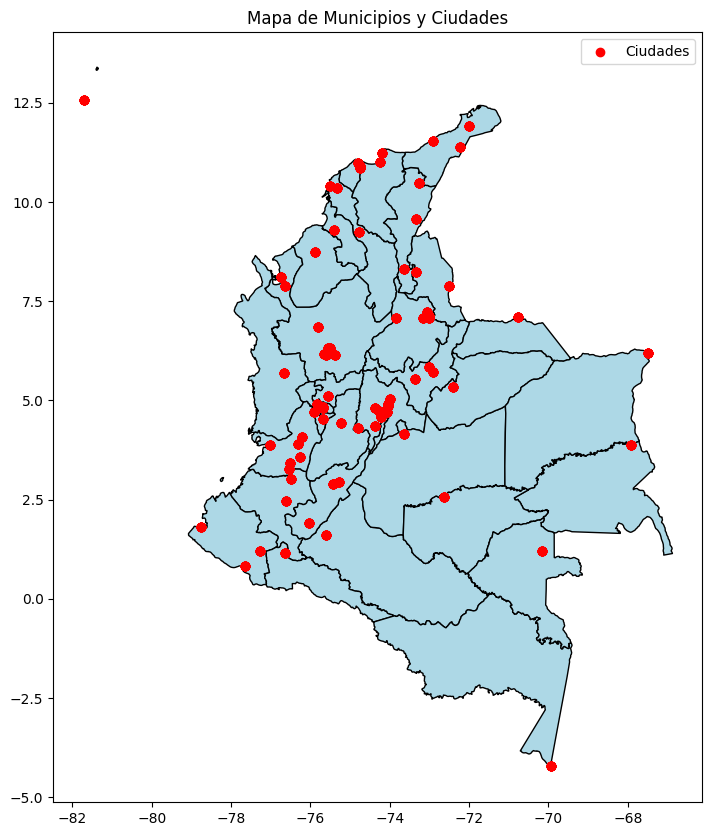

In [15]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 10))

Departamentos.plot(ax=ax, color='lightblue', edgecolor='black', label='Municipios')
Total_18_Geometry.plot(ax=ax, color='red', marker='o', label='Ciudades')
plt.title('Mapa de Municipios y Ciudades')
plt.legend()
plt.show()

### To add each department to its city we use a sjoin_nearest with which each city is grouped with the closest department

In [16]:

if Total_18_Geometry.crs is None:
    Total_18_Geometry = Total_18_Geometry.set_crs(Departamentos.crs, allow_override=True)

Total_18_Geometry = gpd.sjoin_nearest(Total_18_Geometry,  Departamentos, how='left', distance_col='distancia').drop(['AREA' , 'PERIMETER' , 'HECTARES' , 'DPTO','index_right' , 'distancia'] , axis=1)
Total_18_Geometry

C:\Users\alejo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\geopandas\array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


,Ciudad,Mes,Extranjeros no Residentes,Homicidios,Hurtos,Delitos Sexuales,geometry,Departamento
0,pitalito,January,33.0,2,61,15,POINT (-76.0419 1.8989),huila
1,pitalito,February,42.0,0,33,11,POINT (-76.0419 1.8989),huila
2,pitalito,March,38.0,3,41,10,POINT (-76.0419 1.8989),huila
3,pitalito,April,21.0,4,56,21,POINT (-76.0419 1.8989),huila
4,pitalito,May,34.0,3,44,20,POINT (-76.0419 1.8989),huila
...,...,...,...,...,...,...,...,...
967,magangue,August,1.0,1,25,9,POINT (-74.7667 9.25),bolivar
968,magangue,September,2.0,2,24,7,POINT (-74.7667 9.25),bolivar
969,magangue,October,1.0,1,30,8,POINT (-74.7667 9.25),bolivar
970,magangue,November,1.0,1,31,5,POINT (-74.7667 9.25),bolivar


### We check for missing data

In [17]:

Total_18_Geometry[Total_18_Geometry.isnull().any(axis=1)]

,Ciudad,Mes,Extranjeros no Residentes,Homicidios,Hurtos,Delitos Sexuales,geometry,Departamento


## Add Weather

Base with weather information (it's very heavy)

In [18]:

clima = pd.read_csv("C:\\Users\\alejo\\OneDrive\\Escritorio\\Universidaad\\Colab Notebooks\\Ia en economia\\Proyecto\\Datos_Hidrometeorol_gicos_Crudos_-_Red_de_Estaciones_IDEAM___Temperatura_20241001.csv")

C:\Users\alejo\AppData\Local\Temp\ipykernel_11896\3672296611.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  clima = pd.read_csv("C:\\Users\\alejo\\OneDrive\\Escritorio\\Universidaad\\Colab Notebooks\\Ia en economia\\Proyecto\\Datos_Hidrometeorol_gicos_Crudos_-_Red_de_Estaciones_IDEAM___Temperatura_20241001.csv")


We changed the observations to monthly

In [19]:

clima['FechaObservacion'] = pd.to_datetime(clima['FechaObservacion'])
clima['Mes'] = clima['FechaObservacion'].dt.month_name()
clima=clima.dropna()

C:\Users\alejo\AppData\Local\Temp\ipykernel_11896\552898946.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  clima['FechaObservacion'] = pd.to_datetime(clima['FechaObservacion'])


### We graph the distribution of the climate

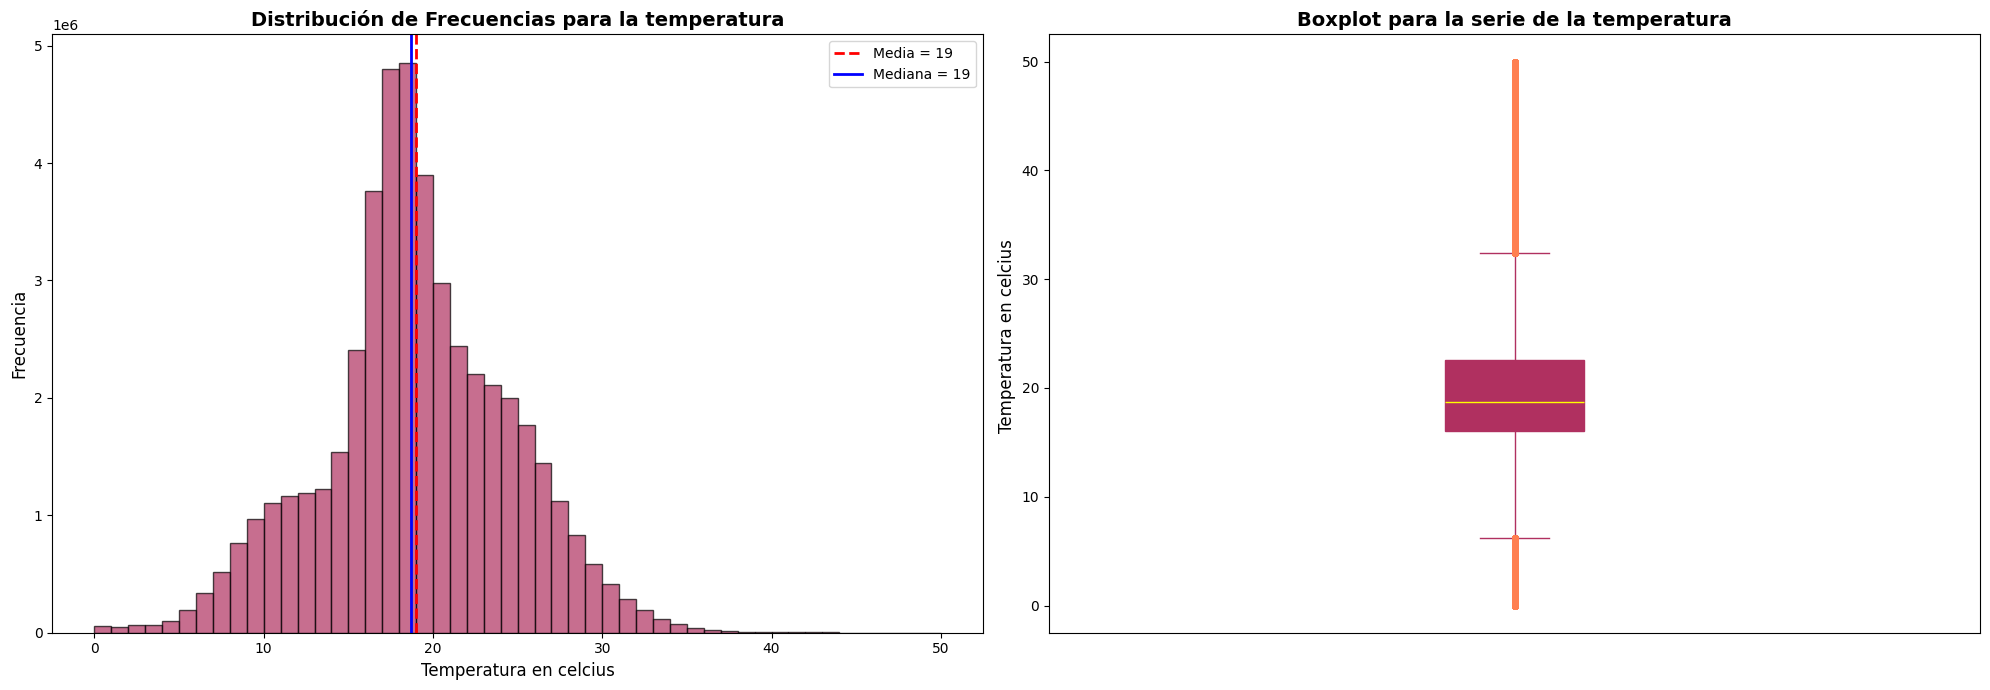

In [20]:
import math
frecuencia_categorias = clima['ValorObservado']
media_variable1 = clima['ValorObservado'].mean()
mediana_variable1 = clima['ValorObservado'].median()


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))

ax1 = axes[0]
ax1.hist(frecuencia_categorias, alpha=0.7,edgecolor='black' , bins = 50 , color = '#B03060') 
ax1.axvline(x=media_variable1, color='red', linestyle='dashed', linewidth=2, label=f'Media = {media_variable1:,.0f}')
ax1.axvline(x=mediana_variable1, color='blue', linestyle='-', linewidth=2, label=f'Mediana = {mediana_variable1:,.0f}')
ax1.legend()
ax1.set_title('Distribución de Frecuencias para la temperatura', fontsize=14, weight='bold')
ax1.set_xlabel('Temperatura en celcius', fontsize=12)
ax1.set_ylabel('Frecuencia', fontsize=12)

ax2 = axes[1]
box = ax2.boxplot(frecuencia_categorias, vert=True, patch_artist=True,boxprops=dict(facecolor='#B03060', color='#B03060'),medianprops=dict(color='yellow'),
    whiskerprops=dict(color='#B03060'),capprops=dict(color='#B03060'),flierprops=dict(marker='o', markerfacecolor='#FF7F50', markersize=5, linestyle='none', markeredgecolor='none'))
ax2.set_title('Boxplot para la serie de la temperatura', fontsize=14, weight='bold')
ax2.set_ylabel('Temperatura en celcius ', fontsize=12)
ax2.set_xticks([])

plt.tight_layout()
plt.show()

### We filter by 2018 and fix the text

In [ ]:
# Filtramos por 2018 y arreglamos el texto 
clima_2018 = clima[clima['FechaObservacion'].dt.year == 2018]
clima_2018 = arreglar_texto(clima_2018 , 'Municipio', 'Ciudad')

### We complete the months with our function so as not to have missing months

In [22]:

clima_2018= completar_meses(clima_2018 , 'Ciudad' , 'Mes' ,'ValorObservado' , 0)
clima_2018

La funcion demoro 1.2253856658935547


,Ciudad,Mes,ValorObservado
0,acandi,January,27.10
1,acandi,February,27.00
2,acandi,March,27.50
3,acandi,April,27.50
4,acandi,May,26.30
...,...,...,...
3283,zonabananera,August,27.80
3284,zonabananera,September,26.90
3285,zonabananera,October,26.20
3286,zonabananera,November,27.45


### We merge to add the temperature variable to our cumulative base

In [23]:

Total_18_Clima= pd.merge(Total_18_Geometry, clima_2018[['Ciudad', 'ValorObservado' ,'Mes']], on=['Ciudad' ,'Mes'], how='left')
Total_18_Clima = Total_18_Clima.rename(columns={'ValorObservado': 'Temperatura'})


In [24]:
Total_18_Clima.head(15)

,Ciudad,Mes,Extranjeros no Residentes,Homicidios,Hurtos,Delitos Sexuales,geometry,Departamento,Temperatura
0,pitalito,January,33.0,2,61,15,POINT (-76.0419 1.8989),huila,18.055550
1,pitalito,February,42.0,0,33,11,POINT (-76.0419 1.8989),huila,19.162195
2,pitalito,March,38.0,3,41,10,POINT (-76.0419 1.8989),huila,18.932345
3,pitalito,April,21.0,4,56,21,POINT (-76.0419 1.8989),huila,17.755805
4,pitalito,May,34.0,3,44,20,POINT (-76.0419 1.8989),huila,18.277850
5,pitalito,June,54.0,0,54,8,POINT (-76.0419 1.8989),huila,17.493370
6,pitalito,July,38.0,3,39,5,POINT (-76.0419 1.8989),huila,17.501840
7,pitalito,August,32.0,2,50,14,POINT (-76.0419 1.8989),huila,17.179000
8,pitalito,September,33.0,5,66,18,POINT (-76.0419 1.8989),huila,17.903305
9,pitalito,October,42.0,2,64,10,POINT (-76.0419 1.8989),huila,18.714300


## Kriggin For the missing temperatures

Since we have missing values, we will use kriging to interpolate the gaps in our geospatial dataset. Kriging is a geostatistical interpolation method that leverages the spatial autocorrelation of observed data—meaning it models how measurements relate to one another based on their distances and directions. By fitting a variogram to quantify this spatial structure, kriging provides the “best linear unbiased prediction” at unsampled locations and even supplies an estimate of the prediction uncertainty.

Because it explicitly accounts for the way values change across space, kriging tends to outperform simpler approaches (like inverse-distance weighting) when filling in missing geographic data. It adapts to local patterns, minimizes overall estimation variance, and delivers both interpolated values and their confidence levels, making it especially well-suited for completing incomplete geospatial datasets.


In [25]:

print('Lac cantidad de NaN que hay en la variable temperatura es:' ,Total_18_Clima['Temperatura'].isnull().sum())

Lac cantidad de NaN que hay en la variable temperatura es: 413


### Return months to numbers

In [26]:

df_kriging = meses_a_numeros(Total_18_Clima , 'Mes')
df_kriging.head()

,Ciudad,Mes,Extranjeros no Residentes,Homicidios,Hurtos,Delitos Sexuales,geometry,Departamento,Temperatura
0,pitalito,1,33.0,2,61,15,POINT (-76.0419 1.8989),huila,18.055550
1,pitalito,2,42.0,0,33,11,POINT (-76.0419 1.8989),huila,19.162195
2,pitalito,3,38.0,3,41,10,POINT (-76.0419 1.8989),huila,18.932345
3,pitalito,4,21.0,4,56,21,POINT (-76.0419 1.8989),huila,17.755805
4,pitalito,5,34.0,3,44,20,POINT (-76.0419 1.8989),huila,18.277850


### Convert the DF geometry to a single coordinate system so there are no problems when measuring distances

In [27]:

df_kriging.set_crs(epsg=4326, inplace=True)
df_kriging=df_kriging.to_crs(epsg=32618)  
df_kriging.head()

,Ciudad,Mes,Extranjeros no Residentes,Homicidios,Hurtos,Delitos Sexuales,geometry,Departamento,Temperatura
0,pitalito,1,33.0,2,61,15,POINT (384119.441 209921.192),huila,18.055550
1,pitalito,2,42.0,0,33,11,POINT (384119.441 209921.192),huila,19.162195
2,pitalito,3,38.0,3,41,10,POINT (384119.441 209921.192),huila,18.932345
3,pitalito,4,21.0,4,56,21,POINT (384119.441 209921.192),huila,17.755805
4,pitalito,5,34.0,3,44,20,POINT (384119.441 209921.192),huila,18.277850


### We apply ordinary krigging

In [28]:

from pykrige.ok import OrdinaryKriging
import numpy as np

meses_krig = df_kriging['Mes'].unique()

for i in meses_krig:
    print('Procesando Mes:' ,i)
    
    df_kriging_mes = df_kriging[df_kriging['Mes'] == i] # We will perform the kriging by month
    df_kriging_known = df_kriging_mes.dropna(subset=['Temperatura']) # The data for which we have temperature
    df_kriging_missing = df_kriging_mes[df_kriging_mes ['Temperatura'].isna()] # Data for those of us who do not have temperature (Variable to predict)
    
    if df_kriging_missing.empty:
        print('No hay datos faltantes en el mes ' , i) # If any month is full for all cities, do nothing
        continue
    
    # Our variables to predict
    x_known = df_kriging_known.geometry.x.values
    y_known = df_kriging_known.geometry.y.values
    z_known = df_kriging_known['Temperatura'].values
    
    # Our data to predict
    x_missing = df_kriging_missing.geometry.x.values
    y_missing = df_kriging_missing.geometry.y.values
    
    # Create the model
    Krigg = OrdinaryKriging(
        x_known, y_known, z_known,
        variogram_model='spherical',
        verbose=False,
        enable_plotting=False)
    
    # Making predictions with krigging
    z_pred, ss = Krigg.execute('points', x_missing, y_missing)
    
    # Enter the values ​​in the DF
    df_kriging.loc[df_kriging_missing.index, 'Temperatura'] = z_pred



Procesando Mes: 1
Procesando Mes: 2
Procesando Mes: 3
Procesando Mes: 4
Procesando Mes: 5
Procesando Mes: 6
Procesando Mes: 7
Procesando Mes: 8
Procesando Mes: 9
Procesando Mes: 10
Procesando Mes: 11
Procesando Mes: 12


### We can see that we no longer have missing data

In [29]:
# Podemos ver que ya no tenemos datos faltantes 
print('Lac cantidad de NaN que hay en la variable temperatura es:' ,df_kriging['Temperatura'].isnull().sum())
df_kriging.head(15)

Lac cantidad de NaN que hay en la variable temperatura es: 0


,Ciudad,Mes,Extranjeros no Residentes,Homicidios,Hurtos,Delitos Sexuales,geometry,Departamento,Temperatura
0,pitalito,1,33.0,2,61,15,POINT (384119.441 209921.192),huila,18.055550
1,pitalito,2,42.0,0,33,11,POINT (384119.441 209921.192),huila,19.162195
2,pitalito,3,38.0,3,41,10,POINT (384119.441 209921.192),huila,18.932345
3,pitalito,4,21.0,4,56,21,POINT (384119.441 209921.192),huila,17.755805
4,pitalito,5,34.0,3,44,20,POINT (384119.441 209921.192),huila,18.277850
5,pitalito,6,54.0,0,54,8,POINT (384119.441 209921.192),huila,17.493370
6,pitalito,7,38.0,3,39,5,POINT (384119.441 209921.192),huila,17.501840
7,pitalito,8,32.0,2,50,14,POINT (384119.441 209921.192),huila,17.179000
8,pitalito,9,33.0,5,66,18,POINT (384119.441 209921.192),huila,17.903305
9,pitalito,10,42.0,2,64,10,POINT (384119.441 209921.192),huila,18.714300


# Add dollar price

In [30]:

Dolar = pd.read_excel('C:\\Users\\alejo\\OneDrive\\Escritorio\\Universidaad\\Colab Notebooks\\Ia en economia\\Proyecto\\Dolar.xlsx')
Dolar

,Fecha,Dolar
0,2017/12/31,2984.00
1,2018/01/01,2984.00
2,2018/01/02,2940.94
3,2018/01/03,2908.68
4,2018/01/04,2885.76
...,...,...
2441,2024/10/02,4203.43
2442,2024/10/03,4197.73
2443,2024/10/04,4173.66
2444,2024/10/05,4173.66


## We graph the dollar series

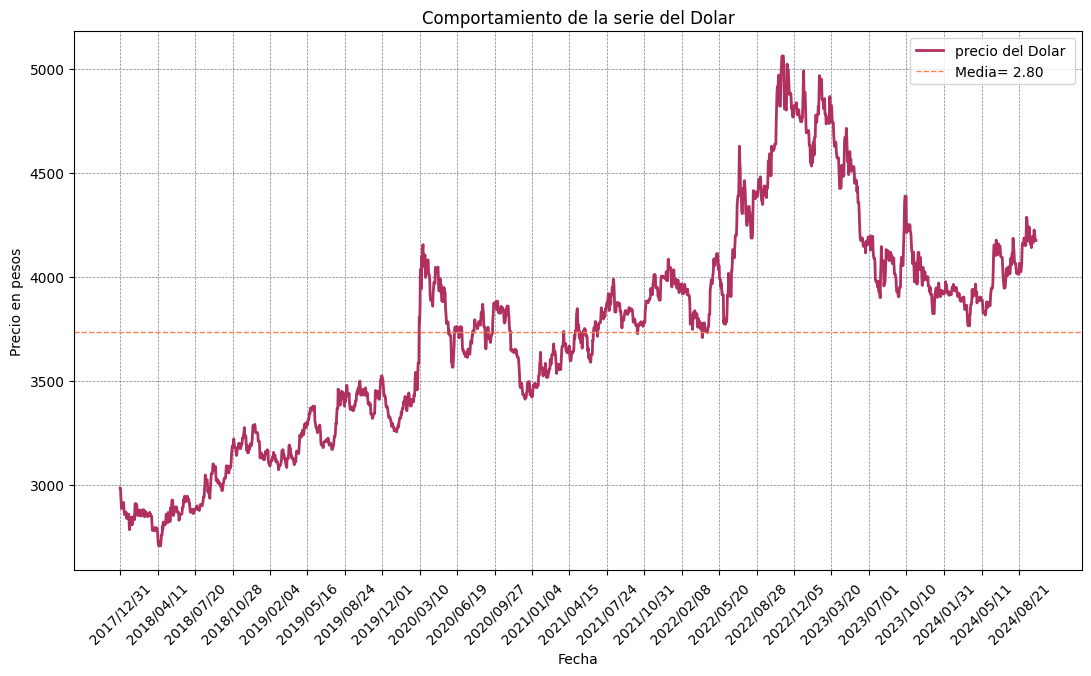

In [31]:
mean = Dolar['Dolar'].mean()

plt.figure(figsize=(13, 7))    
plt.plot(Dolar['Fecha'], Dolar ['Dolar'] ,label="precio del Dolar ", 
         linewidth=2 , color='#B03060')
plt.axhline(mean, color='#FF7F50', linestyle='--', label='Media= 2.80 ', linewidth=1)
cuartiles_a_mostrar = Dolar ['Fecha'][::100]
plt.xticks(cuartiles_a_mostrar, rotation=45)
plt.xlabel('Fecha')
plt.ylabel('Precio en pesos')
plt.title('Comportamiento de la serie del Dolar')
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

### We plot a boxplot by periods to see the trend and atypical data of the dollar series

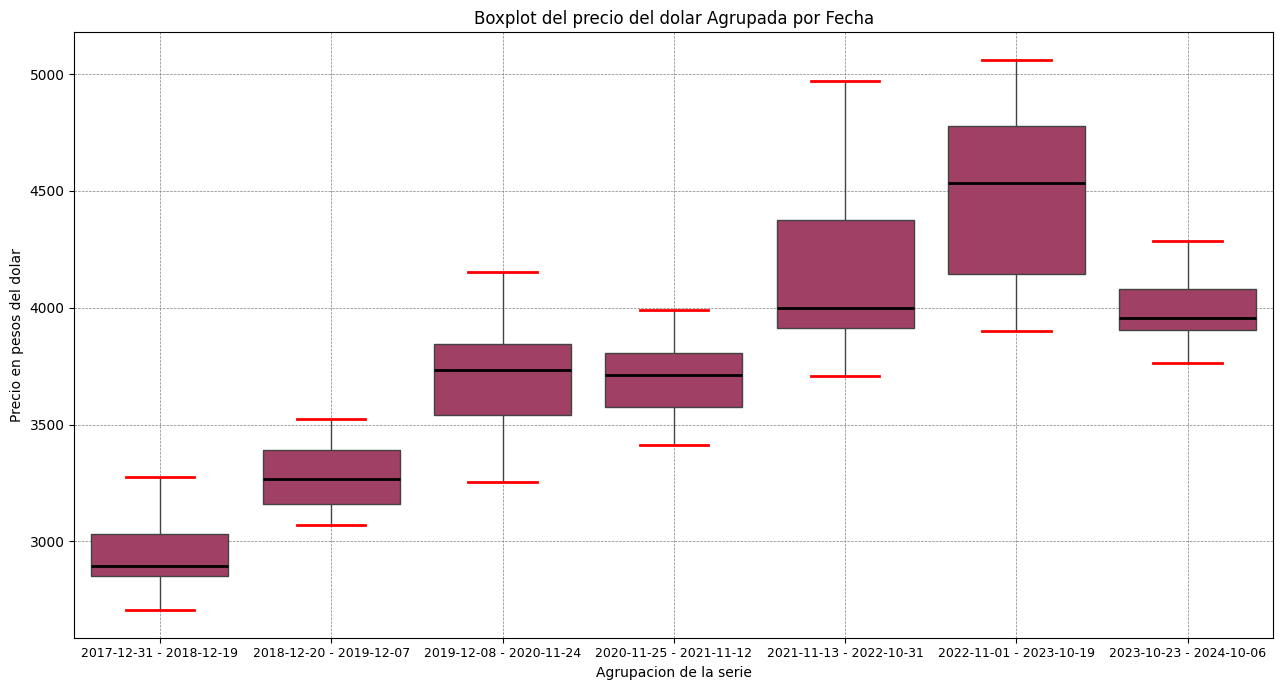

In [32]:

import seaborn as sns

Dolar['Fecha'] = pd.to_datetime(Dolar['Fecha'])
Dolar['grupo_fecha'] = pd.cut(Dolar['Fecha'], bins=7, labels=False)
grupo_limites = Dolar.groupby('grupo_fecha')['Fecha'].agg(['min', 'max']).reset_index()

plt.figure(figsize=(13, 7))
sns.boxplot(x='grupo_fecha', y='Dolar', data=Dolar, color='#B03060' , capprops = dict(color = "red", linewidth = 2)
, flierprops = dict(marker = "s", markerfacecolor = '#FF7F50') , medianprops=dict(color='black', linewidth=2))
plt.xticks(ticks=range(len(grupo_limites)), labels=[f'{min_date.strftime("%Y-%m-%d")} - {max_date.strftime("%Y-%m-%d")}' for min_date, max_date in zip(grupo_limites['min'], grupo_limites['max'])])
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
plt.tick_params(axis='x', labelsize=9)
plt.xlabel('Agrupacion de la serie')
plt.ylabel('Precio en pesos del dolar')
plt.title('Boxplot del precio del dolar Agrupada por Fecha')
plt.tight_layout()
plt.show()

### We calculate the median per month

In [33]:

Dolar['Fecha'] = pd.to_datetime(Dolar['Fecha'], errors='coerce')
Dolar.set_index('Fecha', inplace=True)
Dolar = Dolar.resample('M').median()
Dolar = Dolar.reset_index()

### We filter for the year we are analyzing and complete the months

In [ ]:

Dolar_2018=Dolar[Dolar['Fecha'].dt.year == 2018]
Dolar_2018['Mes'] = range(1, 13)

### We add the dollar variable and lets see how is the DataFrame now 

In [35]:

Base_2018=pd.merge(df_kriging, Dolar_2018, on= 'Mes', how='right').drop('Fecha' , axis=1).drop('grupo_fecha' , axis =1)
Base_2018

,Ciudad,Mes,Extranjeros no Residentes,Homicidios,Hurtos,Delitos Sexuales,geometry,Departamento,Temperatura,Dolar
0,pitalito,1,33.0,2,61,15,POINT (384119.441 209921.192),huila,18.055550,2855.86
1,riohacha,1,108.0,4,49,8,POINT (728275.629 1276987.69),laguajira,26.700000,2855.86
2,rionegro,1,271.0,2,51,7,POINT (458587.876 680187.339),antioquia,15.500000,2855.86
3,bogota,1,99767.0,83,7149,426,POINT (602898.9 520798.299),bogotadc,12.600000,2855.86
4,piedecuesta,1,28.0,1,66,13,POINT (720906.443 783432.99),santander,22.523648,2855.86
...,...,...,...,...,...,...,...,...,...,...
967,aguachica,12,14.0,2,28,4,POINT (650504.481 919569.475),cesar,27.550000,3198.45
968,sanjosedelguaviare,12,8.0,1,12,11,POINT (763167.066 283942.885),guaviare,21.841149,3198.45
969,palermo,12,1.0,0,8,0,POINT (451378.305 319631.823),huila,21.841149,3198.45
970,mitu,12,0.0,0,0,4,POINT (1037614.182 132922.769),vaupes,21.841149,3198.45


## Monthly GDP Interpolation

Because we apply a year-by-year LOESS smoothing, this component is especially sensitive to annual fluctuations—making it one of the most dynamic parts of our pipeline. LOESS (Locally Estimated Scatterplot Smoothing) fits a smooth curve through the annual GDP observations by performing weighted regressions on localized subsets of the data. By repeating this process separately for each calendar year, we ensure that the interpolation adapts to short-term shifts rather than forcing a single global trend across all years.

When you review the full “base final” script, you’ll notice that the shape of the GDP growth curve varies substantially from one year to the next. That variation largely reflects changes in inflation: during periods of higher price pressure, real GDP growth tends to flatten or even dip when adjusted for inflation, whereas lower-inflation years often show stronger upward momentum in the LOESS fit. Highlighting this dependency is crucial because it reminds us that nominal output and real-term expansion do not always move in lockstep—adjusting for inflation reveals the true rhythm of economic activity at a monthly frequency.


In [36]:

PIB= pd.read_excel('C:\\Users\\alejo\\OneDrive\\Escritorio\\Universidaad\\Colab Notebooks\\Ia en economia\\Proyecto\\PIB - Miles de millones de pesos  - 2018.xlsx')
PIB= arreglar_texto(PIB, 'DEPARTAMENTO' , 'Departamento')
PIB['VALOR (unidades)'] = PIB['VALOR (unidades)'].str.replace(',', '.')
PIB['VALOR (unidades)'] = pd.to_numeric(PIB['VALOR (unidades)'], errors='coerce')
PIB.head(5)

La funcion demoro 0.0010023117065429688


,CÓDIGO,Departamento,VALOR (unidades)
0,11,bogotadc,253941.02
1,5,antioquia,141680.08
2,76,valledelcauca,95893.69
3,68,santander,63776.08
4,25,cundinamarca,59084.78


In [37]:
from statsmodels.nonparametric.smoothers_lowess import lowess
import numpy as np
import matplotlib.pyplot as plt

meses_loees = np.arange(1, 13)
tendencia_mensual_inflacion = [3.68, 3.37, 3.14, 3.13, 3.16, 3.20, 3.12, 3.10, 3.23, 3.33, 3.27, 3.18]  # The trend we’ll use is monthly inflation, since higher GDP output usually drives up inflation.
# The source for these values can be found in the Banco de la República’s annual charts.

patron_estacional = np.array([valor / sum(tendencia_mensual_inflacion) for valor in tendencia_mensual_inflacion])
patron_estacional = patron_estacional / patron_estacional.sum()

# We introduce noise into our pattern to simulate real economic fluctuations.
np.random.seed(42)
patron_ruido = patron_estacional + np.random.normal(0, 0.005, 12)
patron_ruido = np.clip(patron_ruido, 0.01, None)  # Ensure all fluctuations remain positive.
patron_ruido = patron_ruido / patron_ruido.sum()

loess_result = lowess(patron_ruido, meses_loees, frac=0.4)  # Generate the pattern using LOESS
meses_smooth = loess_result[:, 0]
patron_smooth = loess_result[:, 1]
patron_smooth = patron_smooth / patron_smooth.sum()  # Normalize the smoothed output


### Here we can see how the pattern for breaking down monthly GDP based on inflation looks like.

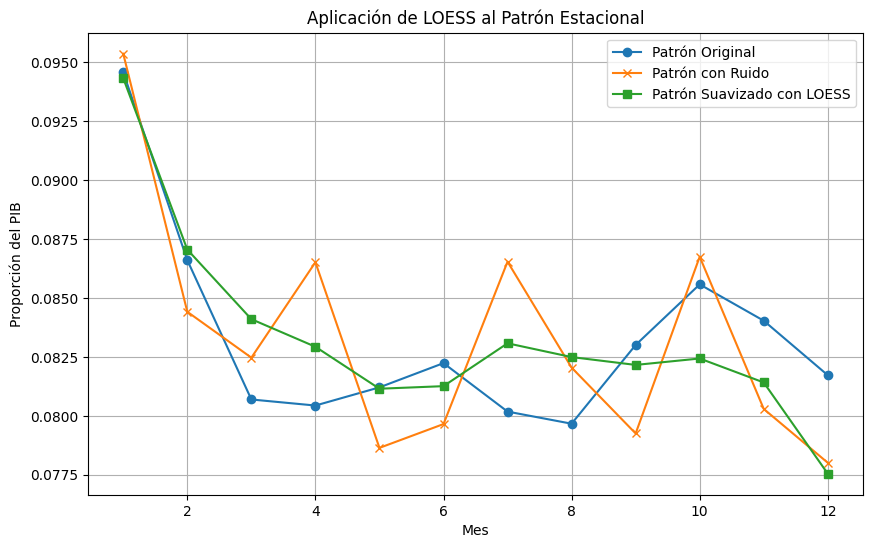

In [39]:

plt.figure(figsize=(10, 6))
plt.plot(meses_loees, patron_estacional, label='Patrón Original', marker='o')
plt.plot(meses_loees, patron_ruido, label='Patrón con Ruido', marker='x')
plt.plot(meses_smooth, patron_smooth, label='Patrón Suavizado con LOESS', marker='s')
plt.xlabel('Mes')
plt.ylabel('Proporción del PIB')
plt.title('Aplicación de LOESS al Patrón Estacional')
plt.legend()
plt.grid(True)
plt.show()

###  Base with departmental GDP per month after LOESS

In [52]:
#Function to break down GDP and allocate it monthly
def descomponer_pib_loess(pib_anual, patron):
    def asignar_pib_mensual(k, patron):
        pib_mensual = patron * k['VALOR (unidades)']
        return pib_mensual

    df_mensual = pd.DataFrame()
    
    for i, k in pib_anual.iterrows():
        pib_mensual = asignar_pib_mensual(k, patron)
        
        df_temp = pd.DataFrame({
            'Departamento': k['Departamento'],
            'Mes': np.arange(1, 13),
            'PIB_Mensual': pib_mensual
        })
        
        df_mensual = pd.concat([df_mensual, df_temp], ignore_index=True)
    
    return df_mensual

pib_mensual = descomponer_pib_loess(PIB, patron_smooth)
pib_mensual

,Departamento,Mes,PIB_Mensual
0,bogotadc,1,23953.819812
1,bogotadc,2,22107.668727
2,bogotadc,3,21357.991522
3,bogotadc,4,21060.810012
4,bogotadc,5,20608.644964
...,...,...,...
391,vaupes,8,23.214976
392,vaupes,9,23.121204
393,vaupes,10,23.197925
394,vaupes,11,22.911580


### Check if the smoothing was correct (we can see it if the two columns, GDP and value, are equal)

In [53]:
# Verificar si el suavizado dio bien (podemos verlo si las dos columnas, PIB y valor son iguales)
suma_mensual = pib_mensual.groupby(['Departamento'])['PIB_Mensual'].sum().reset_index()
verificacion = pd.merge(suma_mensual, PIB, on= 'Departamento', how='left').drop('CÓDIGO' , axis=1)
verificacion

,Departamento,PIB_Mensual,VALOR (unidades)
0,amazonas,759.18,759.18
1,antioquia,141680.08,141680.08
2,arauca,5091.16,5091.16
3,archipielagodesanandresprovidenciaysantacatalina,1531.11,1531.11
4,atlantico,43368.87,43368.87
5,bogotadc,253941.02,253941.02
6,bolivar,35410.29,35410.29
7,boyaca,26884.21,26884.21
8,caldas,15710.83,15710.83
9,caqueta,4071.61,4071.61


## Weight GDP by city

Since obtaining a complete city-level GDP series from 2018 to 2024 is not easy, we will first use the monthly LOESS decomposition we applied at the department leveland weight it
by each city’s share of production and consumption within the department, thereby deriving a meaningful approximation.

Note: the dataset you provided, Prof, did not include every year, so we use this approach

In [54]:
importancia_pesos = pd.read_excel('C:\\Users\\alejo\\OneDrive\\Escritorio\\Universidaad\\Colab Notebooks\\Ia en economia\\Proyecto\\importancia-municipal.xlsx')

importancia_pesos = arreglar_texto(importancia_pesos , 'Municipio / Distrito' , 'Ciudad')
importancia_pesos['Departamento'] = importancia_pesos['Departamento'].astype(str)
importancia_pesos = arreglar_texto(importancia_pesos , 'Departamento' , 'Departamento')

# Leave only the cities we are working on.
for i in importancia_pesos['Ciudad']:
    indice = importancia_pesos[importancia_pesos['Ciudad'] == i].index
    if i not in grandes_ciudades:
        importancia_pesos = importancia_pesos.drop(index=indice)
    else:
        pass

# We match each city with its GDP and weight it by the relative municipal weight of added value
importancia_pesos_mensual = importancia_pesos.loc[importancia_pesos.index.repeat(12)].reset_index(drop=True)
importancia_pesos_mensual['Mes'] = (importancia_pesos_mensual.index % 12) + 1
pib_pesos_ciudades1 = pd.merge(importancia_pesos_mensual, pib_mensual, on=['Departamento', 'Mes'], how='left')
pib_pesos_ciudades1['Peso relativo municipal en el valor agregado departamental %'] = pib_pesos_ciudades1['Peso relativo municipal en el valor agregado departamental %'] /100
pib_pesos_ciudades1['Pib Ponderado'] = pib_pesos_ciudades1['Peso relativo municipal en el valor agregado departamental %'] * pib_pesos_ciudades1['PIB_Mensual']
pib_pesos_ciudades1

La funcion demoro 0.019277095794677734
La funcion demoro 0.006017446517944336


,Departamento,Ciudad,Grado de importancia económica,Peso relativo municipal en el valor agregado departamental %,Mes,PIB_Mensual,Pib Ponderado
0,antioquia,medellin,1,0.455058,1,13364.438353,6081.597689
1,antioquia,medellin,1,0.455058,2,12334.424245,5612.881290
2,antioquia,medellin,1,0.455058,3,11916.160483,5422.546922
3,antioquia,medellin,1,0.455058,4,11750.355446,5347.095975
4,antioquia,medellin,1,0.455058,5,11498.081197,5232.296501
...,...,...,...,...,...,...,...
967,vichada,puertocarreno,5,0.263186,8,52.377244,13.784948
968,vichada,puertocarreno,5,0.263186,9,52.165676,13.729267
969,vichada,puertocarreno,5,0.263186,10,52.338772,13.774823
970,vichada,puertocarreno,5,0.263186,11,51.692726,13.604793


### Chart for the importance of cities in departments

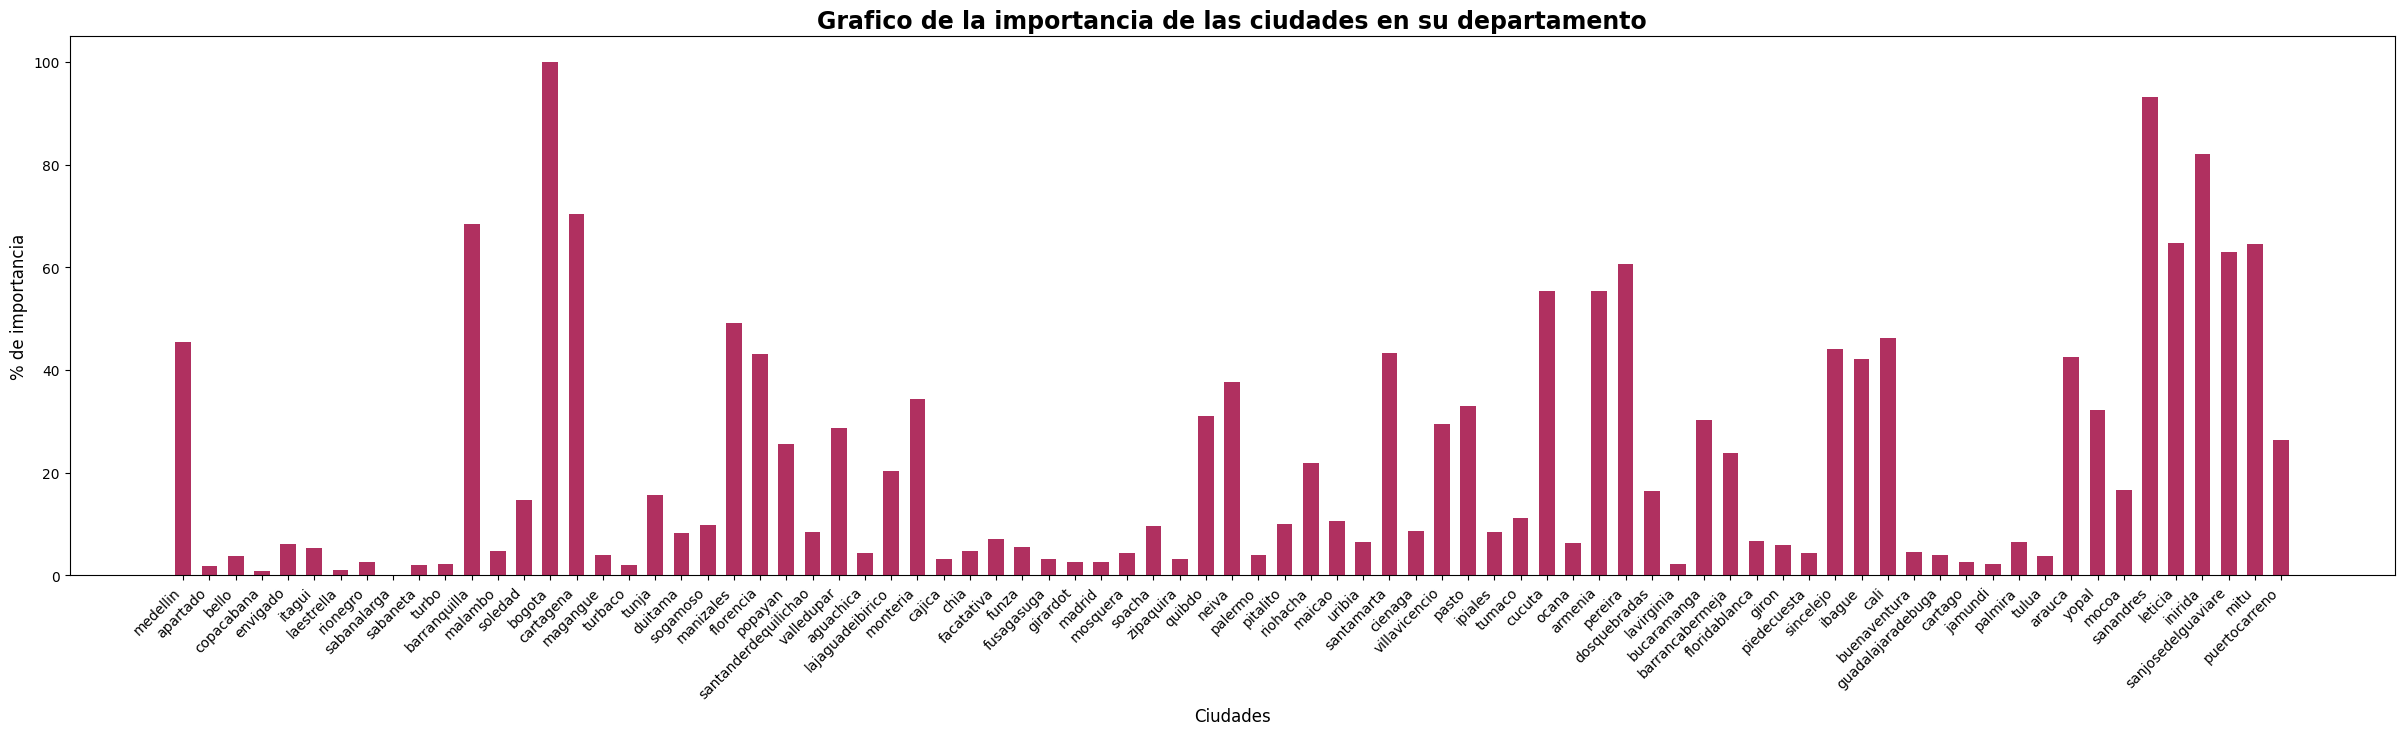

In [43]:
importancia_unico = importancia_pesos.drop_duplicates()

plt.figure(figsize=(30, 7))
plt.bar(importancia_unico['Ciudad'], importancia_unico['Peso relativo municipal en el valor agregado departamental %'], width=0.6 , color = '#B03060')
plt.title('Grafico de la importancia de las ciudades en su departamento' , fontsize=17, fontweight='bold')
plt.xlabel('Ciudades', fontsize=12)
plt.ylabel('% de importancia', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.show()


### We add the decomposed GDP to the database we were working with:

In [55]:

fusion_left = pd.merge(Base_2018, pib_pesos_ciudades1[['Pib Ponderado' , 'Ciudad', 'Mes']], on=['Ciudad', 'Mes'], how='left')
fusion_left

,Ciudad,Mes,Extranjeros no Residentes,Homicidios,Hurtos,Delitos Sexuales,geometry,Departamento,Temperatura,Dolar,Pib Ponderado
0,pitalito,1,33.0,2,61,15,POINT (384119.441 209921.192),huila,18.055550,2855.86,151.999238
1,riohacha,1,108.0,4,49,8,POINT (728275.629 1276987.69),laguajira,26.700000,2855.86,245.473018
2,rionegro,1,271.0,2,51,7,POINT (458587.876 680187.339),antioquia,15.500000,2855.86,343.717029
3,bogota,1,99767.0,83,7149,426,POINT (602898.9 520798.299),bogotadc,12.600000,2855.86,23953.819812
4,piedecuesta,1,28.0,1,66,13,POINT (720906.443 783432.99),santander,22.523648,2855.86,258.755835
...,...,...,...,...,...,...,...,...,...,...,...
967,aguachica,12,14.0,2,28,4,POINT (650504.481 919569.475),cesar,27.550000,3198.45,73.597907
968,sanjosedelguaviare,12,8.0,1,12,11,POINT (763167.066 283942.885),guaviare,21.841149,3198.45,38.317074
969,palermo,12,1.0,0,8,0,POINT (451378.305 319631.823),huila,21.841149,3198.45,48.387369
970,mitu,12,0.0,0,0,4,POINT (1037614.182 132922.769),vaupes,21.841149,3198.45,14.093870


### We check if any row has Nan

In [56]:

fusion_left[fusion_left.isnull().any(axis=1)]

,Ciudad,Mes,Extranjeros no Residentes,Homicidios,Hurtos,Delitos Sexuales,geometry,Departamento,Temperatura,Dolar,Pib Ponderado


### This is to check a single city in the year and see if all the variables are actually adding correctly.

In [46]:

fusion_left[fusion_left['Ciudad'] == 'armenia']

,Ciudad,Mes,Extranjeros no Residentes,Homicidios,Hurtos,Delitos Sexuales,geometry,Departamento,Temperatura,Dolar,Pib Ponderado
15,armenia,1,707.0,6,139,31,POINT (424566.064 500746.928),quindio,22.283069,2855.86,416.070435
96,armenia,2,763.0,8,118,20,POINT (424566.064 500746.928),quindio,22.334702,2853.16,384.003362
177,armenia,3,829.0,11,106,24,POINT (424566.064 500746.928),quindio,22.532732,2852.48,370.981701
258,armenia,4,609.0,6,123,17,POINT (424566.064 500746.928),quindio,19.700000,2780.47,365.819750
339,armenia,5,756.0,7,164,24,POINT (424566.064 500746.928),quindio,19.900000,2863.12,357.965783
420,armenia,6,1040.0,4,139,17,POINT (424566.064 500746.928),quindio,20.900000,2889.69,358.446680
501,armenia,7,1174.0,9,129,23,POINT (424566.064 500746.928),quindio,20.700000,2881.09,366.464888
582,armenia,8,1303.0,8,140,11,POINT (424566.064 500746.928),quindio,22.500000,2958.45,363.889137
663,armenia,9,829.0,8,137,23,POINT (424566.064 500746.928),quindio,22.811022,3026.05,362.419279
744,armenia,10,655.0,5,150,12,POINT (424566.064 500746.928),quindio,21.741970,3087.46,363.621855


# Add Entry Sites

In this database, we can see which international arrival point each foreigner arrived at. This variable is useful since cities near these points are more likely to receive tourists. Also, cities where foreigners first arrive may be their final destination.

In [38]:

entradas = pd.read_csv('C:\\Users\\alejo\\OneDrive\\Escritorio\\Universidaad\\Colab Notebooks\\Ia en economia\\Proyecto\\Entradas_de_extranjeros_a_Colombia_20241006.csv')

In [39]:
# Select only the year and complete the months
entradas_2018= entradas[entradas['Año']==2018]
entradas_2018 =traducir(entradas_2018 , 'Mes')
entradas_2018 =meses_a_numeros(entradas_2018 , 'Mes' )
entradas_2018

C:\Users\alejo\AppData\Local\Temp\ipykernel_11896\301107249.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[mes] = df[mes].map(meses_esp)
C:\Users\alejo\AppData\Local\Temp\ipykernel_11896\301107249.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[mes] = df[mes].map(meses_invertido)


,Año,Mes,Nacionalidad,Codigo Iso 3166,Femenino,Masculino,Indefinido,Total,Latitud - Longitud
72888,2018,1,Afganistán,4,0,1,NaN,1,"(10.445761,-75.516429)"
72889,2018,1,Afganistán,4,1,0,NaN,1,"(4.697144,-74.140516)"
72890,2018,1,Albania,8,1,1,NaN,2,"(10.445761,-75.516429)"
72891,2018,1,Albania,8,1,8,NaN,9,"(4.697144,-74.140516)"
72892,2018,1,Albania,8,0,1,NaN,1,"(6.171601,-75.427454)"
...,...,...,...,...,...,...,...,...,...
86342,2018,12,Desconocido,99999,1,0,NaN,1,"(4.815061,-75.736532)"
86343,2018,12,Desconocido,99999,0,5,NaN,5,"(6.171601,-75.427454)"
86344,2018,12,Desconocido,99999,2,0,NaN,2,"(7.088729,-70.740253)"
86345,2018,12,Desconocido,99999,0,1,NaN,1,"(8.36068,-72.409396)"


### We complete and leave how much were the entries per month from the different international arrival points

In [49]:

entradas_2018 =completar_meses(entradas_2018, 'Latitud - Longitud' , 'Mes' , 'Total' ,1 )
entradas_2018 =meses_a_numeros(entradas_2018 , 'Mes' )
entradas_2018

La funcion demoro 0.0070037841796875


,Latitud - Longitud,Mes,Total
0,"(10.445761,-75.516429)",1,26303.0
1,"(10.445761,-75.516429)",2,27987.0
2,"(10.445761,-75.516429)",3,33046.0
3,"(10.445761,-75.516429)",4,26936.0
4,"(10.445761,-75.516429)",5,26486.0
...,...,...,...
499,"(4.16909,-73.612469)",8,0.0
500,"(4.16909,-73.612469)",9,0.0
501,"(4.16909,-73.612469)",10,0.0
502,"(4.16909,-73.612469)",11,25.0


### With this function we convert the Latitude - Longitude column into a pandas geo point

In [40]:
# Con esta funcion convertimos la columna Latitud - Longitud en un punto de geo pandas 
def convertir_ubicacion(df , variable):
    df['ubicacion'] = df[variable].str.strip('()')
    df[['latitud', 'longitud']] = df['ubicacion'].str.split(',', expand=True)
    df['latitud'] = df['latitud'].astype(float)
    df['longitud'] = df['longitud'].astype(float)
    df['geometry'] = df.apply(lambda row: Point(row['longitud'], row['latitud']), axis=1)
    df = df.drop([variable , 'ubicacion' , 'latitud' , 'longitud'] , axis=1)
    return df

entradas_geometry = convertir_ubicacion(entradas_2018 , 'Latitud - Longitud')
Entradas = gpd.GeoDataFrame(entradas_geometry, geometry='geometry')
Entradas

C:\Users\alejo\AppData\Local\Temp\ipykernel_11896\1854492776.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ubicacion'] = df[variable].str.strip('()')
C:\Users\alejo\AppData\Local\Temp\ipykernel_11896\1854492776.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['latitud', 'longitud']] = df['ubicacion'].str.split(',', expand=True)
C:\Users\alejo\AppData\Local\Temp\ipykernel_11896\1854492776.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

,Año,Mes,Nacionalidad,Codigo Iso 3166,Femenino,Masculino,Indefinido,Total,geometry
72888,2018,1,Afganistán,4,0,1,NaN,1,POINT (-75.51643 10.44576)
72889,2018,1,Afganistán,4,1,0,NaN,1,POINT (-74.14052 4.69714)
72890,2018,1,Albania,8,1,1,NaN,2,POINT (-75.51643 10.44576)
72891,2018,1,Albania,8,1,8,NaN,9,POINT (-74.14052 4.69714)
72892,2018,1,Albania,8,0,1,NaN,1,POINT (-75.42745 6.1716)
...,...,...,...,...,...,...,...,...,...
86342,2018,12,Desconocido,99999,1,0,NaN,1,POINT (-75.73653 4.81506)
86343,2018,12,Desconocido,99999,0,5,NaN,5,POINT (-75.42745 6.1716)
86344,2018,12,Desconocido,99999,2,0,NaN,2,POINT (-70.74025 7.08873)
86345,2018,12,Desconocido,99999,0,1,NaN,1,POINT (-72.4094 8.36068)


### We generate a graph with the international arrival points and the cities we are analyzing.

C:\Users\alejo\AppData\Local\Temp\ipykernel_11896\1647342453.py:8: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


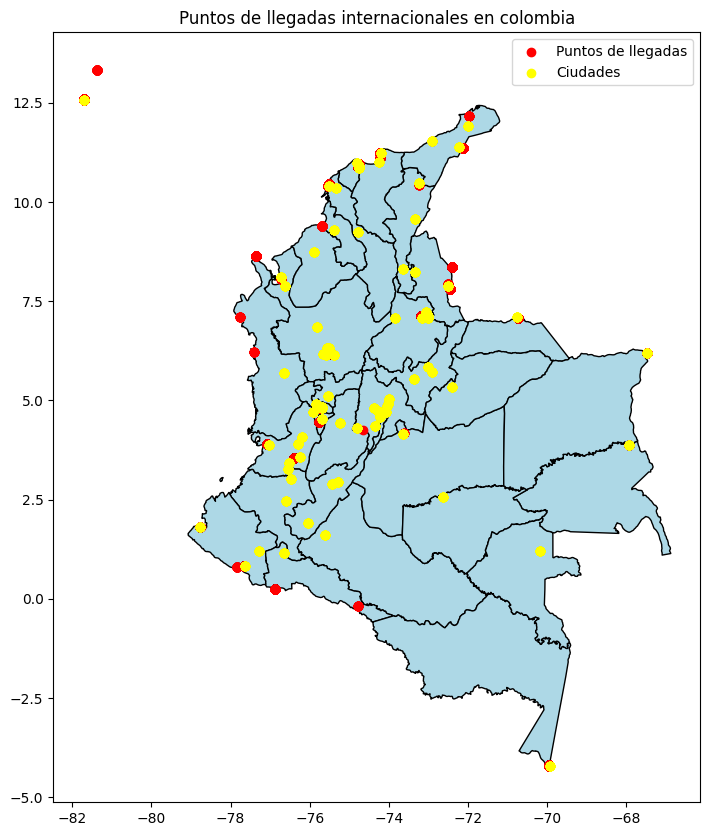

In [41]:

fig, ax = plt.subplots(figsize=(10, 10))

Departamentos.plot(ax=ax, color='lightblue', edgecolor='black', label='Municipios')
Entradas.plot(ax=ax, color='red', marker='o', label='Puntos de llegadas')
Total_18_Geometry.plot(ax=ax, color='yellow', marker='o', label='Ciudades')
plt.title('Puntos de llegadas internacionales en colombia')
plt.legend()
plt.show()

We grouped by department where the entry points are located so we could later connect it to the main city. This is useful since tourists arriving in a specific department are more likely to stay in that department.

In [43]:


if Entradas.crs is None:
    Entradas = Entradas.set_crs(Departamentos.crs, allow_override=True)

# We join each entry point to the nearest department
Entradas = gpd.sjoin_nearest(Entradas,  Departamentos, how='left', distance_col='distancia').drop(['index_right' , 'DPTO' , 'AREA' , 'PERIMETER' , 'HECTARES' ,'distancia'] , axis=1)
Entradas

C:\Users\alejo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\geopandas\array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


,Año,Mes,Nacionalidad,Codigo Iso 3166,Femenino,Masculino,Indefinido,Total,geometry,Departamento
72888,2018,1,Afganistán,4,0,1,NaN,1,POINT (-75.51643 10.44576),bolivar
72889,2018,1,Afganistán,4,1,0,NaN,1,POINT (-74.14052 4.69714),bogotadc
72890,2018,1,Albania,8,1,1,NaN,2,POINT (-75.51643 10.44576),bolivar
72891,2018,1,Albania,8,1,8,NaN,9,POINT (-74.14052 4.69714),bogotadc
72892,2018,1,Albania,8,0,1,NaN,1,POINT (-75.42745 6.1716),antioquia
...,...,...,...,...,...,...,...,...,...,...
86342,2018,12,Desconocido,99999,1,0,NaN,1,POINT (-75.73653 4.81506),risaralda
86343,2018,12,Desconocido,99999,0,5,NaN,5,POINT (-75.42745 6.1716),antioquia
86344,2018,12,Desconocido,99999,2,0,NaN,2,POINT (-70.74025 7.08873),arauca
86345,2018,12,Desconocido,99999,0,1,NaN,1,POINT (-72.4094 8.36068),nortedesantander


### Add to leave departmentally how many entries of people there are

In [47]:

Entradas_Departamentos = Entradas.groupby(['Mes', 'Departamento'])['Total'].sum().reset_index()
Entradas_Departamentos

,Mes,Departamento,Total
0,1,amazonas,883
1,1,antioquia,25339
2,1,arauca,1004
3,1,archipielagodesanandresprovidenciaysantacatalina,3221
4,1,atlantico,3142
...,...,...,...
238,12,risaralda,1599
239,12,santander,390
240,12,sucre,18
241,12,valledelcauca,12384


Enter how many foreigners enter each city, grouping them by department. Basically, we're saying that everyone in the department of Antioquia has tickets from Medellin.
Because of what we've already said, a foreigner arriving in Medellin will most likely prefer to travel through Antioquia rather than go all the way to Leticia.

In [57]:

final = pd.merge(fusion_left, Entradas_Departamentos, on=['Departamento', 'Mes'], how='left').rename(columns={'Total': 'Entradas Extranjeros Zona'})
final['Entradas Extranjeros Zona'] = final['Entradas Extranjeros Zona'].fillna(0) 
final

,Ciudad,Mes,Extranjeros no Residentes,Homicidios,Hurtos,Delitos Sexuales,geometry,Departamento,Temperatura,Dolar,Pib Ponderado,Entradas Extranjeros Zona
0,pitalito,1,33.0,2,61,15,POINT (384119.441 209921.192),huila,18.055550,2855.86,151.999238,0.0
1,riohacha,1,108.0,4,49,8,POINT (728275.629 1276987.69),laguajira,26.700000,2855.86,245.473018,18243.0
2,rionegro,1,271.0,2,51,7,POINT (458587.876 680187.339),antioquia,15.500000,2855.86,343.717029,25339.0
3,bogota,1,99767.0,83,7149,426,POINT (602898.9 520798.299),bogotadc,12.600000,2855.86,23953.819812,167632.0
4,piedecuesta,1,28.0,1,66,13,POINT (720906.443 783432.99),santander,22.523648,2855.86,258.755835,237.0
...,...,...,...,...,...,...,...,...,...,...,...,...
967,aguachica,12,14.0,2,28,4,POINT (650504.481 919569.475),cesar,27.550000,3198.45,73.597907,0.0
968,sanjosedelguaviare,12,8.0,1,12,11,POINT (763167.066 283942.885),guaviare,21.841149,3198.45,38.317074,0.0
969,palermo,12,1.0,0,8,0,POINT (451378.305 319631.823),huila,21.841149,3198.45,48.387369,0.0
970,mitu,12,0.0,0,0,4,POINT (1037614.182 132922.769),vaupes,21.841149,3198.45,14.093870,0.0


### We filtered the final city of Medellin to see how the base is looking.

In [58]:

final[final['Ciudad'] == 'medellin']

,Ciudad,Mes,Extranjeros no Residentes,Homicidios,Hurtos,Delitos Sexuales,geometry,Departamento,Temperatura,Dolar,Pib Ponderado,Entradas Extranjeros Zona
40,medellin,1,28735.0,56,1398,187,POINT (434665.511 688754.358),antioquia,19.20,2855.86,6081.597689,25339.0
121,medellin,2,29947.0,40,1524,190,POINT (434665.511 688754.358),antioquia,20.30,2853.16,5612.881290,26835.0
202,medellin,3,30756.0,42,1586,151,POINT (434665.511 688754.358),antioquia,20.20,2852.48,5422.546922,27275.0
283,medellin,4,27790.0,57,1885,192,POINT (434665.511 688754.358),antioquia,19.20,2780.47,5347.095975,26060.0
364,medellin,5,26950.0,64,1934,209,POINT (434665.511 688754.358),antioquia,19.20,2863.12,5232.296501,25362.0
445,medellin,6,28093.0,66,1880,181,POINT (434665.511 688754.358),antioquia,20.30,2889.69,5239.325647,25817.0
526,medellin,7,31563.0,54,1816,189,POINT (434665.511 688754.358),antioquia,20.20,2881.09,5356.525786,28542.0
607,medellin,8,35060.0,52,2343,209,POINT (434665.511 688754.358),antioquia,20.50,2958.45,5318.876680,30122.0
688,medellin,9,27355.0,42,1935,194,POINT (434665.511 688754.358),antioquia,19.80,3026.05,5297.392139,24549.0
769,medellin,10,26387.0,51,2016,218,POINT (434665.511 688754.358),antioquia,19.10,3087.46,5314.969890,22987.0


## Distances from entry points

Another key determinant of tourist inflows is a city’s proximity to international entry points—airports, seaports, and major border crossings. Cities located closer to these gateways benefit from shorter onward travel times, lower transfer costs, and greater flight frequencies, all of which reduce friction for international visitors. Moreover, well-connected hubs often attract more direct routes, making them visible on airline schedules and marketing platforms. Beyond mere distance, the quality of ground transportation—efficient rail links, shuttle services, and reliable road networks—amplifies this effect, transforming a nearby airport into a genuine tourism catalyst. By weighting our GDP approximation with each city’s accessibility score, we can capture how ease of international arrival shapes both economic activity and visitor patterns.  


In [60]:

from geopy.distance import geodesic

for i in ciudades['Ciudad']:
    indice = ciudades[ciudades['Ciudad'] == i].index
    if i not in grandes_ciudades:
        ciudades_unico = ciudades.drop(index=indice)
    else:
        pass

ciudades_unico = ciudades_unico.iloc[:, [0, -1]]
ciudades_unico= gpd.GeoDataFrame(ciudades_unico, geometry='geometry')
Migracion_Unico = entradas_2018.groupby('Latitud - Longitud')['Total'].sum().reset_index().iloc[:-1, :]
Migracion_Unico = convertir_ubicacion(Migracion_Unico , 'Latitud - Longitud')
Migracion_Unico = gpd.GeoDataFrame(Migracion_Unico, geometry='geometry')
Migracion_Unico # These are all the international single points of arrival

,Total,geometry
0,99,POINT (-74.78487 -0.19318)
1,5362,POINT (-69.94128 -4.1977)
2,3149,POINT (-69.9451 -4.22347)
3,6918,POINT (-76.87596 0.25129)
4,428,POINT (-77.84701 0.81244)
5,155051,POINT (-77.66253 0.81484)
6,9,POINT (-78.75153 1.81236)
7,923,POINT (-78.76392 1.81393)
8,32401,POINT (-75.538 10.40858)
9,85,POINT (-73.24786 10.43361)


###  Change the crs of both bases to measure the distances correctly

In [61]:

if ciudades_unico.crs is None:
    ciudades_unico.set_crs(epsg=4326, inplace=True)
else:
    print(f"CRS de ciudades_unico: {ciudades_unico.crs}")

if Migracion_Unico.crs is None:
    Migracion_Unico.set_crs(epsg=4326, inplace=True)
else:
    print(f"CRS de Migracion_Unico: {Migracion_Unico.crs}")


ciudades_unico = ciudades_unico.to_crs(epsg=32618)
Migracion_Unico = Migracion_Unico.to_crs(epsg=32618)

By weighting each city’s distance to an entry point by that gateway’s annual tourist arrivals, we capture not just geographic proximity but the true pull of each hub. An airport like El Dorado in Bogotá handles millions of international passengers every year, making its surrounding region a natural magnet for tourism-related business, services, and investment. In contrast, a smaller airport such as Leticia—though technically closer to the Amazon region—welcomes far fewer visitors. If we treated both airports equally, we’d overestimate the economic importance of proximity to Leticia and underestimate the advantage of being near El Dorado.

Concretely, we assign each entry point a weight equal to its annual arrival volume, then multiply that weight by the inverse of the city’s distance to the airport. Cities near high-traffic hubs score especially high, reflecting both ease of access and the likelihood of spill-over economic activity. This approach allows our model to differentiate between “close but obscure” and “slightly farther but very busy,” ensuring that our GDP approximations and tourism forecasts account for the real-world dynamics of visitor flow rather than just raw miles.


In [62]:

ciudades_unico['key'] = 1
Migracion_Unico['key'] = 1

Distancia_combinado = pd.merge(ciudades_unico, Migracion_Unico, on='key', suffixes=('_ciudad', '_punto')).drop('key', axis=1)

Distancia_combinado['distancia_km'] = Distancia_combinado.apply(lambda x: x['geometry_punto'].distance(x['geometry_ciudad']) / 1000, axis=1) # Calcular la distancia 

Distancia_combinado['distancia_ponderada'] = Distancia_combinado['distancia_km'] * Distancia_combinado['Total'] # Ponderamos por el total de gente que llego ahi en 2018
Distancia_ponderado = Distancia_combinado.groupby('Ciudad').agg(
    suma_ponderada=('distancia_ponderada', 'sum'),
    suma_migrantes=('Total', 'sum')
).reset_index()

Distancia_ponderado['distancia_ponderada_km'] = Distancia_ponderado['suma_ponderada'] / Distancia_ponderado['suma_migrantes'] # Terminamosm de ponderar
Distancia_ponderado_final = Distancia_ponderado[['Ciudad' , 'distancia_ponderada_km']]

Distancia_ciudades = ciudades_unico.merge(Distancia_ponderado_final, on='Ciudad')
Distancia_ciudades

,Ciudad,geometry,key,distancia_ponderada_km
0,bogota,POINT (602898.9 520798.299),1,253.743407
1,medellin,POINT (434665.511 688754.358),1,324.226627
2,cali,POINT (330897.116 378217.634),1,467.958670
3,barranquilla,POINT (521642.463 1214140.036),1,572.916934
4,cartagena,POINT (445269.937 1149681.547),1,535.801937
...,...,...,...,...
78,leticia,POINT (1063012.099 -467914.527),1,1270.344040
79,lavirginia,POINT (407610.267 543514.039),1,347.732674
80,mitu,POINT (1037614.182 132922.769),1,756.517545
81,inirida,POINT (1287613.509 430529.596),1,791.794020


## We graph the weighed distances

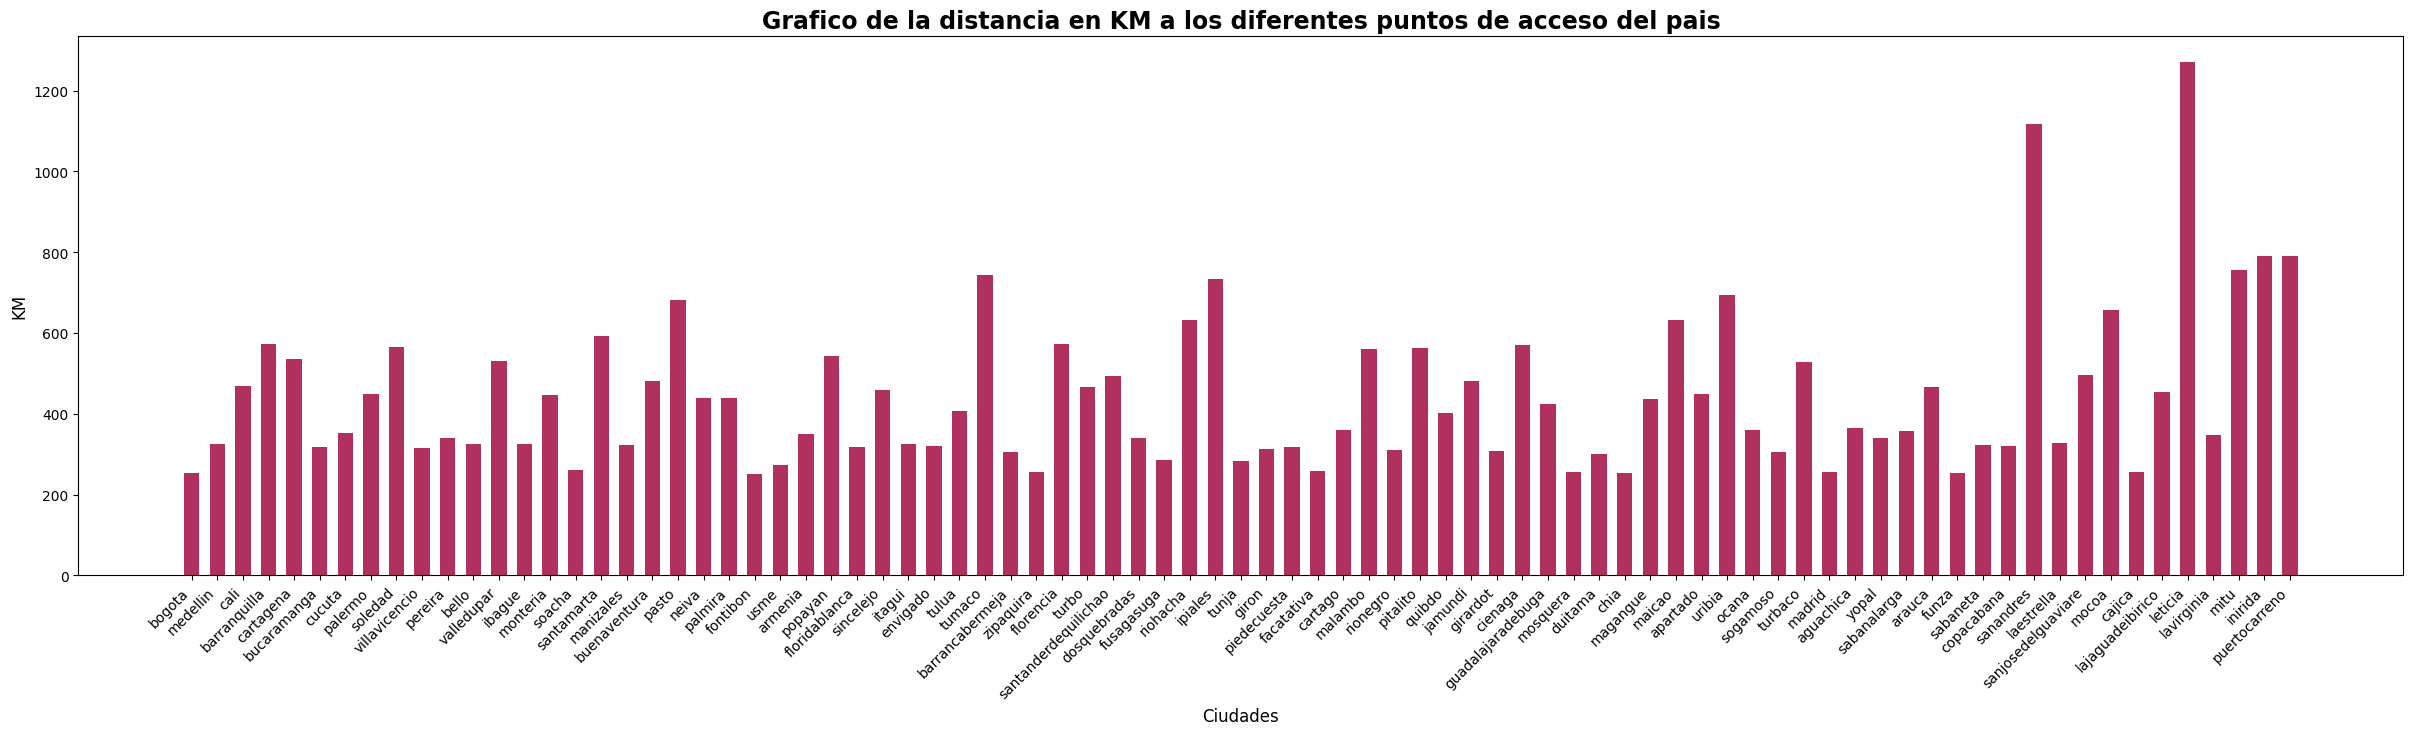

In [63]:

plt.figure(figsize=(30, 7))
plt.bar(Distancia_ciudades['Ciudad'], Distancia_ciudades['distancia_ponderada_km'], width=0.6 , color = '#B03060')
plt.title('Grafico de la distancia en KM a los diferentes puntos de acceso del pais' , fontsize=17, fontweight='bold')
plt.xlabel('Ciudades', fontsize=12)
plt.ylabel('KM', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.show()

### Join dataframe 

In [64]:

final1 = pd.merge(final, Distancia_ciudades, on='Ciudad', how='left').drop(['geometry_y' , 'key'] , axis=1)
final1

,Ciudad,Mes,Extranjeros no Residentes,Homicidios,Hurtos,Delitos Sexuales,geometry_x,Departamento,Temperatura,Dolar,Pib Ponderado,Entradas Extranjeros Zona,distancia_ponderada_km
0,pitalito,1,33.0,2,61,15,POINT (384119.441 209921.192),huila,18.055550,2855.86,151.999238,0.0,562.056999
1,riohacha,1,108.0,4,49,8,POINT (728275.629 1276987.69),laguajira,26.700000,2855.86,245.473018,18243.0,632.541270
2,rionegro,1,271.0,2,51,7,POINT (458587.876 680187.339),antioquia,15.500000,2855.86,343.717029,25339.0,309.633823
3,bogota,1,99767.0,83,7149,426,POINT (602898.9 520798.299),bogotadc,12.600000,2855.86,23953.819812,167632.0,253.743407
4,piedecuesta,1,28.0,1,66,13,POINT (720906.443 783432.99),santander,22.523648,2855.86,258.755835,237.0,317.092059
...,...,...,...,...,...,...,...,...,...,...,...,...,...
967,aguachica,12,14.0,2,28,4,POINT (650504.481 919569.475),cesar,27.550000,3198.45,73.597907,0.0,363.810283
968,sanjosedelguaviare,12,8.0,1,12,11,POINT (763167.066 283942.885),guaviare,21.841149,3198.45,38.317074,0.0,495.340765
969,palermo,12,1.0,0,8,0,POINT (451378.305 319631.823),huila,21.841149,3198.45,48.387369,0.0,449.021880
970,mitu,12,0.0,0,0,4,POINT (1037614.182 132922.769),vaupes,21.841149,3198.45,14.093870,0.0,756.517545


### We check again (The distance clearly should not vary depending on the month)

In [65]:

final1[final1['Ciudad'] == 'armenia']

,Ciudad,Mes,Extranjeros no Residentes,Homicidios,Hurtos,Delitos Sexuales,geometry_x,Departamento,Temperatura,Dolar,Pib Ponderado,Entradas Extranjeros Zona,distancia_ponderada_km
15,armenia,1,707.0,6,139,31,POINT (424566.064 500746.928),quindio,22.283069,2855.86,416.070435,284.0,349.945132
96,armenia,2,763.0,8,118,20,POINT (424566.064 500746.928),quindio,22.334702,2853.16,384.003362,351.0,349.945132
177,armenia,3,829.0,11,106,24,POINT (424566.064 500746.928),quindio,22.532732,2852.48,370.981701,412.0,349.945132
258,armenia,4,609.0,6,123,17,POINT (424566.064 500746.928),quindio,19.700000,2780.47,365.819750,316.0,349.945132
339,armenia,5,756.0,7,164,24,POINT (424566.064 500746.928),quindio,19.900000,2863.12,357.965783,481.0,349.945132
420,armenia,6,1040.0,4,139,17,POINT (424566.064 500746.928),quindio,20.900000,2889.69,358.446680,631.0,349.945132
501,armenia,7,1174.0,9,129,23,POINT (424566.064 500746.928),quindio,20.700000,2881.09,366.464888,664.0,349.945132
582,armenia,8,1303.0,8,140,11,POINT (424566.064 500746.928),quindio,22.500000,2958.45,363.889137,601.0,349.945132
663,armenia,9,829.0,8,137,23,POINT (424566.064 500746.928),quindio,22.811022,3026.05,362.419279,417.0,349.945132
744,armenia,10,655.0,5,150,12,POINT (424566.064 500746.928),quindio,21.741970,3087.46,363.621855,367.0,349.945132


## Score for the number of international entries per department

For this variable, we first aggregate the total number of international entry points (airports, seaports, and border crossings) within each department. Next, we weight each entry point by its annual passenger volume to reflect how busy—and therefore how influential—each gateway truly is. By combining these two steps, we derive a composite “accessibility score” that captures both the breadth of international connections and their real-world usage.

This final score serves as a proxy for the economic and tourism pull of each region: departments with many entry points will score higher, but those with fewer hubs can still rank highly if their gateways handle large volumes of traffic. When we assign this score to each city—based on its departmental affiliation—we create a metric that predicts which locations are most likely to benefit from inbound travelers. We expect that cities with higher accessibility scores will consistently attract more visitors, supporting more robust tourism-related revenue and GDP activity.  


In [66]:

from sklearn.preprocessing import MinMaxScaler

# We do the gropby again and using a sjoin nearest, we are going to add each department 
Migracion_Unico = entradas_2018.groupby('Latitud - Longitud')['Total'].sum().reset_index().iloc[:-1, :]
Migracion_Unico = convertir_ubicacion(Migracion_Unico , 'Latitud - Longitud')
Migracion_Unico = gpd.GeoDataFrame(Migracion_Unico, geometry='geometry')
columnas = ['geometry' , 'Departamento' ,'Total' ]
Migracion_Unico_Dept = gpd.sjoin_nearest(Migracion_Unico, Departamentos, how='left', distance_col='distancia')[columnas]
Total_Migracion = Migracion_Unico_Dept.groupby('Departamento').agg(
    puntos=('Departamento', 'size'),  
    total_personas=('Total', 'sum')).reset_index()

scaler = MinMaxScaler()
Total_Migracion[['puntos_norm', 'total_norm']] = scaler.fit_transform(Total_Migracion[['puntos', 'total_personas']])
Total_Migracion['importancia accesos'] = 0.2 * Total_Migracion['puntos_norm'] + 0.8 * Total_Migracion['total_norm'] # We assume that it is more important how many people arrive than how many points there are.
Total_Migracion

C:\Users\alejo\AppData\Local\Temp\ipykernel_11896\2146114689.py:11: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  Migracion_Unico_Dept = gpd.sjoin_nearest(Migracion_Unico, Departamentos, how='left', distance_col='distancia')[columnas]
C:\Users\alejo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\geopandas\array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


,Departamento,puntos,total_personas,puntos_norm,total_norm,importancia accesos
0,amazonas,2,8511,0.333333,0.004314,0.070118
1,antioquia,3,322965,0.666667,0.163798,0.264372
2,arauca,1,25217,0.000000,0.012786,0.010229
3,archipielagodesanandresprovidenciaysantacatalina,3,33639,0.666667,0.017058,0.146980
4,atlantico,1,47020,0.000000,0.023845,0.019076
5,bogotadc,1,1971697,0.000000,1.000000,0.800000
6,bolivar,2,369403,0.333333,0.187350,0.216547
7,cesar,1,85,0.000000,0.000040,0.000032
8,choco,3,3229,0.666667,0.001635,0.134641
9,cundinamarca,1,6,0.000000,0.000000,0.000000


### We join the df that we have been working on

In [67]:

final1 = pd.merge(final1, Total_Migracion, on='Departamento', how='left').drop(['puntos' , 'total_personas' , 'puntos_norm' , 'total_norm'] , axis=1)
final1['importancia accesos'] = final1['importancia accesos'].fillna(0)

### We verify that the distances are the same for a specific city in each month

In [68]:

final1[final1['Ciudad'] == 'medellin']

,Ciudad,Mes,Extranjeros no Residentes,Homicidios,Hurtos,Delitos Sexuales,geometry_x,Departamento,Temperatura,Dolar,Pib Ponderado,Entradas Extranjeros Zona,distancia_ponderada_km,importancia accesos
40,medellin,1,28735.0,56,1398,187,POINT (434665.511 688754.358),antioquia,19.20,2855.86,6081.597689,25339.0,324.226627,0.264372
121,medellin,2,29947.0,40,1524,190,POINT (434665.511 688754.358),antioquia,20.30,2853.16,5612.881290,26835.0,324.226627,0.264372
202,medellin,3,30756.0,42,1586,151,POINT (434665.511 688754.358),antioquia,20.20,2852.48,5422.546922,27275.0,324.226627,0.264372
283,medellin,4,27790.0,57,1885,192,POINT (434665.511 688754.358),antioquia,19.20,2780.47,5347.095975,26060.0,324.226627,0.264372
364,medellin,5,26950.0,64,1934,209,POINT (434665.511 688754.358),antioquia,19.20,2863.12,5232.296501,25362.0,324.226627,0.264372
445,medellin,6,28093.0,66,1880,181,POINT (434665.511 688754.358),antioquia,20.30,2889.69,5239.325647,25817.0,324.226627,0.264372
526,medellin,7,31563.0,54,1816,189,POINT (434665.511 688754.358),antioquia,20.20,2881.09,5356.525786,28542.0,324.226627,0.264372
607,medellin,8,35060.0,52,2343,209,POINT (434665.511 688754.358),antioquia,20.50,2958.45,5318.876680,30122.0,324.226627,0.264372
688,medellin,9,27355.0,42,1935,194,POINT (434665.511 688754.358),antioquia,19.80,3026.05,5297.392139,24549.0,324.226627,0.264372
769,medellin,10,26387.0,51,2016,218,POINT (434665.511 688754.358),antioquia,19.10,3087.46,5314.969890,22987.0,324.226627,0.264372


## Number of tourist establishments, beds and rooms by month and city

In [69]:
# RNT database with which we can see how many tourism establishments there are per municipality
hoteles = pd.read_csv('C:\\Users\\alejo\\OneDrive\\Escritorio\\Universidaad\\Colab Notebooks\\Ia en economia\\Proyecto\\Hist_rico_Registro_Nacional_de_Turismo_-_RNT_20241007.csv')
hoteles

,AÑO,RNT,ESTADO,CATEGORIA,SUBCATEGORIA,NOMDEP,NOMBRE-MUNI,RAZON_SOCIAL,HABITACIONES,CAMAS,EMPLEADOS
0,2005,1,ACTIVO,AGENCIA DE VIAJES,AGENCIAS DE VIAJES Y DE TURISMO,BOGOTA,BOGOTA,VIAJES Y TURISMO DON QUIJOTE LTDA,0,0,6
1,2005,2,ACTIVO,AGENCIA DE VIAJES,AGENCIAS DE VIAJES Y DE TURISMO,SAN ANDRES Y PROVIDENCIA,SAN ANDRES,ISLATUR LALIANXA LIMITADA,0,0,10
2,2005,11,ACTIVO,AGENCIA DE VIAJES,AGENCIAS DE VIAJES Y DE TURISMO,BOGOTA,BOGOTA,TRAVEL CLUB SAS,0,0,300
3,2005,20,ACTIVO,OFICINAS DE REPRESENTACION TURISTICA,OFICINA DE REPRESENTACION TURISTICA,BOGOTA,BOGOTA,LUHRS BELTRAN LUBEL REPRESENTACIONES S.A.S,0,0,6
4,2005,26,ACTIVO,OFICINAS DE REPRESENTACION TURISTICA,OFICINA DE REPRESENTACION TURISTICA,BOGOTA,BOGOTA,PENTA REPRESENTACIONES LTDA,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
466467,2022,150034,ACTIVO,VIVIENDAS TURÍSTICAS,APARTAMENTO TURÍSTICO,ATLANTICO,BARRANQUILLA,HAROLD EDUARDO LOZADA RODRIGUEZ,1,1,0
466468,2022,150035,ACTIVO,VIVIENDAS TURÍSTICAS,APARTAMENTO TURÍSTICO,ATLANTICO,BARRANQUILLA,DANIEL FRANCISCO BERMEO PENAGOS,1,4,0
466469,2022,150036,ACTIVO,VIVIENDAS TURÍSTICAS,APARTAMENTO TURÍSTICO,ATLANTICO,BARRANQUILLA,HOSTY RENTALS S.A.S.,1,2,0
466470,2022,150037,ACTIVO,VIVIENDAS TURÍSTICAS,APARTAMENTO TURÍSTICO,ATLANTICO,BARRANQUILLA,HOSTY RENTALS S.A.S.,1,1,0


### Filter by 2018 and group to add how many establishments, beds and rooms there are per municipality

In [74]:

establecimientos_2018 = hoteles[hoteles['AÑO']==2018]
Establecimientos = establecimientos_2018.groupby('NOMBRE-MUNI').agg({'CATEGORIA': 'count','HABITACIONES': 'sum', 'CAMAS': 'sum'}).reset_index().rename(columns={'CATEGORIA': 'Establecimientos'})
Establecimientos = arreglar_texto(Establecimientos, 'NOMBRE-MUNI' , 'Municipios')
Establecimientos

La funcion demoro 0.0025055408477783203


,Municipios,Establecimientos,HABITACIONES,CAMAS
0,abejorral,4,50,61
1,acacias,89,1129,1816
2,acandi,57,578,1398
3,acevedo,3,5,20
4,agrado,1,4,6
...,...,...,...,...
711,zarzal,18,241,277
712,zetaquira,7,92,165
713,zipacon,1,9,22
714,zipaquira,80,514,733


### Filter the cities we are working on

In [75]:

for i in Establecimientos['Municipios']:
    indice = Establecimientos[Establecimientos['Municipios'] == i].index
    if i not in grandes_ciudades:
        Establecimientos = Establecimientos.drop(index=indice)
    else:
        pass

Establecimientos=Establecimientos.rename(columns={'Municipios': 'Ciudad'})
Establecimientos

,Ciudad,Establecimientos,HABITACIONES,CAMAS
6,aguachica,48,951,1392
29,apartado,74,1121,1521
36,arauca,39,629,893
45,armenia,383,3264,6064
54,barrancabermeja,109,1826,2523
...,...,...,...,...
665,uribia,29,307,621
674,valledupar,137,2104,3380
695,villavicencio,516,6780,11821
706,yopal,195,2868,3897


### Graphs for the infrastructure variable by city throughout the series

La funcion demoro 0.00501251220703125


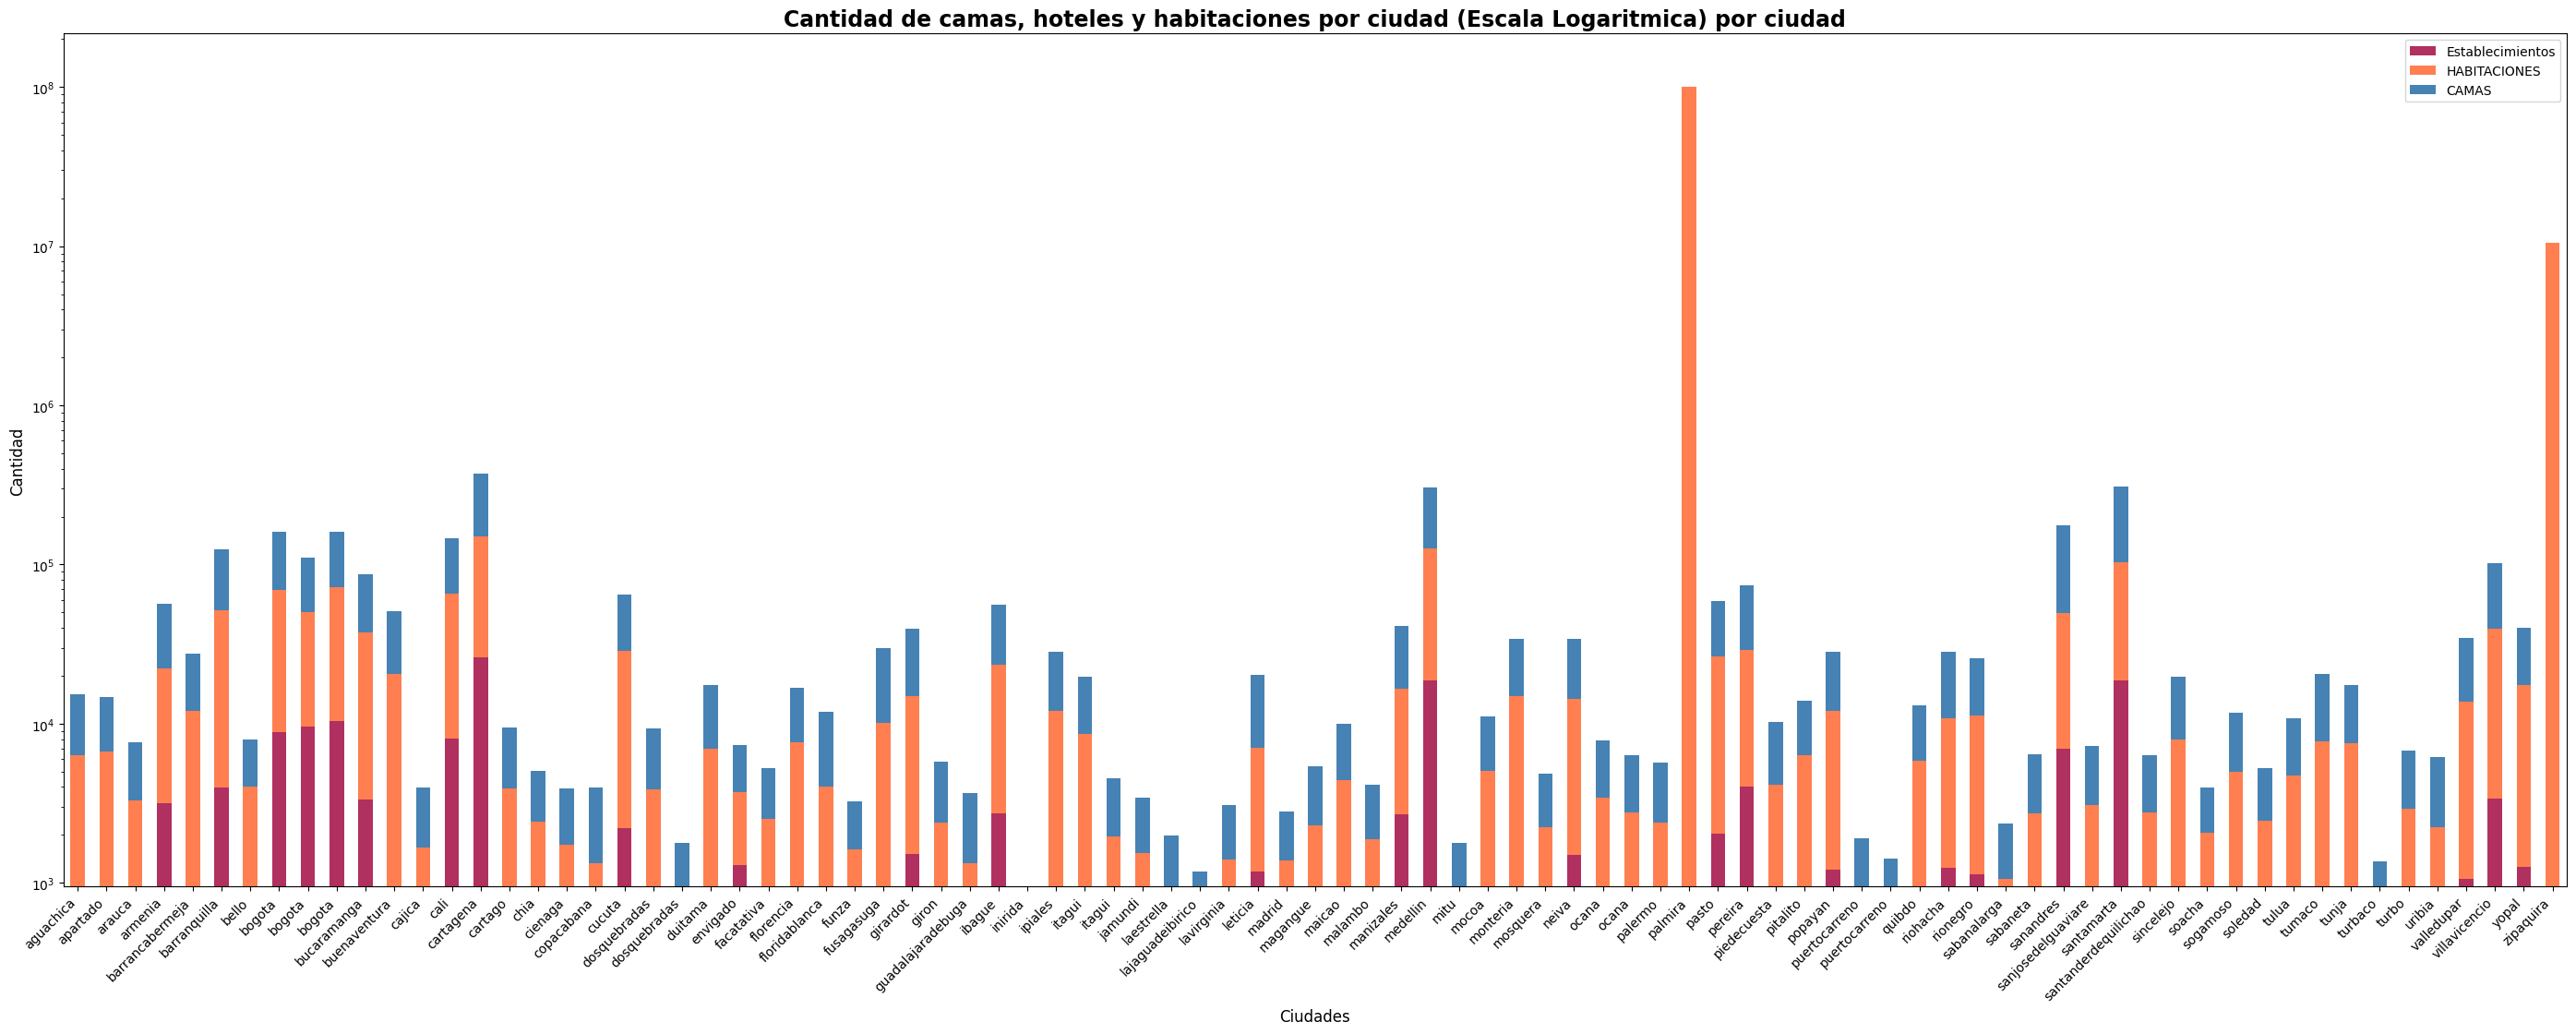

In [68]:
establecimientos_ = hoteles[hoteles['AÑO']>=2018] # Seleccionamos de 2018 hasta 2023
Establecimientos_ = establecimientos_.groupby('NOMBRE-MUNI').agg({'CATEGORIA': 'count','HABITACIONES': 'sum', 'CAMAS': 'sum'}).reset_index().rename(columns={'CATEGORIA': 'Establecimientos'})
Establecimientos_ = arreglar_texto(Establecimientos_, 'NOMBRE-MUNI' , 'Municipios')

for i in Establecimientos_['Municipios']:
    indice = Establecimientos_[Establecimientos_['Municipios'] == i].index
    if i not in grandes_ciudades:
        Establecimientos_ = Establecimientos_.drop(index=indice)
    else:
        pass
Establecimientos_ = Establecimientos_.set_index(Establecimientos_.columns[0])
color = ['#B03060', '#FF7F50', '#4682B4']

fig, ax = plt.subplots(figsize=(35, 12))
Establecimientos_.plot(kind='bar', ax=ax , color=color , stacked=True)
ax.set_title('Cantidad de camas, hoteles y habitaciones por ciudad (Escala Logaritmica) por ciudad', fontsize=17, fontweight='bold')
ax.set_xlabel('Ciudades', fontsize=12)
ax.set_ylabel('Cantidad', fontsize=12)
ax.set_yscale('log')
plt.xticks(rotation=45, ha='right')
plt.show()

### Graphs for the infrastructure variable by Department in the entire series (log scale)

La columna NOMBRE-MUNI no existe en el DataFrame
La funcion demoro 0.0


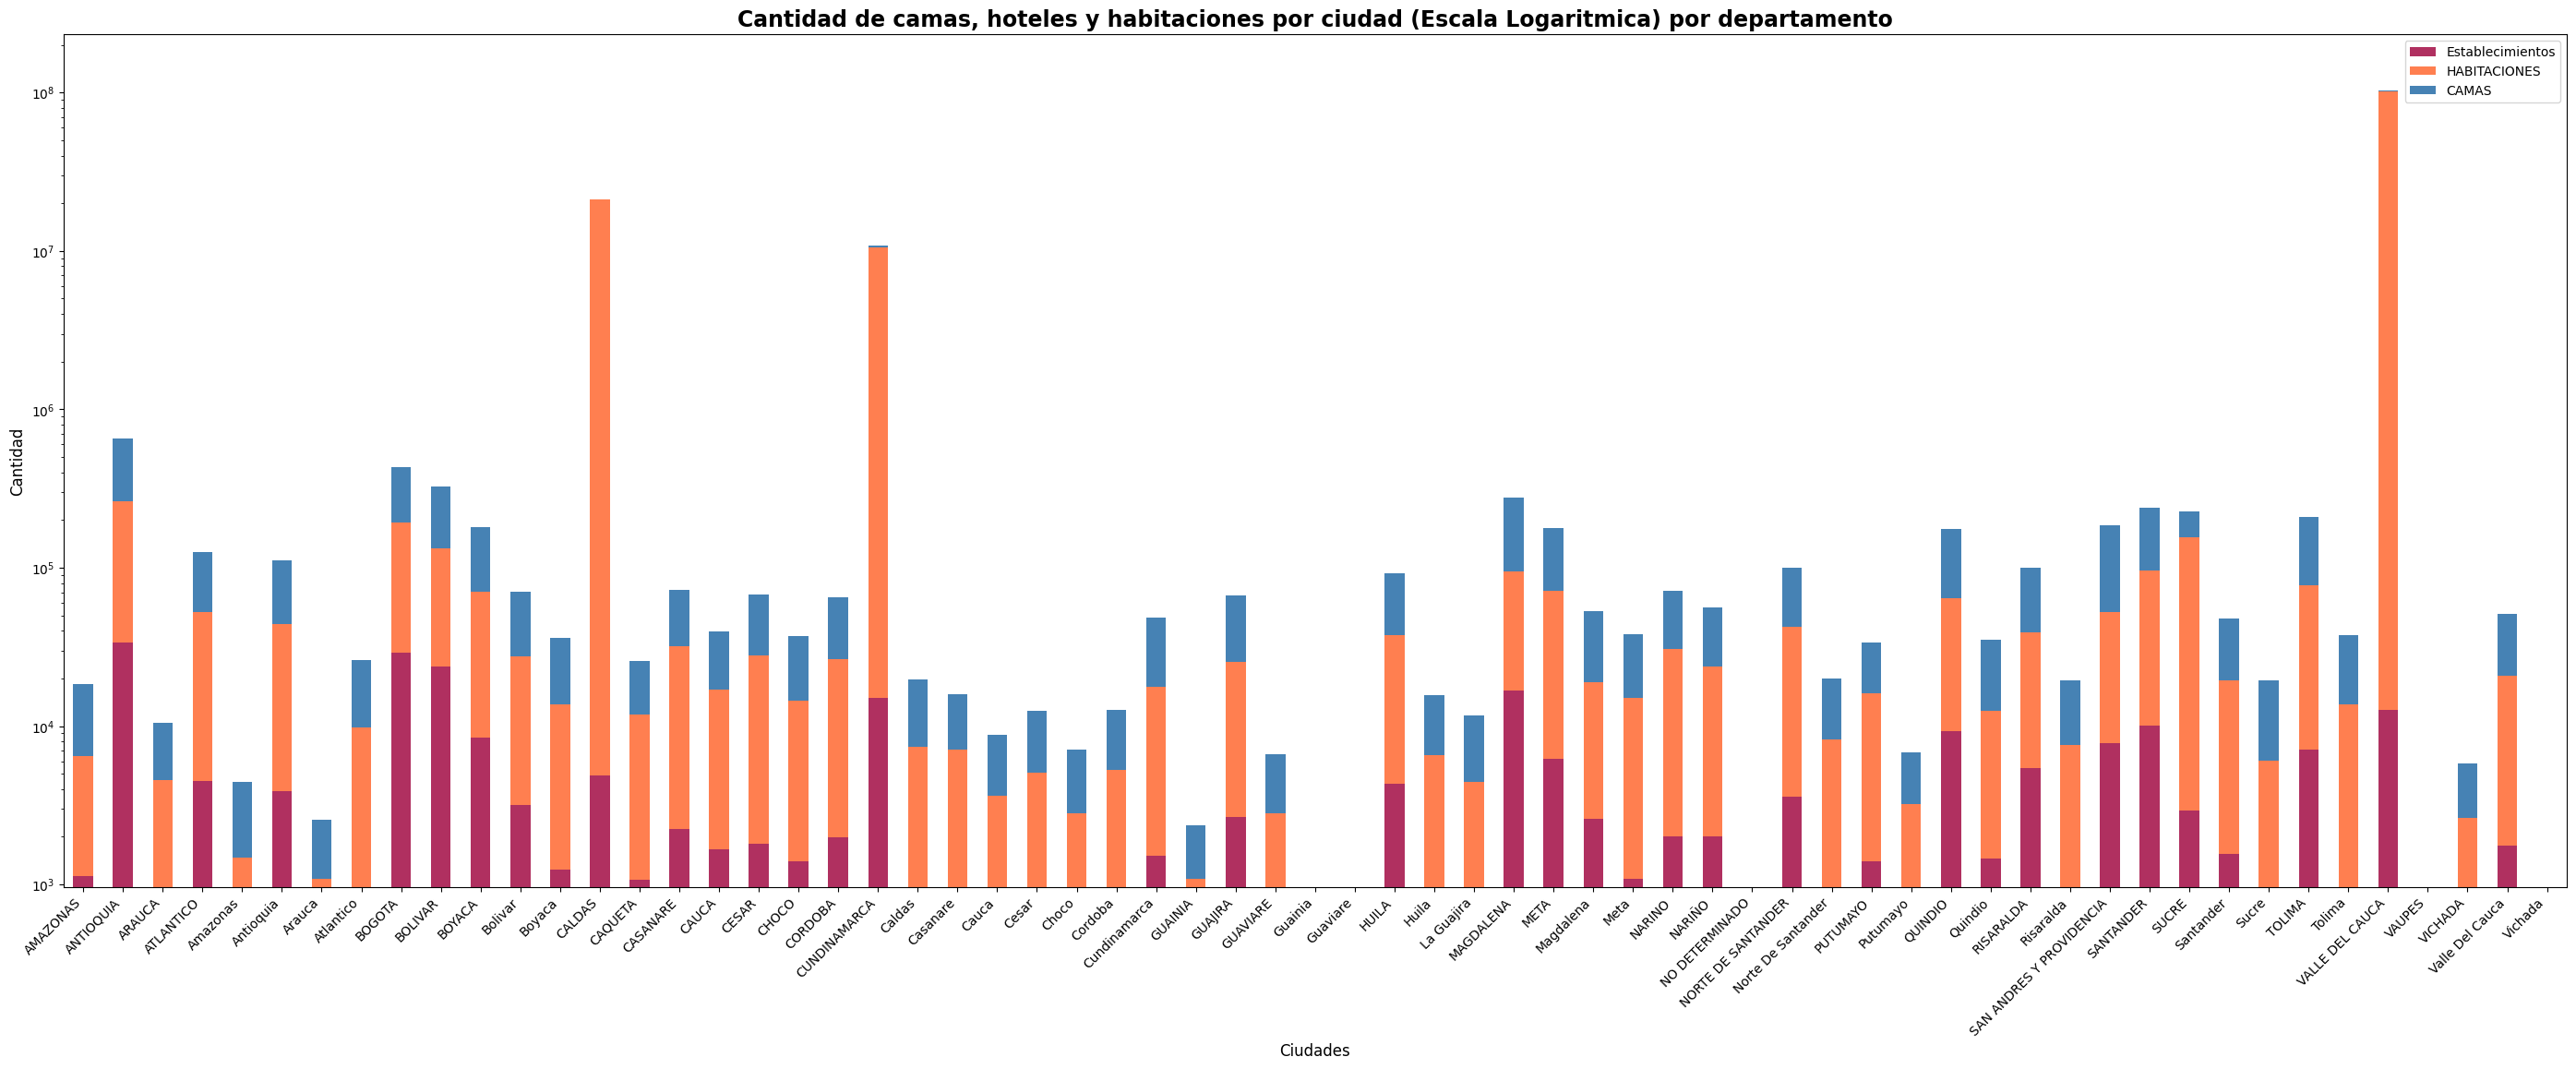

In [72]:
establecimientos_ = hoteles[hoteles['AÑO']>=2018]
Establecimientos_ = establecimientos_.groupby('NOMDEP').agg({'CATEGORIA': 'count','HABITACIONES': 'sum', 'CAMAS': 'sum'}).reset_index().rename(columns={'CATEGORIA': 'Establecimientos'})
Establecimientos_ = arreglar_texto(Establecimientos_, 'NOMBRE-MUNI' , 'Municipios')

Establecimientos_ = Establecimientos_.set_index(Establecimientos_.columns[0])
color = ['#B03060', '#FF7F50', '#4682B4']

fig, ax = plt.subplots(figsize=(35, 12))
Establecimientos_.plot(kind='bar', ax=ax , color=color , stacked=True)
ax.set_title('Cantidad de camas, hoteles y habitaciones por ciudad (Escala Logaritmica) por departamento', fontsize=17, fontweight='bold')
ax.set_xlabel('Ciudades', fontsize=12)
ax.set_ylabel('Cantidad', fontsize=12)
ax.set_yscale('log')
plt.xticks(rotation=45, ha='right')
plt.show()

## Monthly Interpolation of Establishment Counts

Because we apply LOESS smoothing on a year-by-year basis, this component can exhibit substantial variation from one calendar year to the next. To reconstruct a smooth monthly series of business establishments, we rely on the Ministry of Tourism’s published monthly profiles—each department’s seasonal patterns are illustrated in the provided chart images.

By fitting a separate LOESS curve for each year, we capture the unique monthly rhythm of openings and closures implied by the official Ministry data. This approach accommodates shifts in the tourism cycle—such as peak-season surges or off-season slowdowns—without forcing a single trend across multiple years. When you review the full “base final” script, you’ll see that the monthly growth and contraction patterns directly mirror the Ministry’s graphs (stored in the project folder), ensuring our interpolated estimates remain grounded in observed, sector-specific behavior.


In [76]:

meses_loees = np.arange(1, 13)
patron_estacional = np.array([1/12, 1/12, 1/12, 1/12, 1/12, 1/12, 1/12, 1/12, 1/12, 1/12, 1/12, 1/12]) 
patron_estacional = patron_estacional / patron_estacional.sum()

np.random.seed(42)
patron_ruido = patron_estacional + np.random.normal(0, 0.005, 12)
patron_ruido = np.clip(patron_ruido, 0.01, None) 
patron_ruido = patron_ruido / patron_ruido.sum()

loess_result = lowess(patron_ruido, meses_loees, frac=0.4)
meses_smooth = loess_result[:, 0]
patron_smooth = loess_result[:, 1]
patron_smooth = patron_smooth / patron_smooth.sum()

In [82]:
# Funcion para descomponer 
def descomponer_variables_loess(df_anual, patron, variables):
    def asignar_valores_mensuales(fila, patron, variables):
        valores_mensuales = {}
        for i in variables:
            valores_mensuales[i] = patron * fila[i]
        return valores_mensuales

    data_mensual = []
    for i, fila in df_anual.iterrows():
        valores_mensuales = asignar_valores_mensuales(fila, patron, variables)
        
        df_temp = pd.DataFrame({
            'Ciudad': fila['Ciudad'],
            'Mes': np.arange(1, 13)
        })
        
        for k in variables:
            df_temp[k] = valores_mensuales[k]
        
        data_mensual.append(df_temp)
    
    df_mensual = pd.concat(data_mensual, ignore_index=True)
    
    return df_mensual

# Aca podemos ver la descomposicon en los 12 meses de las 3 variables 
Establecimientos_mensual = descomponer_variables_loess(Establecimientos, patron_smooth , ['Establecimientos' , 'HABITACIONES' , 'CAMAS'])
Establecimientos_mensual

,Ciudad,Mes,Establecimientos,HABITACIONES,CAMAS
0,aguachica,1,4.011760,79.482999,116.341046
1,aguachica,2,3.999096,79.232087,115.973780
2,aguachica,3,4.092551,81.083662,118.683972
3,aguachica,4,4.104425,81.318926,119.028333
4,aguachica,5,3.994280,79.136663,115.834106
...,...,...,...,...,...
967,zipaquira,8,6.813641,43.777646,62.429989
968,zipaquira,9,6.633064,42.617436,60.775449
969,zipaquira,10,6.540713,42.024082,59.929285
970,zipaquira,11,6.485940,41.672162,59.427422


### Join to final df

In [80]:

final2 = pd.merge(final1, Establecimientos_mensual, on=['Ciudad', 'Mes'], how='left')
final2

,Ciudad,Mes,Extranjeros no Residentes,Homicidios,Hurtos,Delitos Sexuales,geometry_x,Departamento,Temperatura,Dolar,Pib Ponderado,Entradas Extranjeros Zona,distancia_ponderada_km,importancia accesos,Establecimientos,HABITACIONES,CAMAS
0,pitalito,1,33.0,2,61,15,POINT (384119.441 209921.192),huila,18.055550,2855.86,151.999238,0.0,562.056999,0.000000,5.766905,76.892070,96.700136
1,riohacha,1,108.0,4,49,8,POINT (728275.629 1276987.69),laguajira,26.700000,2855.86,245.473018,18243.0,632.541270,0.214119,13.706847,132.973135,238.281840
2,rionegro,1,271.0,2,51,7,POINT (458587.876 680187.339),antioquia,15.500000,2855.86,343.717029,25339.0,309.633823,0.264372,10.781606,140.077293,206.104180
3,bogota,1,99767.0,83,7149,426,POINT (602898.9 520798.299),bogotadc,12.600000,2855.86,23953.819812,167632.0,253.743407,0.800000,301.049171,2389.671820,3536.450187
4,piedecuesta,1,28.0,1,66,13,POINT (720906.443 783432.99),santander,22.523648,2855.86,258.755835,237.0,317.092059,0.001376,5.349014,55.663173,79.148685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
967,aguachica,12,14.0,2,28,4,POINT (650504.481 919569.475),cesar,27.550000,3198.45,73.597907,0.0,363.810283,0.000032,3.796793,75.223952,110.106983
968,sanjosedelguaviare,12,8.0,1,12,11,POINT (763167.066 283942.885),guaviare,21.841149,3198.45,38.317074,0.0,495.340765,0.000000,2.214796,23.729953,33.854733
969,palermo,12,1.0,0,8,0,POINT (451378.305 319631.823),huila,21.841149,3198.45,48.387369,0.0,449.021880,0.000000,1.265598,30.453440,42.476616
970,mitu,12,0.0,0,0,4,POINT (1037614.182 132922.769),vaupes,21.841149,3198.45,14.093870,0.0,756.517545,0.000000,0.870098,10.599379,10.994878


## Distance to tourist sites

### Based on the top destinations recommended by TripAdvisor and other travel sites, we built the following dictionary.  

- **First column:** Unique identifier for each location (e.g., “LandingPoint1,” “HistoricCenter,” etc.).  
- **Second column:** Total number of user reviews for that spot across both Google Maps and TripAdvisor—an indicator of popularity and foot traffic.  
- **Third column:** Combined average rating (on a 1–5 scale) from both platforms—capturing perceived quality and satisfaction.

By combining review volume and average score, we generate a composite “popularity index” for each point of interest. We then use this index to weight the geographic distances from each city: nearby locations with high popularity exert a stronger pull than closer but less-visited sites. In practice, each city’s distance to a given point is multiplied by that point’s normalized popularity index, so that the “effective distance” shrinks for landmarks that attract large crowds and high ratings. This method ensures our accessibility metric reflects not only how far a city is from a point of interest, but also how significant that destination truly is to potential visitors.  


In [81]:

Top_Colombia = {'Ciudad Amurallada' : [(10.423768016601226, -75.5502221481417) , 23267+1851 , 4.8] , 
                'Monserrate':[(4.606442657411985, -74.05488182882448) , 16061+10034 , 4.7],    
                'Museo Oro': [(4.601863737486862, -74.07206921955388) , 14606+43837 , 4.8], 
                'Museo Pablo Escobar':[(6.210940942225721, -75.55666610034157) , 4041+2460 , 3.8],
                'Castillo San Felipe': [(10.422674818711775, -75.53911007123797) , 13188+61752 , 4.7],
                'La Candelaria': [(4.596356204217971, -74.07036887708271), 4790+35201 , 4.6 ],
                'Museo Botero': [(4.596783977356232, -74.07317983196756) , 10511+21480 , 4.8],
                'Piedra Penol': [(6.224293398570674, -75.17846180492857) , 2537+3722 , 4.7],
                'Parque Tayrona':[(11.30661973931487, -74.06558444232788) , 6407+24124 , 4.7],
                'Ciudad Perdida': [(10.69977509707966, -74.21719016507225) , 2129+10293 , 4.5],
                'Johnny Cay': [(12.599844555163797, -81.68958552452854) , 6944+1193, 4.6 ],
                'Mina sal': [(5.064130673191533, -73.87412723129202) , 4946+10681 , 4.8],
                'Parque Explora': [(6.271873980048277, -75.56529352888349), 3290+6868 , 4.8],
                'Parque del cafe': [(4.540472412992844, -75.7704120656708) , 2260+64813 , 4.8],
                'Getsemani': [(10.420236347859726, -75.5457920284369) , 827+9890 , 4.7],
                'Laguna Guatavita': [(4.978042131016031, -73.77411934630805) , 1641+760 , 4.6],
                'Laguna Guatape': [(6.2625426509484585, -75.18889681059652) , 1667+1920 , 4.9],
                'Zoo Cali': [(3.4483110753559307, -76.5567835595829) , 2505+30375 , 4.7],
                'Jaime Duque':[(4.950933448804722, -73.96450197491808) , 608+5558 , 4.8],
                'Museo Antioquia':[(6.252582668979805, -75.56902381539014) , 2037+8372 , 4.7],
                'Bosque Palmas': [(4.642619785055463, -75.48545072059876) , 1999+6026 , 4.8],
                'santuario san pedro claver' : [(10.421942528179812, -75.55101547480216) , 2344+2868 , 4.7],
                'Santuario Las Lajas': [(0.8056145166329276, -77.58580465582233) , 868+10768 , 4.8],
                'Medellin MetroCable': [(6.293713286896887, -75.54049102937564) , 2505+6768 , 4.7],
                'Villa de leyva': [(5.636740186520528, -73.52642769258925) , 10523+2931 , 4.8],
                'Salento': [(4.637632624472757, -75.57107751600738) , 935+1391 , 4,7 ],
                'Islas Rosario': [(10.198113718483176, -75.75728109040843) , 1293+235 , 4.5],
                'Cano cristales' : [(2.2654672947309984, -73.7904893534562) , 442+303 , 4.9],
                'Cabo de la vela': [(12.19584280316732, -72.14670358044717) , 503 , 4.7],
                'Parque Nacional Natural El Cocuy' :[(6.366594015120004, -72.32930605910018) , 1468,4.8],
                'Jardin': [(5.599970208507919, -75.82197889439527) , 1923 , 4.7],
                'Canon guejar': [(3.34558725490291, -74.00251320801074) , 223 , 5],
                'Chingaza': [(4.736759401563025, -73.84183421964912) , 312+532 , 4.9],
                'Selva Amazonas': [(-1.9373373758415269, -70.09301207031643) , 88 , 4.5],
                'Rio miel': [(5.77684008762934, -74.68539501381262) , 42+33 , 4.2],
                'Cerros de Mavecure': [(3.8685506255477473, -67.90980077915421) , 47+122 , 4.7],
                'Desiero Tatacoa': [(3.233661252748834, -75.167678435162) , 844+2805 , 4.8],
                'Parque Uramba': [(4.009359201162415, -77.24025001985369) , 51+2034 , 4.7],
                'Naqui': [(5.711911987713407, -77.26317845045835) , 1239 , 4.6],
                'San Jose Guaviare':[(2.5680632175041964, -72.6400738137754) , 4312 , 4.8],
                'Cascada Fin del Mundo':[(1.1049043406387264, -76.61366052942371) , 138 , 4.8],}



In [83]:
# Creamos el data frame con el diccionario
df_TopColombia = pd.DataFrame.from_dict(Top_Colombia, orient='index', columns=['coordinates','Reviews', 'rating', 'eliminar'])
df_TopColombia = df_TopColombia.reset_index().rename(columns={'index': 'lugar'}).drop('eliminar' , axis=1)
df_TopColombia['geometry'] = df_TopColombia['coordinates'].apply(lambda x: Point(x[1], x[0]))
df_TopColombia_gdp = gpd.GeoDataFrame(df_TopColombia, geometry='geometry').drop('coordinates' , axis=1)
df_TopColombia_gdp.head(5)

,lugar,Reviews,rating,geometry
0,Ciudad Amurallada,25118,4.8,POINT (-75.55022 10.42377)
1,Monserrate,26095,4.7,POINT (-74.05488 4.60644)
2,Museo Oro,58443,4.8,POINT (-74.07207 4.60186)
3,Museo Pablo Escobar,6501,3.8,POINT (-75.55667 6.21094)
4,Castillo San Felipe,74940,4.7,POINT (-75.53911 10.42267)


### We show the cities we are analyzing and where the most recommended places are in different tourist spots for all of Colombia.

C:\Users\alejo\AppData\Local\Temp\ipykernel_11896\343253387.py:9: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


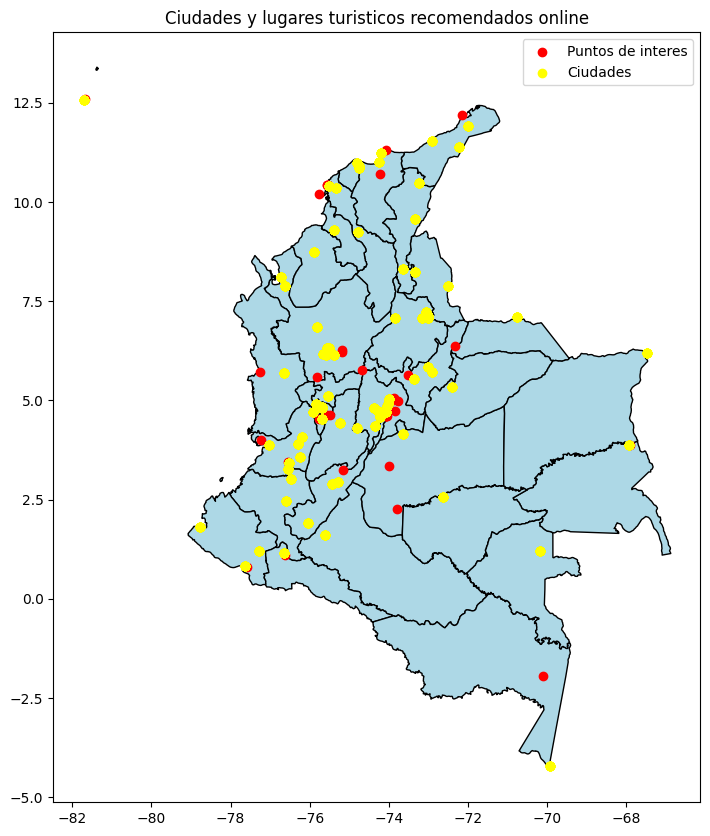

In [85]:


fig, ax = plt.subplots(figsize=(10, 10))

Departamentos.plot(ax=ax, color='lightblue', edgecolor='black', label='Municipios')
df_TopColombia_gdp .plot(ax=ax, color='red', marker='o', label='Puntos de interes')
Total_18_Geometry.plot(ax=ax, color='yellow', marker='o', label='Ciudades')
plt.title('Ciudades y lugares turisticos recomendados online')
plt.legend()
plt.show()

### Calculate the weighted distance from each city to the top recommended places

In [87]:

if ciudades_unico.crs is None:
    ciudades_unico.set_crs(epsg=4326, inplace=True)
else:
    print(f"CRS de ciudades_unico: {ciudades_unico.crs}")

if df_TopColombia_gdp.crs is None:
    df_TopColombia_gdp.set_crs(epsg=4326, inplace=True)
else:
    print(f"CRS de df_TopColombia_gdp: {df_TopColombia_gdp.crs}")


ciudades_unico = ciudades_unico.to_crs(epsg=32618)
df_TopColombia_gdp = df_TopColombia_gdp.to_crs(epsg=32618)

CRS de ciudades_unico: EPSG:32618
CRS de df_TopColombia_gdp: EPSG:32618


### Here we calculate the weighted distance, and since the variables have another scale we are going to normalize them to weight

In [88]:

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

ciudades_unico['key'] = 1
df_TopColombia_gdp['key'] = 1

Distancia_Top = pd.merge(ciudades_unico, df_TopColombia_gdp, on='key', suffixes=('_ciudad', '_punto')).drop('key', axis=1)

w_reviews = 0.6 # Let's assume that reviews carry more weight than the rating of the place 
w_rating = 0.4

Distancia_Top['distancia_km'] = Distancia_Top.apply(lambda x: x['geometry_punto'].distance(x['geometry_ciudad']) / 1000, axis=1) # Calculate the distance 

Distancia_Top[['distancia_km','Reviews', 'rating']] = scaler.fit_transform(
    Distancia_Top[['distancia_km','Reviews', 'rating']]
) # We normalize the variables to calculate a weighted distance with the same scales

Distancia_Top['distancia_ponderada'] = (Distancia_Top['distancia_km']) + ( w_reviews* Distancia_Top['Reviews']) + ( w_rating* Distancia_Top['rating']) # Weighted distance

# We group by city to know the total distance
Distancia_Ponderado_Top = Distancia_Top.groupby('Ciudad').agg(
    suma_ponderada=('distancia_ponderada', 'sum'),
    suma_reviews=('Reviews', 'sum'),
    suma_rating=('rating', 'sum')).reset_index()

# We finished pondering
Distancia_Ponderado_Top['distancia_ponderada_TOP'] = Distancia_Ponderado_Top['suma_ponderada'] / (Distancia_Ponderado_Top['suma_reviews']+Distancia_Ponderado_Top['suma_rating'])
Distancia_Ponderado_Top_final = Distancia_Ponderado_Top[['Ciudad' , 'distancia_ponderada_TOP']]

# We join the distances to the final df
Distancia_Top = ciudades_unico.merge(Distancia_Ponderado_Top_final, on='Ciudad')
Distancia_Top



,Ciudad,geometry,key,distancia_ponderada_TOP
0,bogota,POINT (602898.9 520798.299),1,0.604552
1,medellin,POINT (434665.511 688754.358),1,0.606369
2,cali,POINT (330897.116 378217.634),1,0.657344
3,barranquilla,POINT (521642.463 1214140.036),1,0.743269
4,cartagena,POINT (445269.937 1149681.547),1,0.718601
...,...,...,...,...
78,leticia,POINT (1063012.099 -467914.527),1,1.047374
79,lavirginia,POINT (407610.267 543514.039),1,0.611518
80,mitu,POINT (1037614.182 132922.769),1,0.818775
81,inirida,POINT (1287613.509 430529.596),1,0.854083


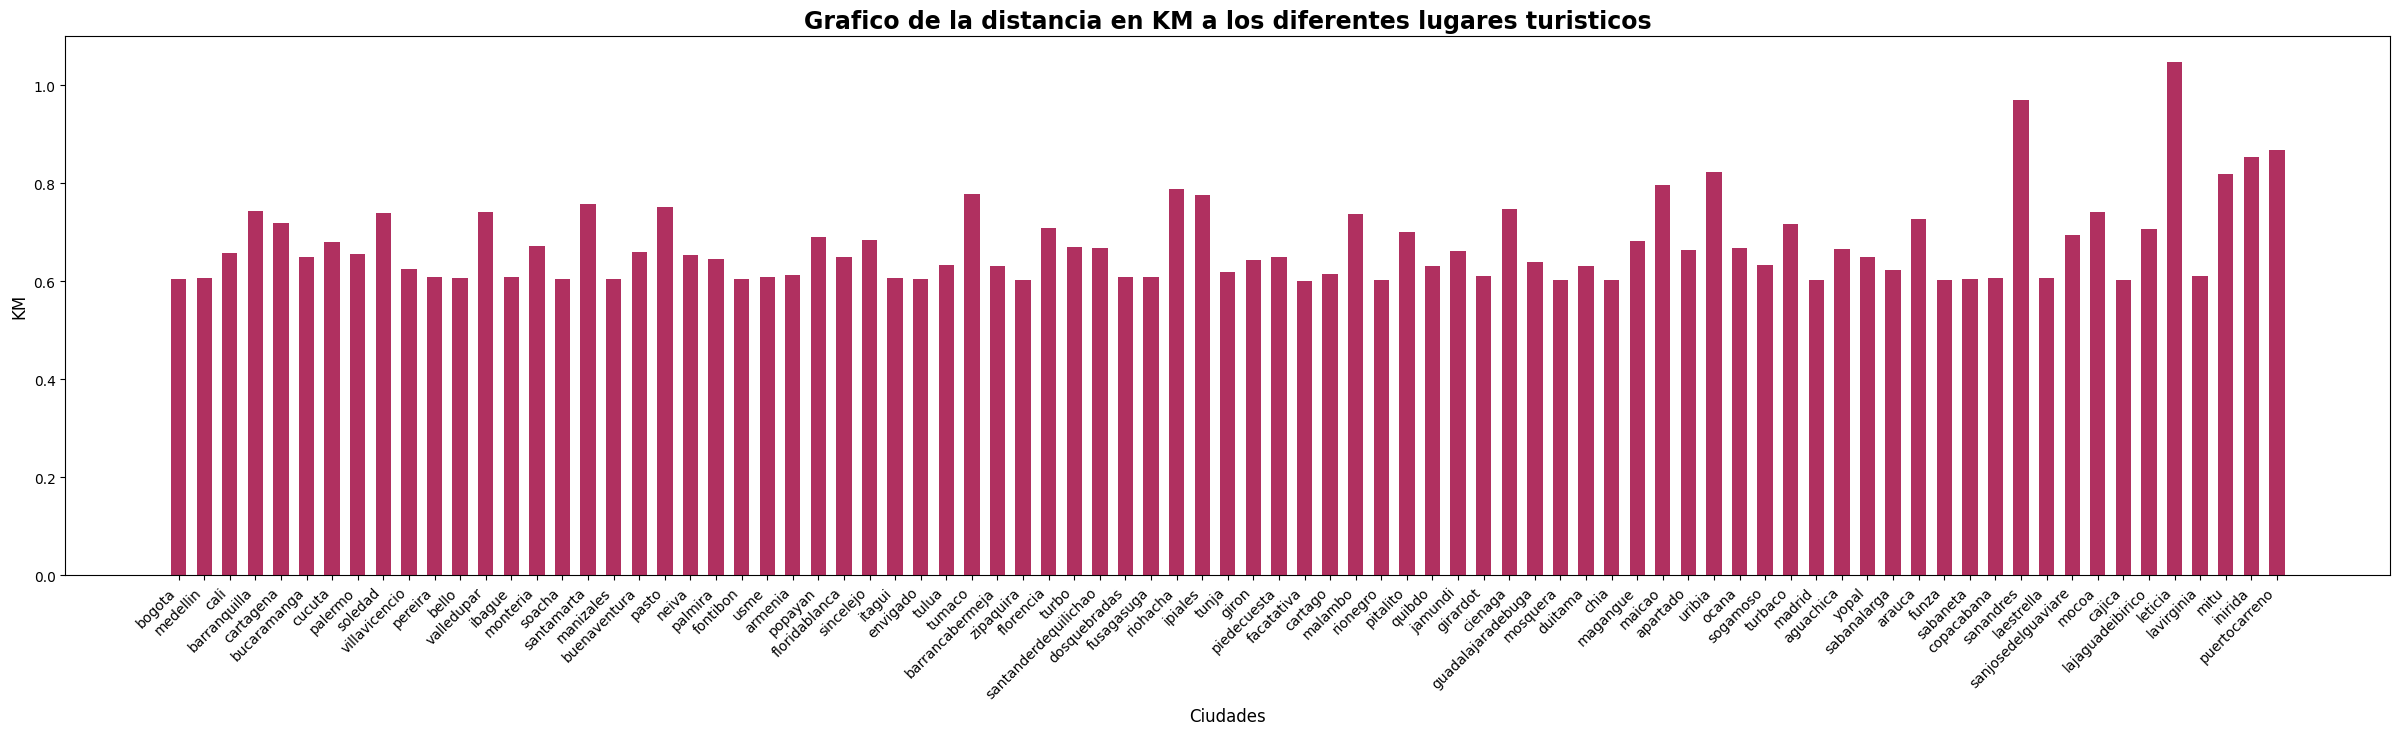

In [89]:

plt.figure(figsize=(30, 7))
plt.bar(Distancia_Top['Ciudad'], Distancia_Top['distancia_ponderada_TOP'], width=0.6 , color = '#B03060')
plt.title('Grafico de la distancia en KM a los diferentes lugares turisticos' , fontsize=17, fontweight='bold')
plt.xlabel('Ciudades', fontsize=12)
plt.ylabel('KM', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.show()

### Join with the Final DataFrame

In [90]:
final3 = pd.merge(final2, Distancia_Top, on='Ciudad', how='left').drop(['geometry_x' , 'key'] , axis=1)
final3

,Ciudad,Mes,Extranjeros no Residentes,Homicidios,Hurtos,Delitos Sexuales,Departamento,Temperatura,Dolar,Pib Ponderado,Entradas Extranjeros Zona,distancia_ponderada_km,importancia accesos,Establecimientos,HABITACIONES,CAMAS,geometry,distancia_ponderada_TOP
0,pitalito,1,33.0,2,61,15,huila,18.055550,2855.86,151.999238,0.0,562.056999,0.000000,5.766905,76.892070,96.700136,POINT (384119.441 209921.192),0.701330
1,riohacha,1,108.0,4,49,8,laguajira,26.700000,2855.86,245.473018,18243.0,632.541270,0.214119,13.706847,132.973135,238.281840,POINT (728275.629 1276987.69),0.788839
2,rionegro,1,271.0,2,51,7,antioquia,15.500000,2855.86,343.717029,25339.0,309.633823,0.264372,10.781606,140.077293,206.104180,POINT (458587.876 680187.339),0.603251
3,bogota,1,99767.0,83,7149,426,bogotadc,12.600000,2855.86,23953.819812,167632.0,253.743407,0.800000,301.049171,2389.671820,3536.450187,POINT (602898.9 520798.299),0.604552
4,piedecuesta,1,28.0,1,66,13,santander,22.523648,2855.86,258.755835,237.0,317.092059,0.001376,5.349014,55.663173,79.148685,POINT (720906.443 783432.99),0.649004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
967,aguachica,12,14.0,2,28,4,cesar,27.550000,3198.45,73.597907,0.0,363.810283,0.000032,3.796793,75.223952,110.106983,POINT (650504.481 919569.475),0.665383
968,sanjosedelguaviare,12,8.0,1,12,11,guaviare,21.841149,3198.45,38.317074,0.0,495.340765,0.000000,2.214796,23.729953,33.854733,POINT (763167.066 283942.885),0.694231
969,palermo,12,1.0,0,8,0,huila,21.841149,3198.45,48.387369,0.0,449.021880,0.000000,1.265598,30.453440,42.476616,POINT (451378.305 319631.823),0.655896
970,mitu,12,0.0,0,0,4,vaupes,21.841149,3198.45,14.093870,0.0,756.517545,0.000000,0.870098,10.599379,10.994878,POINT (1037614.182 132922.769),0.818775


## Poverty proxy = GDP/City population

To approximate poverty, we will use GDP per capita as a proxy. DANE provides total population projections,
so by dividing department-level GDP by population, we derive a per-person output measure.
We assume the population is constant at the most recent available date. This is reasonable—
for Bogotá, the population was 7,412,566 in 2018 and only about 7,907,000 in the latest count,
showing minimal change over this period.
Using a stable population figure simplifies our calculations and focuses the variation
on economic output rather than demographic shifts. A lower GDP per capita generally indicates
higher poverty levels, making this a suitable indicator when direct poverty measures are unavailable.

In [91]:

ciudades_poblacion = ciudades[['Ciudad' , 'population']] 
for i in ciudades_poblacion['Ciudad']:
    indice = ciudades_poblacion[ciudades_poblacion['Ciudad'] == i].index
    if i not in grandes_ciudades:
        ciudades_poblacion = ciudades_poblacion.drop(index=indice)
    else:
        pass

final4 = pd.merge(final3, ciudades_poblacion, on='Ciudad', how='left')
final4['Proxy_Pobreza'] = final4['Pib Ponderado'] / final4['population']
final4

,Ciudad,Mes,Extranjeros no Residentes,Homicidios,Hurtos,Delitos Sexuales,Departamento,Temperatura,Dolar,Pib Ponderado,Entradas Extranjeros Zona,distancia_ponderada_km,importancia accesos,Establecimientos,HABITACIONES,CAMAS,geometry,distancia_ponderada_TOP,population,Proxy_Pobreza
0,pitalito,1,33.0,2,61,15,huila,18.055550,2855.86,151.999238,0.0,562.056999,0.000000,5.766905,76.892070,96.700136,POINT (384119.441 209921.192),0.701330,133205,0.001141
1,riohacha,1,108.0,4,49,8,laguajira,26.700000,2855.86,245.473018,18243.0,632.541270,0.214119,13.706847,132.973135,238.281840,POINT (728275.629 1276987.69),0.788839,167865,0.001462
2,rionegro,1,271.0,2,51,7,antioquia,15.500000,2855.86,343.717029,25339.0,309.633823,0.264372,10.781606,140.077293,206.104180,POINT (458587.876 680187.339),0.603251,135465,0.002537
3,bogota,1,99767.0,83,7149,426,bogotadc,12.600000,2855.86,23953.819812,167632.0,253.743407,0.800000,301.049171,2389.671820,3536.450187,POINT (602898.9 520798.299),0.604552,7968095,0.003006
4,piedecuesta,1,28.0,1,66,13,santander,22.523648,2855.86,258.755835,237.0,317.092059,0.001376,5.349014,55.663173,79.148685,POINT (720906.443 783432.99),0.649004,150483,0.001720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
967,aguachica,12,14.0,2,28,4,cesar,27.550000,3198.45,73.597907,0.0,363.810283,0.000032,3.796793,75.223952,110.106983,POINT (650504.481 919569.475),0.665383,109621,0.000671
968,sanjosedelguaviare,12,8.0,1,12,11,guaviare,21.841149,3198.45,38.317074,0.0,495.340765,0.000000,2.214796,23.729953,33.854733,POINT (763167.066 283942.885),0.694231,68878,0.000556
969,palermo,12,1.0,0,8,0,huila,21.841149,3198.45,48.387369,0.0,449.021880,0.000000,1.265598,30.453440,42.476616,POINT (451378.305 319631.823),0.655896,800000,0.000060
970,mitu,12,0.0,0,0,4,vaupes,21.841149,3198.45,14.093870,0.0,756.517545,0.000000,0.870098,10.599379,10.994878,POINT (1037614.182 132922.769),0.818775,28382,0.000497


### Chart for poverty in the year

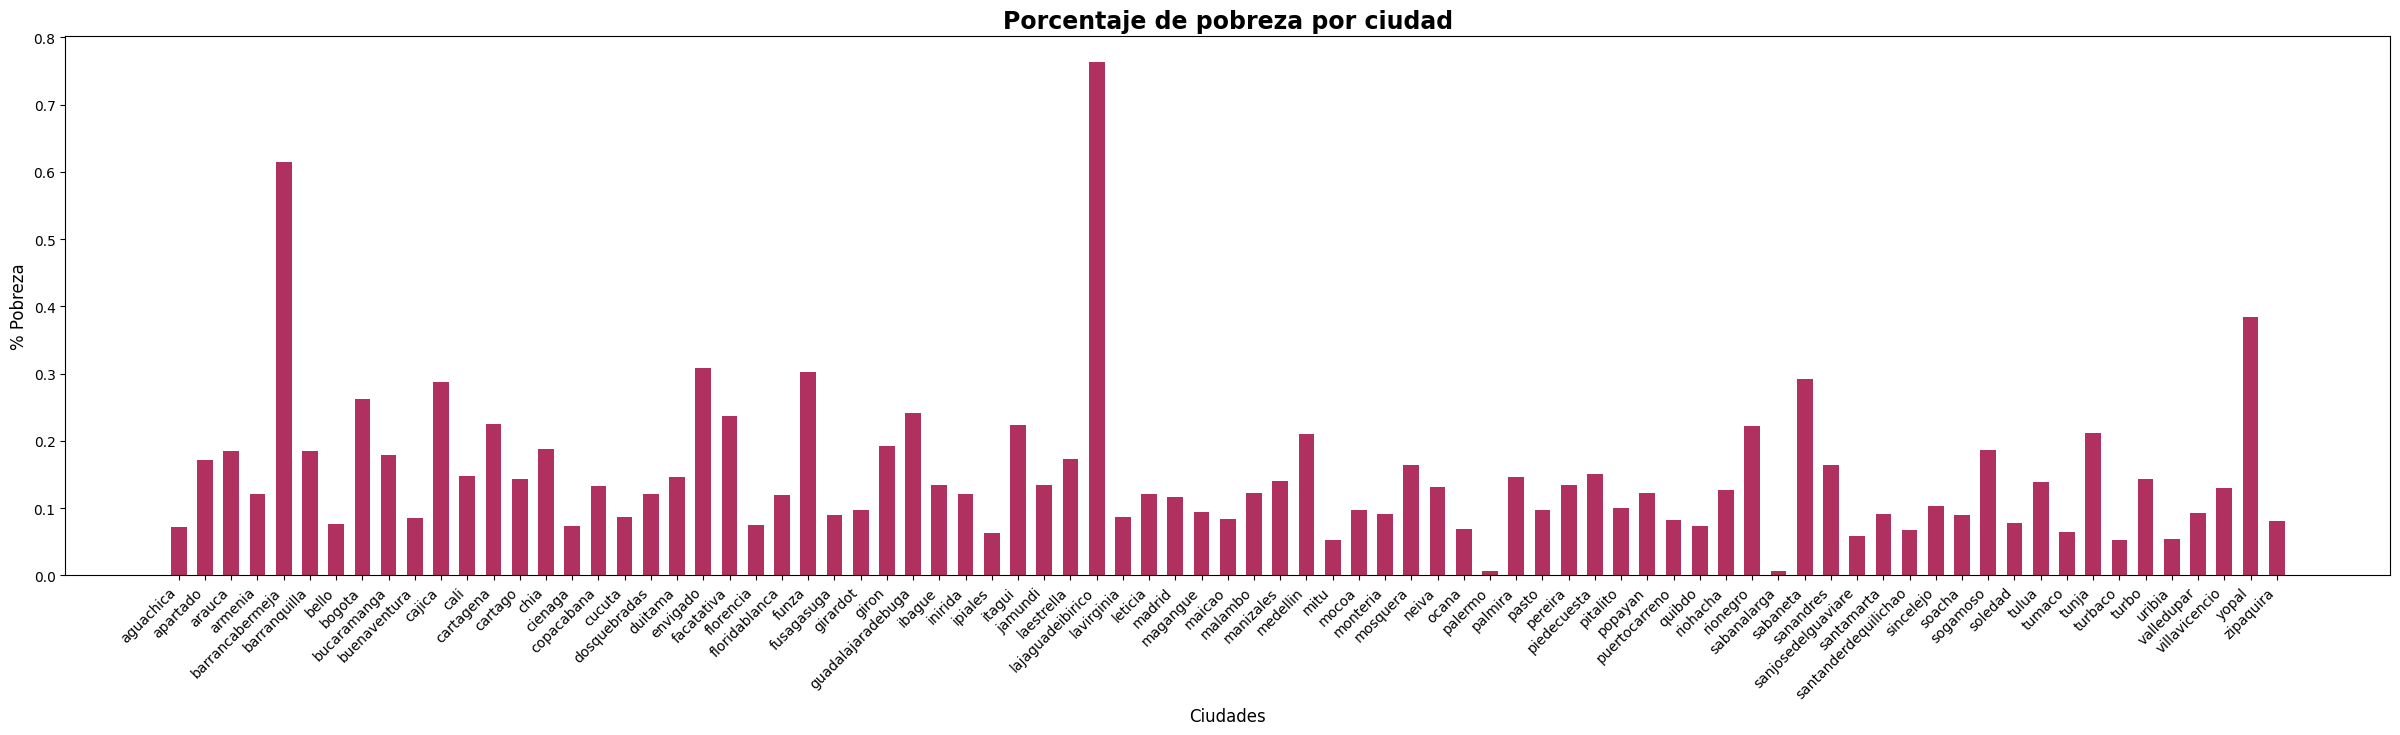

In [92]:
pobreza = final4.drop('geometry' , axis=1)
pobreza = pobreza.groupby('Ciudad')['Proxy_Pobreza'].median().reset_index()
pobreza['Proxy_Pobreza'] = pobreza['Proxy_Pobreza'] *100

plt.figure(figsize=(30, 7))
plt.bar(pobreza['Ciudad'], pobreza['Proxy_Pobreza'], width=0.6 , color = '#B03060')
plt.title('Porcentaje de pobreza por ciudad' , fontsize=17, fontweight='bold')
plt.xlabel('Ciudades', fontsize=12)
plt.ylabel('% Pobreza', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.show()

## Average daily expenditure on domestic tourism

In [102]:
# Here we import a database generated by DANE with the average expenses per department on a tourist trip day
gastos_diarios = pd.read_excel('C:\\Users\\alejo\\OneDrive\\Escritorio\\Universidaad\\Colab Notebooks\\Ia en economia\\Proyecto\\Gasto Promedio Diario 2019.xlsx')
gastos_diarios = arreglar_texto(gastos_diarios , 'Ciudad', 'Ciudad')

ciudades_geometry = Total_18_Geometry[['Ciudad' , 'geometry']].drop_duplicates()
gastos_diarios = pd.merge(gastos_diarios, ciudades_geometry, on='Ciudad', how='left')
gastos_diarios

# Since these figures are prices and were obtained by DANE from 2019, to approximately recover the 2018 figures, we will divide by 
# the inflation of each item in the base (annual average, # accommodation, transportation, food). With this, we hope to recover the average prices of the variables in 2018.

inflacion_2019_promedio = 3.80 / 100
inflacion_2019_aliemntos= 5.80 / 100
inflacion_2019_transporte= 3.41 /100
inflacion_2019_alojamiento = 3.46/100
# All these figures came from DANE's 2019 inflation report.

l2=[inflacion_2019_promedio, inflacion_2019_alojamiento,inflacion_2019_transporte,inflacion_2019_aliemntos,inflacion_2019_promedio]
c=-1
for i in gastos_diarios.iloc[: ,1:-1]:
    c=c+1
    gastos_diarios[i] = gastos_diarios[i] / (1+ l2[c])

gastos_diarios.head()

La funcion demoro 0.0010068416595458984


,Ciudad,Gasto Promedio Diario,Gasto Alojamiento Diario,Gasto Transporte Diario,Gasto alimetos Diario,Otros Gastos Diario,geometry
0,medellin,64129.097303,11737.716026,12482.592593,23988.551985,15543.375723,POINT (-75.5906 6.2308)
1,barranquilla,90564.332370,18675.173014,16895.620346,22969.130435,31706.494220,POINT (-74.8019 10.9833)
2,bogota,90802.287091,18932.685096,14867.760371,23000.094518,33676.461464,POINT (-74.0722 4.7111)
3,cartagena,61669.721580,8150.613764,12384.036360,15474.235350,25435.907514,POINT (-75.5 10.4)
4,tunja,58401.200385,8060.718152,14041.309351,20401.349716,15583.892100,POINT (-73.3667 5.5333)


### Krigging for costs

In [103]:
 
from pykrige.kriging_tools import write_asc_grid

gastos_diarios_Nan = pd.merge(gastos_diarios, ciudades_geometry, on='Ciudad', how='outer').drop('geometry_y' , axis=1)
gastos_diarios_Nan = gpd.GeoDataFrame(pd.merge(gastos_diarios_Nan, ciudades_geometry, on='Ciudad', how='left').drop('geometry_x' , axis=1) , geometry='geometry')
gastos_diarios_Nan

,Ciudad,Gasto Promedio Diario,Gasto Alojamiento Diario,Gasto Transporte Diario,Gasto alimetos Diario,Otros Gastos Diario,geometry
0,medellin,64129.097303,11737.716026,12482.592593,23988.551985,15543.375723,POINT (-75.5906 6.2308)
1,barranquilla,90564.332370,18675.173014,16895.620346,22969.130435,31706.494220,POINT (-74.8019 10.9833)
2,bogota,90802.287091,18932.685096,14867.760371,23000.094518,33676.461464,POINT (-74.0722 4.7111)
3,cartagena,61669.721580,8150.613764,12384.036360,15474.235350,25435.907514,POINT (-75.5 10.4)
4,tunja,58401.200385,8060.718152,14041.309351,20401.349716,15583.892100,POINT (-73.3667 5.5333)
...,...,...,...,...,...,...,...
76,aguachica,NaN,NaN,NaN,NaN,NaN,POINT (-73.6333 8.3167)
77,sanjosedelguaviare,NaN,NaN,NaN,NaN,NaN,POINT (-72.6333 2.5667)
78,palermo,NaN,NaN,NaN,NaN,NaN,POINT (-75.4375 2.8917)
79,mitu,NaN,NaN,NaN,NaN,NaN,POINT (-70.1733 1.1983)


### Do krigging to fill in average prices for cities we don't have

In [104]:
print('Lac cantidad de NaN que hay en la variable temperatura es:' ,gastos_diarios_Nan['Otros Gastos  Diario'].isnull().sum())

Lac cantidad de NaN que hay en la variable temperatura es: 57


In [105]:
# Preprocesing for the krigging
gastos_diarios_Nan.set_crs(epsg=4326, inplace=True)
gastos_diarios_Nan=gastos_diarios_Nan.to_crs(epsg=32618)
variables = [i for i in gastos_diarios_Nan.columns][1:-1]
gastos_sin_Nan = gastos_diarios_Nan.dropna(subset=variables)
gastos_con_Nan = gastos_diarios_Nan[gastos_diarios_Nan[variables].isnull().any(axis=1)]

In [ ]:
# Function for krigging assuming a grid
def kriging(df_con_info, variable, grid_size=100):
    coords = np.array(list(zip(df_con_info.geometry.x, df_con_info.geometry.y)))
    valores = df_con_info[variable].values
    
    min_x, min_y, max_x, max_y = gastos_diarios_Nan.total_bounds
    gridx = np.linspace(min_x, max_x, grid_size)
    gridy = np.linspace(min_y, max_y, grid_size)
    
    Krigg_O = OrdinaryKriging(
        coords[:,0], coords[:,1], valores,
        variogram_model='spherical',
        verbose=False,
        enable_plotting=False
    )
    
    z1, ss1 = Krigg_O.execute('grid', gridx, gridy)
    
    return Krigg_O, gridx, gridy, z1

# Function to interpolate the NAN using the krigging function and compute the base
def estimar(Krigg, puntos):
    x = puntos.geometry.x.values
    y = puntos.geometry.y.values
    estimados, ss = Krigg.execute('points', x, y)
    return estimados

# Fill in the missing values
for var in variables:
    OK, gridx, gridy, z1 = kriging(gastos_sin_Nan, var)
    
    estimados = estimar(OK, gastos_con_Nan)
    gastos_con_Nan[var] = estimados

# We interpolate
gastos_krigg = pd.concat([gastos_con_Nan, gastos_sin_Nan], ignore_index=True)


### We can see that there is no missing data anymore

In [109]:

print('Lac cantidad de NaN que hay en la variable temperatura es:' ,gastos_krigg['Otros Gastos  Diario'].isnull().sum())
gastos_krigg

Lac cantidad de NaN que hay en la variable temperatura es: 0


,Ciudad,Gasto Promedio Diario,Gasto Alojamiento Diario,Gasto Transporte Diario,Gasto alimetos Diario,Otros Gastos Diario,geometry
0,pitalito,66575.110188,8394.697673,13991.037003,15601.033377,22348.735798,POINT (384119.441 209921.192)
1,rionegro,66575.110188,11545.476424,12737.711511,19781.806680,23317.813823,POINT (458587.876 680187.339)
2,piedecuesta,66575.110188,12446.617373,14084.882794,18687.163631,23450.014915,POINT (720906.443 783432.99)
3,duitama,66575.110188,10539.487740,14292.817147,19188.580007,24674.597048,POINT (719599.684 645163.645)
4,mosquera,66575.110188,13380.474864,15533.102589,19482.065063,26653.129401,POINT (585086.575 520411.851)
...,...,...,...,...,...,...,...
76,bucaramanga,66205.699422,14425.430118,14493.705638,18871.791115,18152.861272,POINT (720882.544 788963.63)
77,sincelejo,89007.842004,10980.438817,21220.212745,27429.347826,28965.033719,POINT (456498.584 1027491.106)
78,ibague,72075.635838,9857.821380,17284.157238,20651.458412,23981.519268,POINT (474116.636 490026.735)
79,cali,57482.258189,10612.051034,10586.649260,15355.862004,20706.357418,POINT (330897.116 378217.634)


C:\Users\alejo\AppData\Local\Temp\ipykernel_11896\3480986408.py:8: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  gastos_sin_Nan.plot(ax=ax, column='Gasto Promedio Diario', color='red', markersize=50, label='Con Información')
C:\Users\alejo\AppData\Local\Temp\ipykernel_11896\3480986408.py:9: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  gastos_con_Nan.plot(ax=ax, column='Gasto Promedio Diario', color='blue', markersize=50, label='Estimados')
C:\Users\alejo\AppData\Local\Temp\ipykernel_11896\3480986408.py:10: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


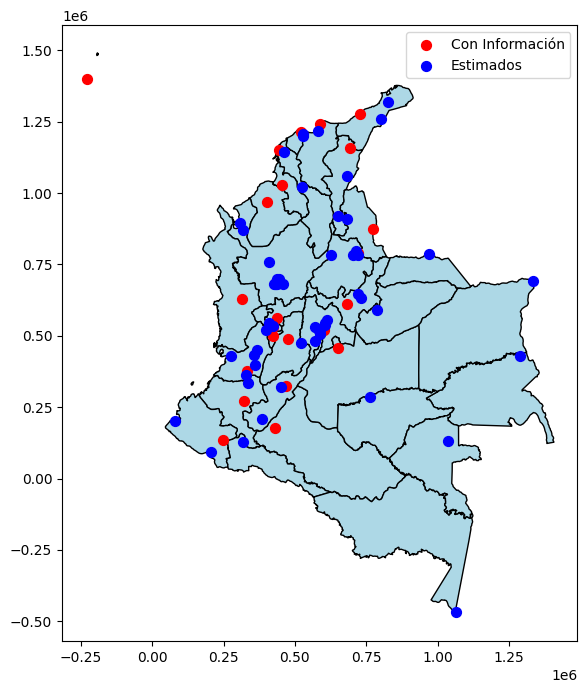

In [110]:

Grafica_krig= Departamentos.copy()
Grafica_krig.set_crs(epsg=4326, inplace=True)
Grafica_krig=Grafica_krig.to_crs(epsg=32618)  

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
Grafica_krig.plot(ax=ax, color='lightblue', edgecolor='black', label='Municipios')
gastos_sin_Nan.plot(ax=ax, column='Gasto Promedio Diario', color='red', markersize=50, label='Con Información')
gastos_con_Nan.plot(ax=ax, column='Gasto Promedio Diario', color='blue', markersize=50, label='Estimados')
plt.legend()
plt.show()


Since these are prices, a loess decomposition is not advisable since we would only be subtracting value from the units, so let's assume that this price is the average annual price.

In [111]:

gastos_krigg_mensual = gastos_krigg.loc[gastos_krigg.index.repeat(12)].reset_index(drop=True)
gastos_krigg_mensual['Mes'] = (gastos_krigg_mensual.index % 12) + 1
gastos_krigg_mensual

,Ciudad,Gasto Promedio Diario,Gasto Alojamiento Diario,Gasto Transporte Diario,Gasto alimetos Diario,Otros Gastos Diario,geometry,Mes
0,pitalito,66575.110188,8394.697673,13991.037003,15601.033377,22348.735798,POINT (384119.441 209921.192),1
1,pitalito,66575.110188,8394.697673,13991.037003,15601.033377,22348.735798,POINT (384119.441 209921.192),2
2,pitalito,66575.110188,8394.697673,13991.037003,15601.033377,22348.735798,POINT (384119.441 209921.192),3
3,pitalito,66575.110188,8394.697673,13991.037003,15601.033377,22348.735798,POINT (384119.441 209921.192),4
4,pitalito,66575.110188,8394.697673,13991.037003,15601.033377,22348.735798,POINT (384119.441 209921.192),5
...,...,...,...,...,...,...,...,...
967,sanandres,52782.119461,997.409627,2252.404023,8881.306238,40491.605010,POINT (-229327.357 1400533.283),8
968,sanandres,52782.119461,997.409627,2252.404023,8881.306238,40491.605010,POINT (-229327.357 1400533.283),9
969,sanandres,52782.119461,997.409627,2252.404023,8881.306238,40491.605010,POINT (-229327.357 1400533.283),10
970,sanandres,52782.119461,997.409627,2252.404023,8881.306238,40491.605010,POINT (-229327.357 1400533.283),11


### Join the database

In [113]:

final5 = pd.merge(final4, gastos_krigg_mensual, on=['Mes', 'Ciudad'], how='left').drop(['geometry_x','population'] , axis=1)
final5[final5['Ciudad'] == 'bogota']

,Ciudad,Mes,Extranjeros no Residentes,Homicidios,Hurtos,Delitos Sexuales,Departamento,Temperatura,Dolar,Pib Ponderado,...,HABITACIONES,CAMAS,distancia_ponderada_TOP,Proxy_Pobreza,Gasto Promedio Diario,Gasto Alojamiento Diario,Gasto Transporte Diario,Gasto alimetos Diario,Otros Gastos Diario,geometry_y
3,bogota,1,99767.0,83,7149,426,bogotadc,12.600,2855.86,23953.819812,...,2389.671820,3536.450187,0.604552,0.003006,90802.287091,18932.685096,14867.760371,23000.094518,33676.461464,POINT (602898.9 520798.299)
84,bogota,2,105463.0,87,7657,403,bogotadc,13.700,2853.16,22107.668727,...,2382.128096,3525.286309,0.604552,0.002775,90802.287091,18932.685096,14867.760371,23000.094518,33676.461464,POINT (602898.9 520798.299)
165,bogota,3,110808.0,93,8226,401,bogotadc,13.600,2852.48,21357.991522,...,2437.796062,3607.668746,0.604552,0.002680,90802.287091,18932.685096,14867.760371,23000.094518,33676.461464,POINT (602898.9 520798.299)
246,bogota,4,100289.0,89,9208,425,bogotadc,13.250,2780.47,21060.810012,...,2444.869331,3618.136401,0.604552,0.002643,90802.287091,18932.685096,14867.760371,23000.094518,33676.461464,POINT (602898.9 520798.299)
327,bogota,5,96886.0,84,9090,476,bogotadc,13.500,2863.12,20608.644964,...,2379.259157,3521.040595,0.604552,0.002586,90802.287091,18932.685096,14867.760371,23000.094518,33676.461464,POINT (602898.9 520798.299)
408,bogota,6,99380.0,70,8123,421,bogotadc,13.400,2889.69,20636.330927,...,2381.720647,3524.683328,0.604552,0.002590,90802.287091,18932.685096,14867.760371,23000.094518,33676.461464,POINT (602898.9 520798.299)
489,bogota,7,111475.0,93,8567,453,bogotadc,13.200,2881.09,21097.951567,...,2453.353939,3630.692684,0.604552,0.002648,90802.287091,18932.685096,14867.760371,23000.094518,33676.461464,POINT (602898.9 520798.299)
570,bogota,8,111850.0,85,9612,560,bogotadc,13.100,2958.45,20949.661603,...,2435.195434,3603.820104,0.604552,0.002629,90802.287091,18932.685096,14867.760371,23000.094518,33676.461464,POINT (602898.9 520798.299)
651,bogota,9,98044.0,100,9294,546,bogotadc,13.715,3026.05,20865.039625,...,2370.657059,3508.310442,0.604552,0.002619,90802.287091,18932.685096,14867.760371,23000.094518,33676.461464,POINT (602898.9 520798.299)
732,bogota,10,99418.0,79,10101,430,bogotadc,13.600,3087.46,20934.273783,...,2337.650899,3459.464972,0.604552,0.002627,90802.287091,18932.685096,14867.760371,23000.094518,33676.461464,POINT (602898.9 520798.299)


## Do the same but now with average spending for the entire trip.

In [114]:

gastos_viaje = pd.read_excel('C:\\Users\\alejo\\OneDrive\\Escritorio\\Universidaad\\Colab Notebooks\\Ia en economia\\Proyecto\\Gasto Promedio Viaje 2019.xlsx')
gastos_viaje = arreglar_texto(gastos_viaje , 'Ciudad', 'Ciudad')

ciudades_geometry = Total_18_Geometry[['Ciudad' , 'geometry']].drop_duplicates()
gastos_viaje = pd.merge(gastos_viaje, ciudades_geometry, on='Ciudad', how='left')
gastos_viaje


inflacion_2019_promedio = 3.80 / 100
inflacion_2019_aliemntos= 5.80 / 100
inflacion_2019_transporte= 3.41 /100
inflacion_2019_alojamiento = 3.46/100

l2=[inflacion_2019_promedio, inflacion_2019_alojamiento,inflacion_2019_transporte,inflacion_2019_aliemntos,inflacion_2019_promedio]
c=-1
for i in gastos_viaje.iloc[: ,1:-1]:
    c=c+1
    gastos_viaje[i] = gastos_viaje[i] / (1+ l2[c])

gastos_viaje.head()

La funcion demoro 0.003342151641845703


,Ciudad,Gasto Promedio Viaje,Gasto Alojamiento Viaje,Gasto Transporte Viaje,Gasto alimetos Viaje,Otros Gastos Viaje,geometry
0,medellin,274400.758189,50224.289581,53411.525965,102644.152174,66508.251445,POINT (-75.5906 6.2308)
1,barranquilla,401216.145472,82734.348540,74850.610192,101757.345936,140465.427746,POINT (-74.8019 10.9833)
2,bogota,459819.807322,95874.495457,75289.853012,116471.723062,170536.499037,POINT (-74.0722 4.7111)
3,cartagena,370761.745665,49001.936014,74453.506431,93031.950851,152922.075145,POINT (-75.5 10.4)
4,tunja,245133.159923,33834.054707,58936.984818,85632.614367,65411.817919,POINT (-73.3667 5.5333)


In [115]:

gastos_viaje_Nan = pd.merge(gastos_viaje, ciudades_geometry, on='Ciudad', how='outer').drop('geometry_y' , axis=1)
gastos_viaje_Nan = gpd.GeoDataFrame(pd.merge(gastos_viaje_Nan, ciudades_geometry, on='Ciudad', how='left').drop('geometry_x' , axis=1) , geometry='geometry')
gastos_viaje_Nan

,Ciudad,Gasto Promedio Viaje,Gasto Alojamiento Viaje,Gasto Transporte Viaje,Gasto alimetos Viaje,Otros Gastos Viaje,geometry
0,medellin,274400.758189,50224.289581,53411.525965,102644.152174,66508.251445,POINT (-75.5906 6.2308)
1,barranquilla,401216.145472,82734.348540,74850.610192,101757.345936,140465.427746,POINT (-74.8019 10.9833)
2,bogota,459819.807322,95874.495457,75289.853012,116471.723062,170536.499037,POINT (-74.0722 4.7111)
3,cartagena,370761.745665,49001.936014,74453.506431,93031.950851,152922.075145,POINT (-75.5 10.4)
4,tunja,245133.159923,33834.054707,58936.984818,85632.614367,65411.817919,POINT (-73.3667 5.5333)
...,...,...,...,...,...,...,...
76,aguachica,NaN,NaN,NaN,NaN,NaN,POINT (-73.6333 8.3167)
77,sanjosedelguaviare,NaN,NaN,NaN,NaN,NaN,POINT (-72.6333 2.5667)
78,palermo,NaN,NaN,NaN,NaN,NaN,POINT (-75.4375 2.8917)
79,mitu,NaN,NaN,NaN,NaN,NaN,POINT (-70.1733 1.1983)


### Again a krigging

In [116]:
print('Lac cantidad de NaN que hay en la variable temperatura es:' ,gastos_viaje_Nan['Gasto Promedio Viaje'].isnull().sum())

Lac cantidad de NaN que hay en la variable temperatura es: 57


In [117]:
gastos_viaje_Nan.set_crs(epsg=4326, inplace=True)
gastos_viaje_Nan=gastos_viaje_Nan.to_crs(epsg=32618) 
variables = [i for i in gastos_viaje_Nan.columns][1:-1]
gastos_sin_Nan = gastos_viaje_Nan.dropna(subset=variables)
gastos_con_Nan = gastos_viaje_Nan[gastos_viaje_Nan[variables].isnull().any(axis=1)]

### We use the function created above

In [ ]:
# Usamos la funcion creada arriba 
for var in variables:
    OK, gridx, gridy, z1 = kriging(gastos_sin_Nan, var)
    
    estimados = estimar(OK, gastos_con_Nan)
    gastos_con_Nan[var] = estimados

gastos_krigg = pd.concat([gastos_con_Nan, gastos_sin_Nan], ignore_index=True)


### We dont have more Nans

In [119]:
print('Lac cantidad de NaN que hay en la variable temperatura es:' ,gastos_krigg['Gasto Promedio Viaje'].isnull().sum())
gastos_krigg

Lac cantidad de NaN que hay en la variable temperatura es: 0


,Ciudad,Gasto Promedio Viaje,Gasto Alojamiento Viaje,Gasto Transporte Viaje,Gasto alimetos Viaje,Otros Gastos Viaje,geometry
0,pitalito,338814.831038,51427.415415,83910.734197,86719.142328,129164.039202,POINT (384119.441 209921.192)
1,rionegro,300105.482181,51759.383143,56151.273165,86719.142328,88352.122091,POINT (458587.876 680187.339)
2,piedecuesta,316598.313028,59438.480482,63676.087723,86267.558458,96363.989201,POINT (720906.443 783432.99)
3,duitama,324875.629492,46563.783843,64488.990908,86719.142328,106266.163759,POINT (719599.684 645163.645)
4,mosquera,375255.512748,71218.976614,77041.055524,86887.330648,148540.851057,POINT (585086.575 520411.851)
...,...,...,...,...,...,...,...
76,bucaramanga,297053.347784,64724.372704,65030.710763,84674.412098,81448.702312,POINT (720882.544 788963.63)
77,sincelejo,422449.012524,52115.359559,100715.374722,130185.170132,137473.838150,POINT (456498.584 1027491.106)
78,ibague,355245.839114,48587.152523,85190.022242,101786.748582,118199.932563,POINT (474116.636 490026.735)
79,cali,248627.930636,45900.289967,45790.420656,66418.689036,89561.179191,POINT (330897.116 378217.634)


In [120]:
gastos_krigg_mensual_viaje = gastos_krigg.loc[gastos_krigg.index.repeat(12)].reset_index(drop=True)
gastos_krigg_mensual_viaje['Mes'] = (gastos_krigg_mensual_viaje.index % 12) + 1
gastos_krigg_mensual_viaje

,Ciudad,Gasto Promedio Viaje,Gasto Alojamiento Viaje,Gasto Transporte Viaje,Gasto alimetos Viaje,Otros Gastos Viaje,geometry,Mes
0,pitalito,338814.831038,51427.415415,83910.734197,86719.142328,129164.039202,POINT (384119.441 209921.192),1
1,pitalito,338814.831038,51427.415415,83910.734197,86719.142328,129164.039202,POINT (384119.441 209921.192),2
2,pitalito,338814.831038,51427.415415,83910.734197,86719.142328,129164.039202,POINT (384119.441 209921.192),3
3,pitalito,338814.831038,51427.415415,83910.734197,86719.142328,129164.039202,POINT (384119.441 209921.192),4
4,pitalito,338814.831038,51427.415415,83910.734197,86719.142328,129164.039202,POINT (384119.441 209921.192),5
...,...,...,...,...,...,...,...,...
967,sanandres,462369.558767,8737.270443,19730.985398,77799.942344,354705.076108,POINT (-229327.357 1400533.283),8
968,sanandres,462369.558767,8737.270443,19730.985398,77799.942344,354705.076108,POINT (-229327.357 1400533.283),9
969,sanandres,462369.558767,8737.270443,19730.985398,77799.942344,354705.076108,POINT (-229327.357 1400533.283),10
970,sanandres,462369.558767,8737.270443,19730.985398,77799.942344,354705.076108,POINT (-229327.357 1400533.283),11


In [121]:
final6 = pd.merge(final5, gastos_krigg_mensual_viaje, on=['Mes', 'Ciudad'], how='left').drop('geometry_y' , axis=1)
final6[final6['Ciudad'] == 'bogota'].head(5)

,Ciudad,Mes,Extranjeros no Residentes,Homicidios,Hurtos,Delitos Sexuales,Departamento,Temperatura,Dolar,Pib Ponderado,...,Gasto Alojamiento Diario,Gasto Transporte Diario,Gasto alimetos Diario,Otros Gastos Diario,Gasto Promedio Viaje,Gasto Alojamiento Viaje,Gasto Transporte Viaje,Gasto alimetos Viaje,Otros Gastos Viaje,geometry
3,bogota,1,99767.0,83,7149,426,bogotadc,12.60,2855.86,23953.819812,...,18932.685096,14867.760371,23000.094518,33676.461464,459819.807322,95874.495457,75289.853012,116471.723062,170536.499037,POINT (602898.9 520798.299)
84,bogota,2,105463.0,87,7657,403,bogotadc,13.70,2853.16,22107.668727,...,18932.685096,14867.760371,23000.094518,33676.461464,459819.807322,95874.495457,75289.853012,116471.723062,170536.499037,POINT (602898.9 520798.299)
165,bogota,3,110808.0,93,8226,401,bogotadc,13.60,2852.48,21357.991522,...,18932.685096,14867.760371,23000.094518,33676.461464,459819.807322,95874.495457,75289.853012,116471.723062,170536.499037,POINT (602898.9 520798.299)
246,bogota,4,100289.0,89,9208,425,bogotadc,13.25,2780.47,21060.810012,...,18932.685096,14867.760371,23000.094518,33676.461464,459819.807322,95874.495457,75289.853012,116471.723062,170536.499037,POINT (602898.9 520798.299)
327,bogota,5,96886.0,84,9090,476,bogotadc,13.50,2863.12,20608.644964,...,18932.685096,14867.760371,23000.094518,33676.461464,459819.807322,95874.495457,75289.853012,116471.723062,170536.499037,POINT (602898.9 520798.299)


## We add inflation

In [122]:

inflacion = pd.read_excel('C:\\Users\\alejo\\OneDrive\\Escritorio\\Universidaad\\Colab Notebooks\\Ia en economia\\Proyecto\\Inflacion.xlsx')
inflacion['Fecha'] = pd.to_datetime(inflacion['Fecha'])
inflacion = inflacion[inflacion['Fecha'].dt.year == 2018].rename(columns={'Fecha':'Mes'})
inflacion['Mes'] = inflacion['Mes'].dt.month
final7 = pd.merge(final6, inflacion, on='Mes', how='left')
inflacion

,Mes,Inflacion
0,1,3.679528
1,2,3.372119
2,3,3.139859
3,4,3.127613
4,5,3.156785
5,6,3.198022
6,7,3.119155
7,8,3.098241
8,9,3.226776
9,10,3.333750


### Chart for inflation

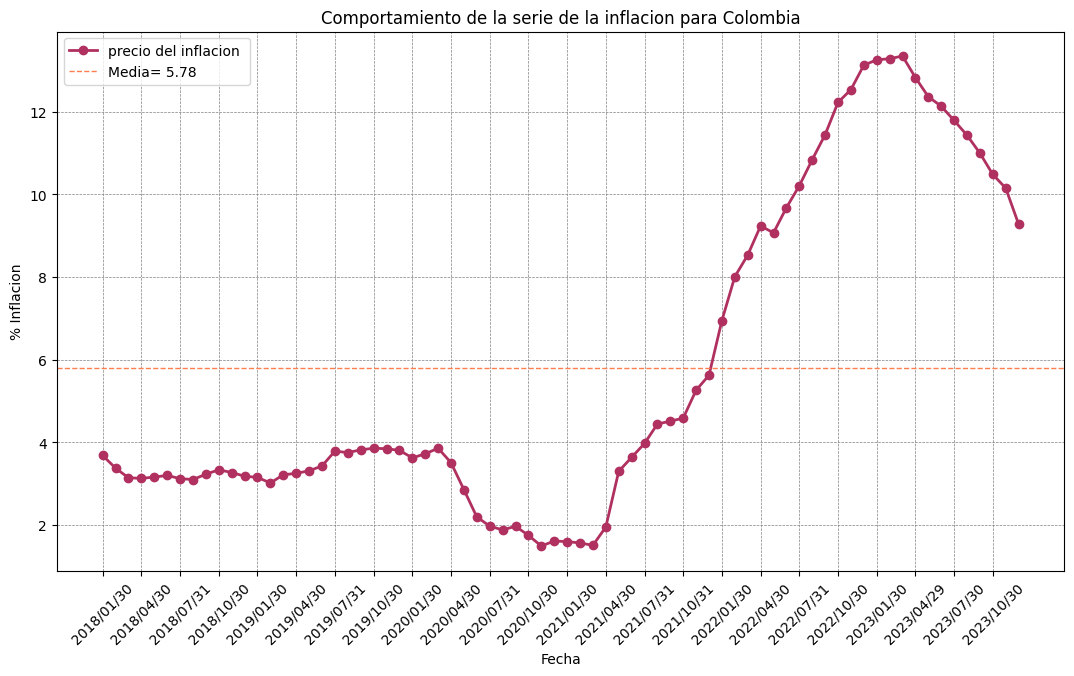

In [123]:
inflacion1 = pd.read_excel('C:\\Users\\alejo\\OneDrive\\Escritorio\\Universidaad\\Colab Notebooks\\Ia en economia\\Proyecto\\Inflacion.xlsx')

mean = inflacion1['Inflacion'].mean()
plt.figure(figsize=(13, 7))    
plt.plot(inflacion1['Fecha'], inflacion1['Inflacion'] ,label="precio del inflacion ", 
         linewidth=2 , color='#B03060' , marker='o')
plt.axhline(mean, color='#FF7F50', linestyle='--', label='Media= 5.78 ', linewidth=1)
cuartiles_a_mostrar = inflacion1['Fecha'][::3]
plt.xticks(cuartiles_a_mostrar, rotation=45)
plt.xlabel('Fecha')
plt.ylabel('% Inflacion')
plt.title('Comportamiento de la serie de la inflacion para Colombia')
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

### We added inflation to the final df we were working on.

In [169]:

final7 = pd.merge(final6, inflacion, on='Mes', how='left')
final7[final7['Ciudad'] == 'medellin'].head(5)

,Ciudad,Mes,Extranjeros no Residentes,Homicidios,Hurtos,Delitos Sexuales,Departamento,Temperatura,Dolar,Pib Ponderado,...,Gasto Transporte Diario,Gasto alimetos Diario,Otros Gastos Diario,Gasto Promedio Viaje,Gasto Alojamiento Viaje,Gasto Transporte Viaje,Gasto alimetos Viaje,Otros Gastos Viaje,geometry,Inflacion
40,medellin,1,28735.0,56,1398,187,antioquia,19.2,2855.86,6081.597689,...,12482.592593,23988.551985,15543.375723,274400.758189,50224.289581,53411.525965,102644.152174,66508.251445,POINT (434665.511 688754.358),3.679528
121,medellin,2,29947.0,40,1524,190,antioquia,20.3,2853.16,5612.881290,...,12482.592593,23988.551985,15543.375723,274400.758189,50224.289581,53411.525965,102644.152174,66508.251445,POINT (434665.511 688754.358),3.372119
202,medellin,3,30756.0,42,1586,151,antioquia,20.2,2852.48,5422.546922,...,12482.592593,23988.551985,15543.375723,274400.758189,50224.289581,53411.525965,102644.152174,66508.251445,POINT (434665.511 688754.358),3.139859
283,medellin,4,27790.0,57,1885,192,antioquia,19.2,2780.47,5347.095975,...,12482.592593,23988.551985,15543.375723,274400.758189,50224.289581,53411.525965,102644.152174,66508.251445,POINT (434665.511 688754.358),3.127613
364,medellin,5,26950.0,64,1934,209,antioquia,19.2,2863.12,5232.296501,...,12482.592593,23988.551985,15543.375723,274400.758189,50224.289581,53411.525965,102644.152174,66508.251445,POINT (434665.511 688754.358),3.156785


## Number of roads within a radius to the cities

In [125]:
vias = gpd.read_file('C:\\Users\\alejo\\OneDrive\\Escritorio\\Universidaad\\Colab Notebooks\\Ia en economia\\Proyecto\\RedVial.zip')
vias['distancia'] = abs(vias['distanciaf'] - vias['distanciai'])
vias_imp = vias[['distancia' , 'geometry']]
vias_imp

,distancia,geometry
0,300.0,"LINESTRING (-8208801.596 929692.74, -8208818.1..."
1,620.0,"LINESTRING (-8209509.975 928485.913, -8209510...."
2,610.0,"LINESTRING (-8194415.391 925328.922, -8194414...."
3,920.0,"LINESTRING (-8193762.11 923673.078, -8193784.2..."
4,812.0,"MULTILINESTRING ((-8176866.277 880900.503, -81..."
...,...,...
642,0.0,"LINESTRING (-8424334.227 1051159.449, -8424328..."
643,96.0,"MULTILINESTRING ((-8203336.493 572672.725, -82..."
644,96.0,"LINESTRING (-8193583.221 580138.916, -8193582...."
645,96.0,"LINESTRING (-8192111.076 582040.29, -8192109.6..."


In [126]:
ciudades_geom= gpd.read_file('C:\\Users\\alejo\\OneDrive\\Escritorio\\Universidaad\\Colab Notebooks\\Ia en economia\\Proyecto\\Ciudades Colombia Geometry.geojson')
ciudades_geom

,Ciudades,geometry
0,Barranquilla,"POLYGON ((-74.80539 11.03706, -74.82747 11.045..."
1,Cali,"POLYGON ((-76.52195 3.36074, -76.50713 3.36522..."
2,Bello,"POLYGON ((-75.5437 6.35413, -75.55764 6.35469,..."
3,Maicao,"POLYGON ((-72.22123 11.36653, -72.22178 11.367..."
4,Inírida,"POLYGON ((-67.90653 3.88167, -67.90396 3.88461..."
...,...,...
76,La Jagua de Ibirico,"POLYGON ((-73.32651 9.57174, -73.32523 9.574, ..."
77,Leticia,"POLYGON ((-69.94426 -4.22371, -69.94227 -4.223..."
78,La Virginia,"POLYGON ((-75.87017 4.89399, -75.87276 4.89569..."
79,Mitú,"POLYGON ((-70.23955 1.24303, -70.23443 1.2437,..."


### We make both bases have the coordinate system to graph and measure distance

In [127]:

ciudades_geom = ciudades_geom.to_crs(epsg=4326)
vias_imp = vias_imp.to_crs(epsg=4326)

### We graph the bial network and the different cities

C:\Users\alejo\AppData\Local\Temp\ipykernel_11896\1296150330.py:5: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


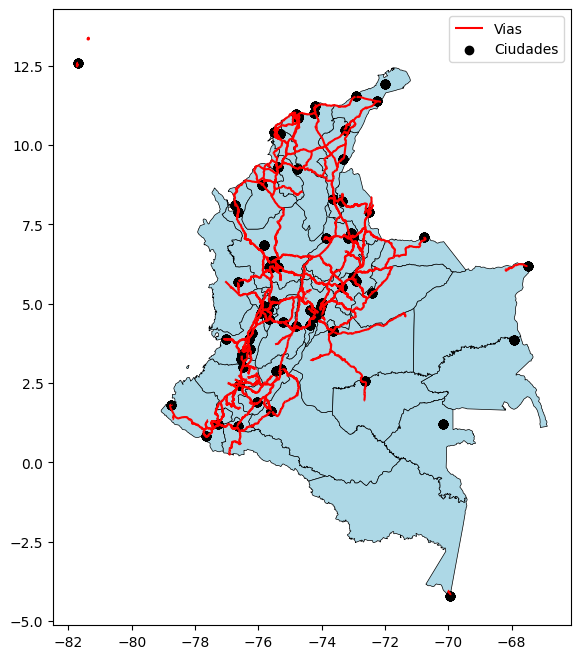

In [128]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
Departamentos.plot(ax=ax, color='lightblue', edgecolor='black', linewidth=0.5, label='Departamentos')
vias_imp.plot(ax=ax, color='red', edgecolor='black', label='Vias')
Total_18_Geometry.plot(ax=ax, color='black', marker='o', label='Ciudades')
plt.legend()
plt.show()

### Let's see how many nearby roads there are within a 10km radius

In [129]:
ciudades_geom = ciudades_geom.to_crs(epsg=32617)
vias_imp = vias_imp.to_crs(epsg=32617)

buffer_distancia = 10000 

ciudades_geom['buffer'] = ciudades_geom.geometry.buffer(buffer_distancia)
ciudades_buffer = gpd.GeoDataFrame(ciudades_geom, geometry='buffer', crs=ciudades_geom.crs).drop('geometry' , axis=1)

# Realizamos un join por cercania
join = gpd.sjoin(vias_imp, ciudades_buffer, how='inner', predicate='intersects')

# Contamos con cuantas carreteras se intercectan las ciudades
conteo_carreteras = join.groupby('Ciudades').size().reset_index(name='carreteras_cercanas')
ciudades_geom = ciudades_geom.merge(conteo_carreteras, on='Ciudades', how='left')
ciudades_geom['carreteras_cercanas'] = ciudades_geom['carreteras_cercanas'].fillna(0).astype(int)
ciudades_geom

,Ciudades,geometry,buffer,carreteras_cercanas
0,Barranquilla,"POLYGON ((1177871.24 1227113.225, 1175426.474 ...","POLYGON ((1162963.759 1218642.8, 1162689.681 1...",10
1,Cali,"POLYGON ((997950.504 372609.448, 999599.824 37...","POLYGON ((987209.746 388137.278, 987358.404 38...",11
2,Bello,"POLYGON ((1104342.179 705542.642, 1102793.391 ...","POLYGON ((1104573.724 692044.795, 1104086.039 ...",3
3,Maicao,"POLYGON ((1461319.595 1271106.142, 1461254.016...","POLYGON ((1448339.819 1265373.48, 1448239.352 ...",2
4,Inírida,"POLYGON ((1966442.467 440543.304, 1966730.927 ...","POLYGON ((1953031.559 438516.247, 1952998.415 ...",0
...,...,...,...,...
76,La Jagua de Ibirico,"POLYGON ((1344461.292 1067508.874, 1344597.607...","POLYGON ((1335035.192 1059880.272, 1334831.709...",1
77,Leticia,"POLYGON ((1734560.63 -475711.877, 1734785.68 -...","POLYGON ((1723486.161 -472374.572, 1723301.724...",1
78,La Virginia,"POLYGON ((1069509.341 543125.129, 1069220.084 ...","POLYGON ((1061734.999 534679.194, 1061681.283 ...",12
79,Mitú,"POLYGON ((1704230.225 139867.795, 1704810.031 ...","POLYGON ((1694250.14 142599.467, 1694292.141 1...",0


### Join with the DataFrame of rodas

In [130]:
ciudades_geom =  arreglar_texto(ciudades_geom, 'Ciudades' , 'Ciudad')
ciudades_geom

La funcion demoro 0.0009992122650146484


,Ciudad,geometry,buffer,carreteras_cercanas
0,barranquilla,"POLYGON ((1177871.24 1227113.225, 1175426.474 ...","POLYGON ((1162963.759 1218642.8, 1162689.681 1...",10
1,cali,"POLYGON ((997950.504 372609.448, 999599.824 37...","POLYGON ((987209.746 388137.278, 987358.404 38...",11
2,bello,"POLYGON ((1104342.179 705542.642, 1102793.391 ...","POLYGON ((1104573.724 692044.795, 1104086.039 ...",3
3,maicao,"POLYGON ((1461319.595 1271106.142, 1461254.016...","POLYGON ((1448339.819 1265373.48, 1448239.352 ...",2
4,inirida,"POLYGON ((1966442.467 440543.304, 1966730.927 ...","POLYGON ((1953031.559 438516.247, 1952998.415 ...",0
...,...,...,...,...
76,lajaguadeibirico,"POLYGON ((1344461.292 1067508.874, 1344597.607...","POLYGON ((1335035.192 1059880.272, 1334831.709...",1
77,leticia,"POLYGON ((1734560.63 -475711.877, 1734785.68 -...","POLYGON ((1723486.161 -472374.572, 1723301.724...",1
78,lavirginia,"POLYGON ((1069509.341 543125.129, 1069220.084 ...","POLYGON ((1061734.999 534679.194, 1061681.283 ...",12
79,mitu,"POLYGON ((1704230.225 139867.795, 1704810.031 ...","POLYGON ((1694250.14 142599.467, 1694292.141 1...",0


### Join to the dataframe that we are working and lets check if there is Nan

In [170]:

final7 = pd.merge(final7 , ciudades_geom[['Ciudad' , 'carreteras_cercanas']] , on='Ciudad' , how='left')
final7[final7.isnull().any(axis=1)] # Comprobamos si quedaron datos faltantes

,Ciudad,Mes,Extranjeros no Residentes,Homicidios,Hurtos,Delitos Sexuales,Departamento,Temperatura,Dolar,Pib Ponderado,...,Gasto alimetos Diario,Otros Gastos Diario,Gasto Promedio Viaje,Gasto Alojamiento Viaje,Gasto Transporte Viaje,Gasto alimetos Viaje,Otros Gastos Viaje,geometry,Inflacion,carreteras_cercanas


In [171]:
final7[final7['Ciudad'] == 'cartagena'].head(5)

,Ciudad,Mes,Extranjeros no Residentes,Homicidios,Hurtos,Delitos Sexuales,Departamento,Temperatura,Dolar,Pib Ponderado,...,Gasto alimetos Diario,Otros Gastos Diario,Gasto Promedio Viaje,Gasto Alojamiento Viaje,Gasto Transporte Viaje,Gasto alimetos Viaje,Otros Gastos Viaje,geometry,Inflacion,carreteras_cercanas
7,cartagena,1,46031.0,21,448,37,bolivar,27.5,2855.86,2349.074239,...,15474.23535,25435.907514,370761.745665,49001.936014,74453.506431,93031.950851,152922.075145,POINT (445269.937 1149681.547),3.679528,5
88,cartagena,2,51788.0,11,354,45,bolivar,25.7,2853.16,2168.028127,...,15474.23535,25435.907514,370761.745665,49001.936014,74453.506431,93031.950851,152922.075145,POINT (445269.937 1149681.547),3.372119,5
169,cartagena,3,55119.0,21,374,52,bolivar,27.2,2852.48,2094.509689,...,15474.23535,25435.907514,370761.745665,49001.936014,74453.506431,93031.950851,152922.075145,POINT (445269.937 1149681.547),3.139859,5
250,cartagena,4,43105.0,18,429,56,bolivar,27.5,2780.47,2065.366052,...,15474.23535,25435.907514,370761.745665,49001.936014,74453.506431,93031.950851,152922.075145,POINT (445269.937 1149681.547),3.127613,5
331,cartagena,5,37859.0,24,467,51,bolivar,28.2,2863.12,2021.023677,...,15474.23535,25435.907514,370761.745665,49001.936014,74453.506431,93031.950851,152922.075145,POINT (445269.937 1149681.547),3.156785,5


## We graph the access to roads per city

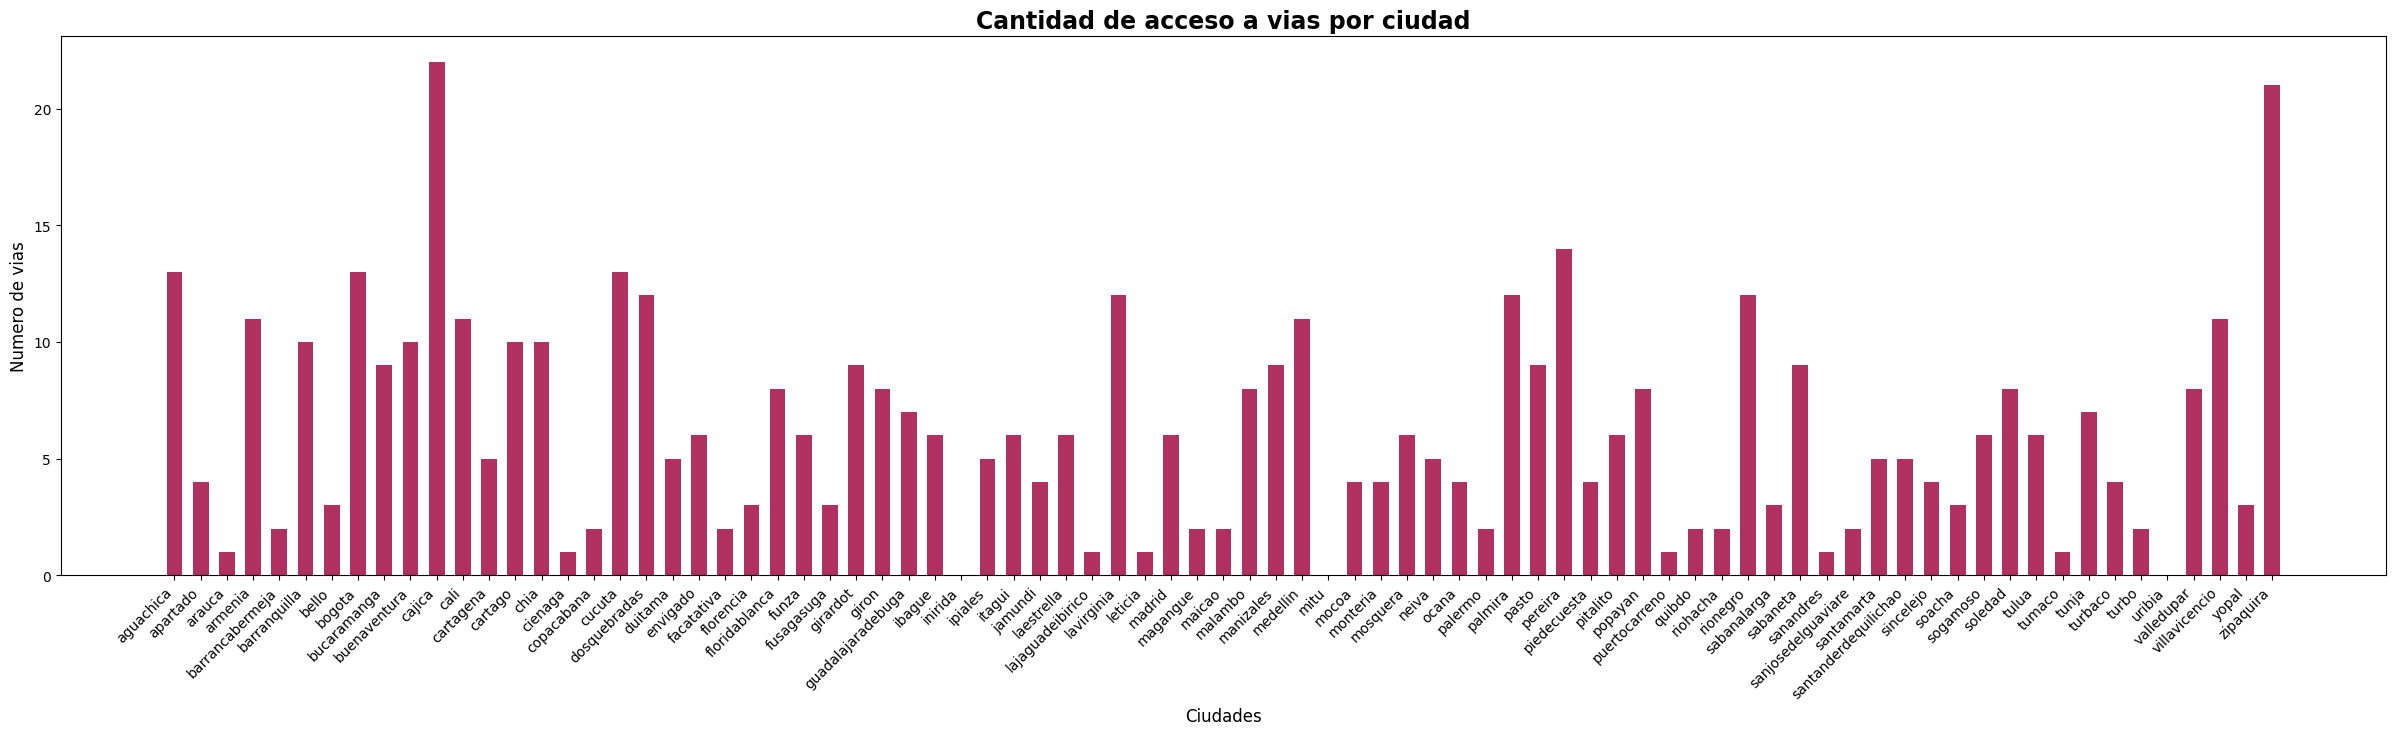

In [134]:
unicos = final7.drop('geometry' , axis=1)
unicos = unicos.drop_duplicates()
dt_vias = unicos.groupby('Ciudad')['carreteras_cercanas'].median().reset_index()

plt.figure(figsize=(30, 7))
plt.bar(dt_vias['Ciudad'], dt_vias['carreteras_cercanas'], width=0.6 , color = '#B03060')
plt.title('Cantidad de acceso a vias por ciudad' , fontsize=17, fontweight='bold')
plt.xlabel('Ciudades', fontsize=12)
plt.ylabel('Numero de vias', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.show()

## Add the number of tourist events


#### Our datasets were compiled using the festival information published on these web pages:
- https://colombia-sa.com/varios/varios-fiestas-2018.html  
- https://www.colombia-sa.com/varios/varios-fiestas.html  

In addition, we drew on the detailed event schedules and descriptions provided in the “events” PDF located in the project folder. By merging the online listings with the PDF’s structured data, we ensured comprehensive coverage of each festival’s date, location, and key characteristics.


In [172]:
eventos = pd.read_excel('C:\\Users\\alejo\\OneDrive\\Escritorio\\Universidaad\\Colab Notebooks\\Ia en economia\\Proyecto\\Eventos Turisticos\\Eventos 2018.xlsx').fillna(0)
eventos = arreglar_texto(eventos ,'Departamento' , 'Departamento')

La funcion demoro 0.0020477771759033203


### Join with the df we are working on

In [173]:

final7 = pd.merge(final7 , eventos , on=['Departamento' ,'Mes'] , how='left')

In [175]:
final7[final7['Ciudad'] == 'bogota'].head(12)

,Ciudad,Mes,Extranjeros no Residentes,Homicidios,Hurtos,Delitos Sexuales,Departamento,Temperatura,Dolar,Pib Ponderado,...,Otros Gastos Diario,Gasto Promedio Viaje,Gasto Alojamiento Viaje,Gasto Transporte Viaje,Gasto alimetos Viaje,Otros Gastos Viaje,geometry,Inflacion,carreteras_cercanas,Eventos
3,bogota,1,99767.0,83,7149,426,bogotadc,12.600,2855.86,23953.819812,...,33676.461464,459819.807322,95874.495457,75289.853012,116471.723062,170536.499037,POINT (602898.9 520798.299),3.679528,13,0.0
84,bogota,2,105463.0,87,7657,403,bogotadc,13.700,2853.16,22107.668727,...,33676.461464,459819.807322,95874.495457,75289.853012,116471.723062,170536.499037,POINT (602898.9 520798.299),3.372119,13,0.0
165,bogota,3,110808.0,93,8226,401,bogotadc,13.600,2852.48,21357.991522,...,33676.461464,459819.807322,95874.495457,75289.853012,116471.723062,170536.499037,POINT (602898.9 520798.299),3.139859,13,1.0
246,bogota,4,100289.0,89,9208,425,bogotadc,13.250,2780.47,21060.810012,...,33676.461464,459819.807322,95874.495457,75289.853012,116471.723062,170536.499037,POINT (602898.9 520798.299),3.127613,13,2.0
327,bogota,5,96886.0,84,9090,476,bogotadc,13.500,2863.12,20608.644964,...,33676.461464,459819.807322,95874.495457,75289.853012,116471.723062,170536.499037,POINT (602898.9 520798.299),3.156785,13,0.0
408,bogota,6,99380.0,70,8123,421,bogotadc,13.400,2889.69,20636.330927,...,33676.461464,459819.807322,95874.495457,75289.853012,116471.723062,170536.499037,POINT (602898.9 520798.299),3.198022,13,1.0
489,bogota,7,111475.0,93,8567,453,bogotadc,13.200,2881.09,21097.951567,...,33676.461464,459819.807322,95874.495457,75289.853012,116471.723062,170536.499037,POINT (602898.9 520798.299),3.119155,13,2.0
570,bogota,8,111850.0,85,9612,560,bogotadc,13.100,2958.45,20949.661603,...,33676.461464,459819.807322,95874.495457,75289.853012,116471.723062,170536.499037,POINT (602898.9 520798.299),3.098241,13,1.0
651,bogota,9,98044.0,100,9294,546,bogotadc,13.715,3026.05,20865.039625,...,33676.461464,459819.807322,95874.495457,75289.853012,116471.723062,170536.499037,POINT (602898.9 520798.299),3.226776,13,2.0
732,bogota,10,99418.0,79,10101,430,bogotadc,13.600,3087.46,20934.273783,...,33676.461464,459819.807322,95874.495457,75289.853012,116471.723062,170536.499037,POINT (602898.9 520798.299),3.333750,13,2.0


## Finalizing Annual Variables

With this, we complete the set of variables to be included for each year (excluding any image-based metrics). In the **Base final** script, the same logic is summarized on a year-by-year basis. For each iteration, be sure to update:

- The LOESS decomposition to match that year’s seasonal pattern  
- The GDP trend inputs to reflect the specific economic growth trajectory  
